# Cross-Country Epidemic Viz 

In [1]:
library(LalRUtils)
libreq(data.table, tidyverse, sf, janitor, anytime, lubridate, plotly, zoo, patchwork, ggrepel)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 20, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "tidyverse"  TRUE  
 [3,] "sf"         TRUE  
 [4,] "janitor"    TRUE  
 [5,] "anytime"    TRUE  
 [6,] "lubridate"  TRUE  
 [7,] "plotly"     TRUE  
 [8,] "zoo"        TRUE  
 [9,] "patchwork"  TRUE  
[10,] "ggrepel"    TRUE  


# JHU

In [2]:
jhu_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
cases = fread(jhu_cases_url)

jhu_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths = fread(jhu_deaths_url)

In [3]:
name_clean = function(df) setnames(df, str_replace(colnames(df), "/", "_"))

In [4]:
cases_long = melt(cases, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "cases") 
name_clean(cases_long)

deaths_long = melt(deaths, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "deaths") 
name_clean(deaths_long)
deaths_long[, c('Lat', 'Long') := NULL]

In [5]:
df = merge(cases_long, deaths_long,
      by = c("Province_State", "Country_Region", "date"), all.x = T)
df[, date := mdy(date)]
df[, day := weekdays(date)]
df[is.na(df)] = 0
df %>% glimpse

Rows: 96,288
Columns: 8
$ Province_State <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ Country_Region <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanis…
$ date           <date> 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-…
$ Lat            <dbl> 33.94, 33.94, 33.94, 33.94, 33.94, 33.94, 33.94, 33.94…
$ Long           <dbl> 67.71, 67.71, 67.71, 67.71, 67.71, 67.71, 67.71, 67.71…
$ cases          <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ day            <chr> "Wednesday", "Thursday", "Friday", "Saturday", "Sunday…


In [6]:
fwrite(df, "data/jhu_panel.csv")

## Country Level

In [7]:
country_ts = df[, lapply(.SD, sum) , by = .(Country_Region, date), .SDcols = c("cases", "deaths")]

In [8]:
(t10countries = country_ts[date == max(country_ts$date)][order(-cases)][1:10])

Country_Region date       cases    deaths
1  US             2021-01-09 22132396 372428
2  India          2021-01-09 10450284 150999
3  Brazil         2021-01-09  8075998 202631
4  Russia         2021-01-09  3344175  60523
5  United Kingdom 2021-01-09  3026342  81000
6  France         2021-01-09  2824920  67734
7  Turkey         2021-01-09  2317118  22631
8  Italy          2021-01-09  2257866  78394
9  Spain          2021-01-09  2050360  51874
10 Germany        2021-01-09  1928462  40597

In [9]:
t10_subset = country_ts[Country_Region %in% t10countries$Country_Region]
setorder(t10_subset, Country_Region, date)
# normalise time from first day with >= 10 cases
t10_subset[cases >= 10,  c_time := seq_len(.N), by = .(Country_Region)]
t10_subset[deaths >= 1, d_time := seq_len(.N), by = .(Country_Region)]

In [10]:
setorder(t10_subset, Country_Region, date)
t10_subset[, new_cases  := cases - shift(cases), by = .(Country_Region)]
t10_subset[, new_deaths := deaths - shift(deaths), by = .(Country_Region)]
t10_subset[, cfr := deaths/cases]
smoothvars = c('cases', 'new_cases', 'deaths', 'new_deaths', 'cfr')
t10_subset[, paste0("rm7_", smoothvars) := lapply(.SD, rollmean, k = 7, fill = NA, na.pad = T), 
   by = .(Country_Region), .SDcols = smoothvars]

In [11]:
t10_subset[, label := ifelse(date == max(date), Country_Region, NA)]

## Cumulative and New Cases / Deaths 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 306 rows containing missing values (geom_point).”
Warning message:
“Removed 340 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 454 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 318 rows 

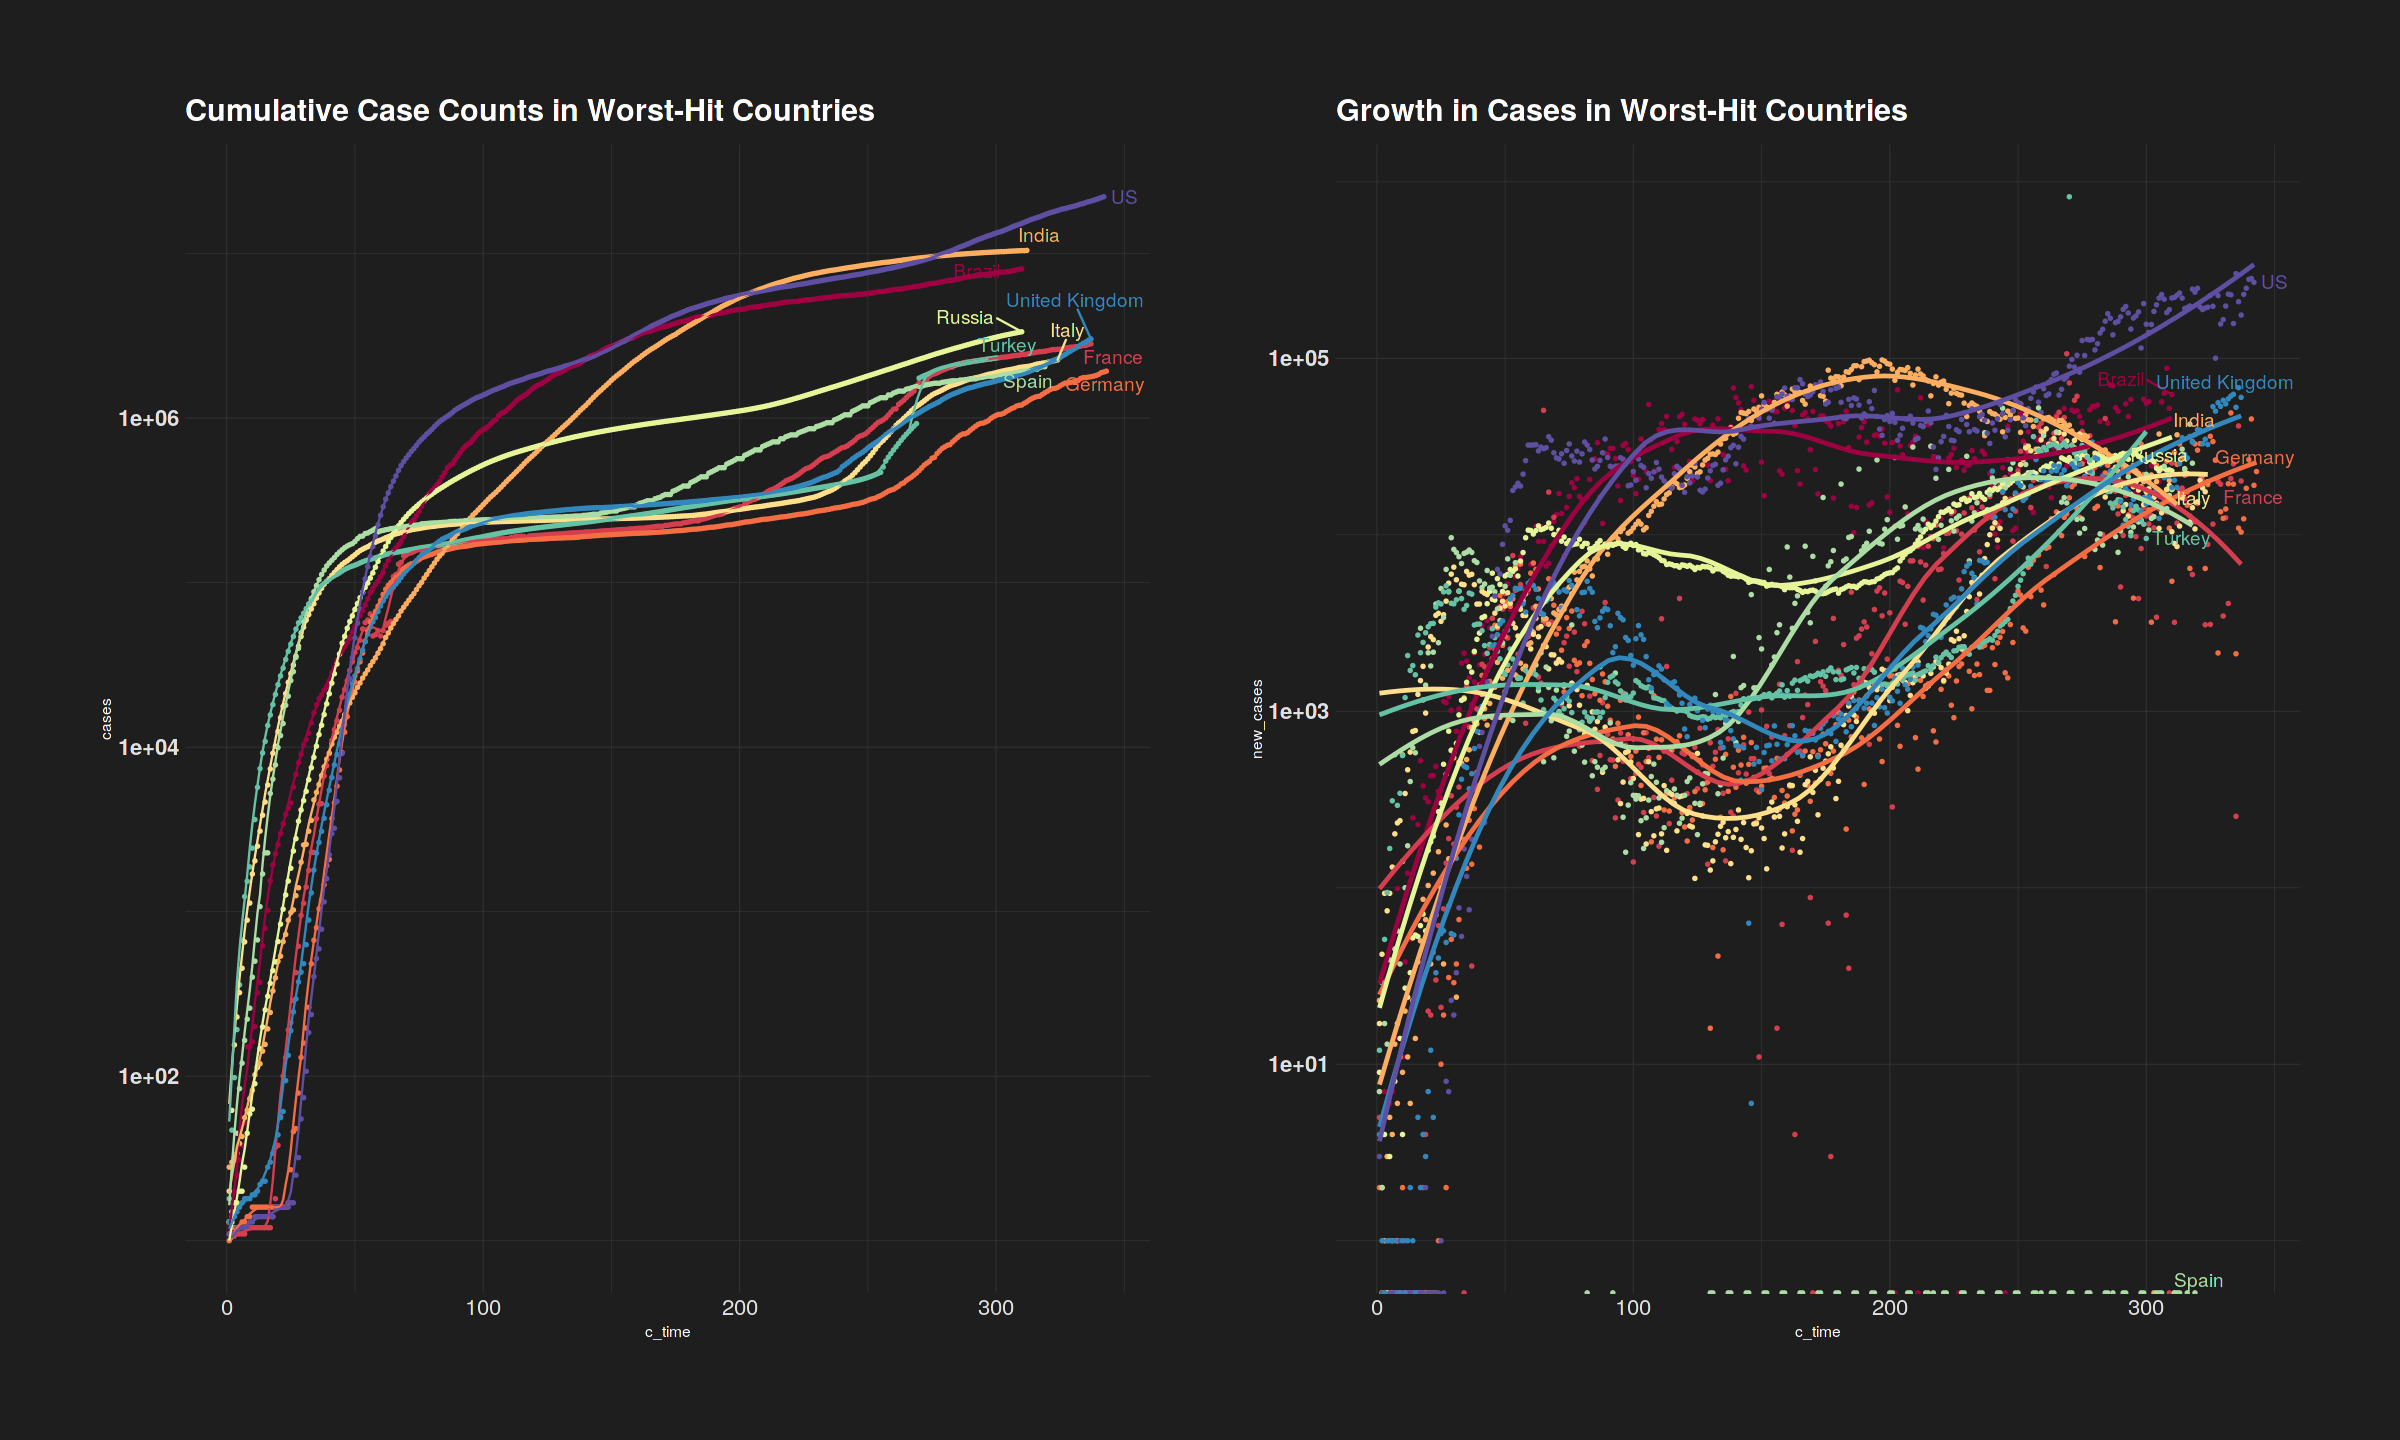

In [12]:
p1 = ggplot(t10_subset,
           aes(x = c_time, y = cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = cases), size = 0.5) + geom_line(aes(y = rm7_cases)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Case Counts in Worst-Hit Countries') 

p2 = 
    t10_subset %>% 
    ggplot(aes(x = c_time,y = new_cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_cases), size = 0.5) + 
#     geom_line(aes(y = rm7_new_cases)) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Cases in Worst-Hit Countries')

(p1 | p2 )

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 518 rows containing missing values (geom_point).”
Warning message:
“Removed 544 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 599 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 454 rows 

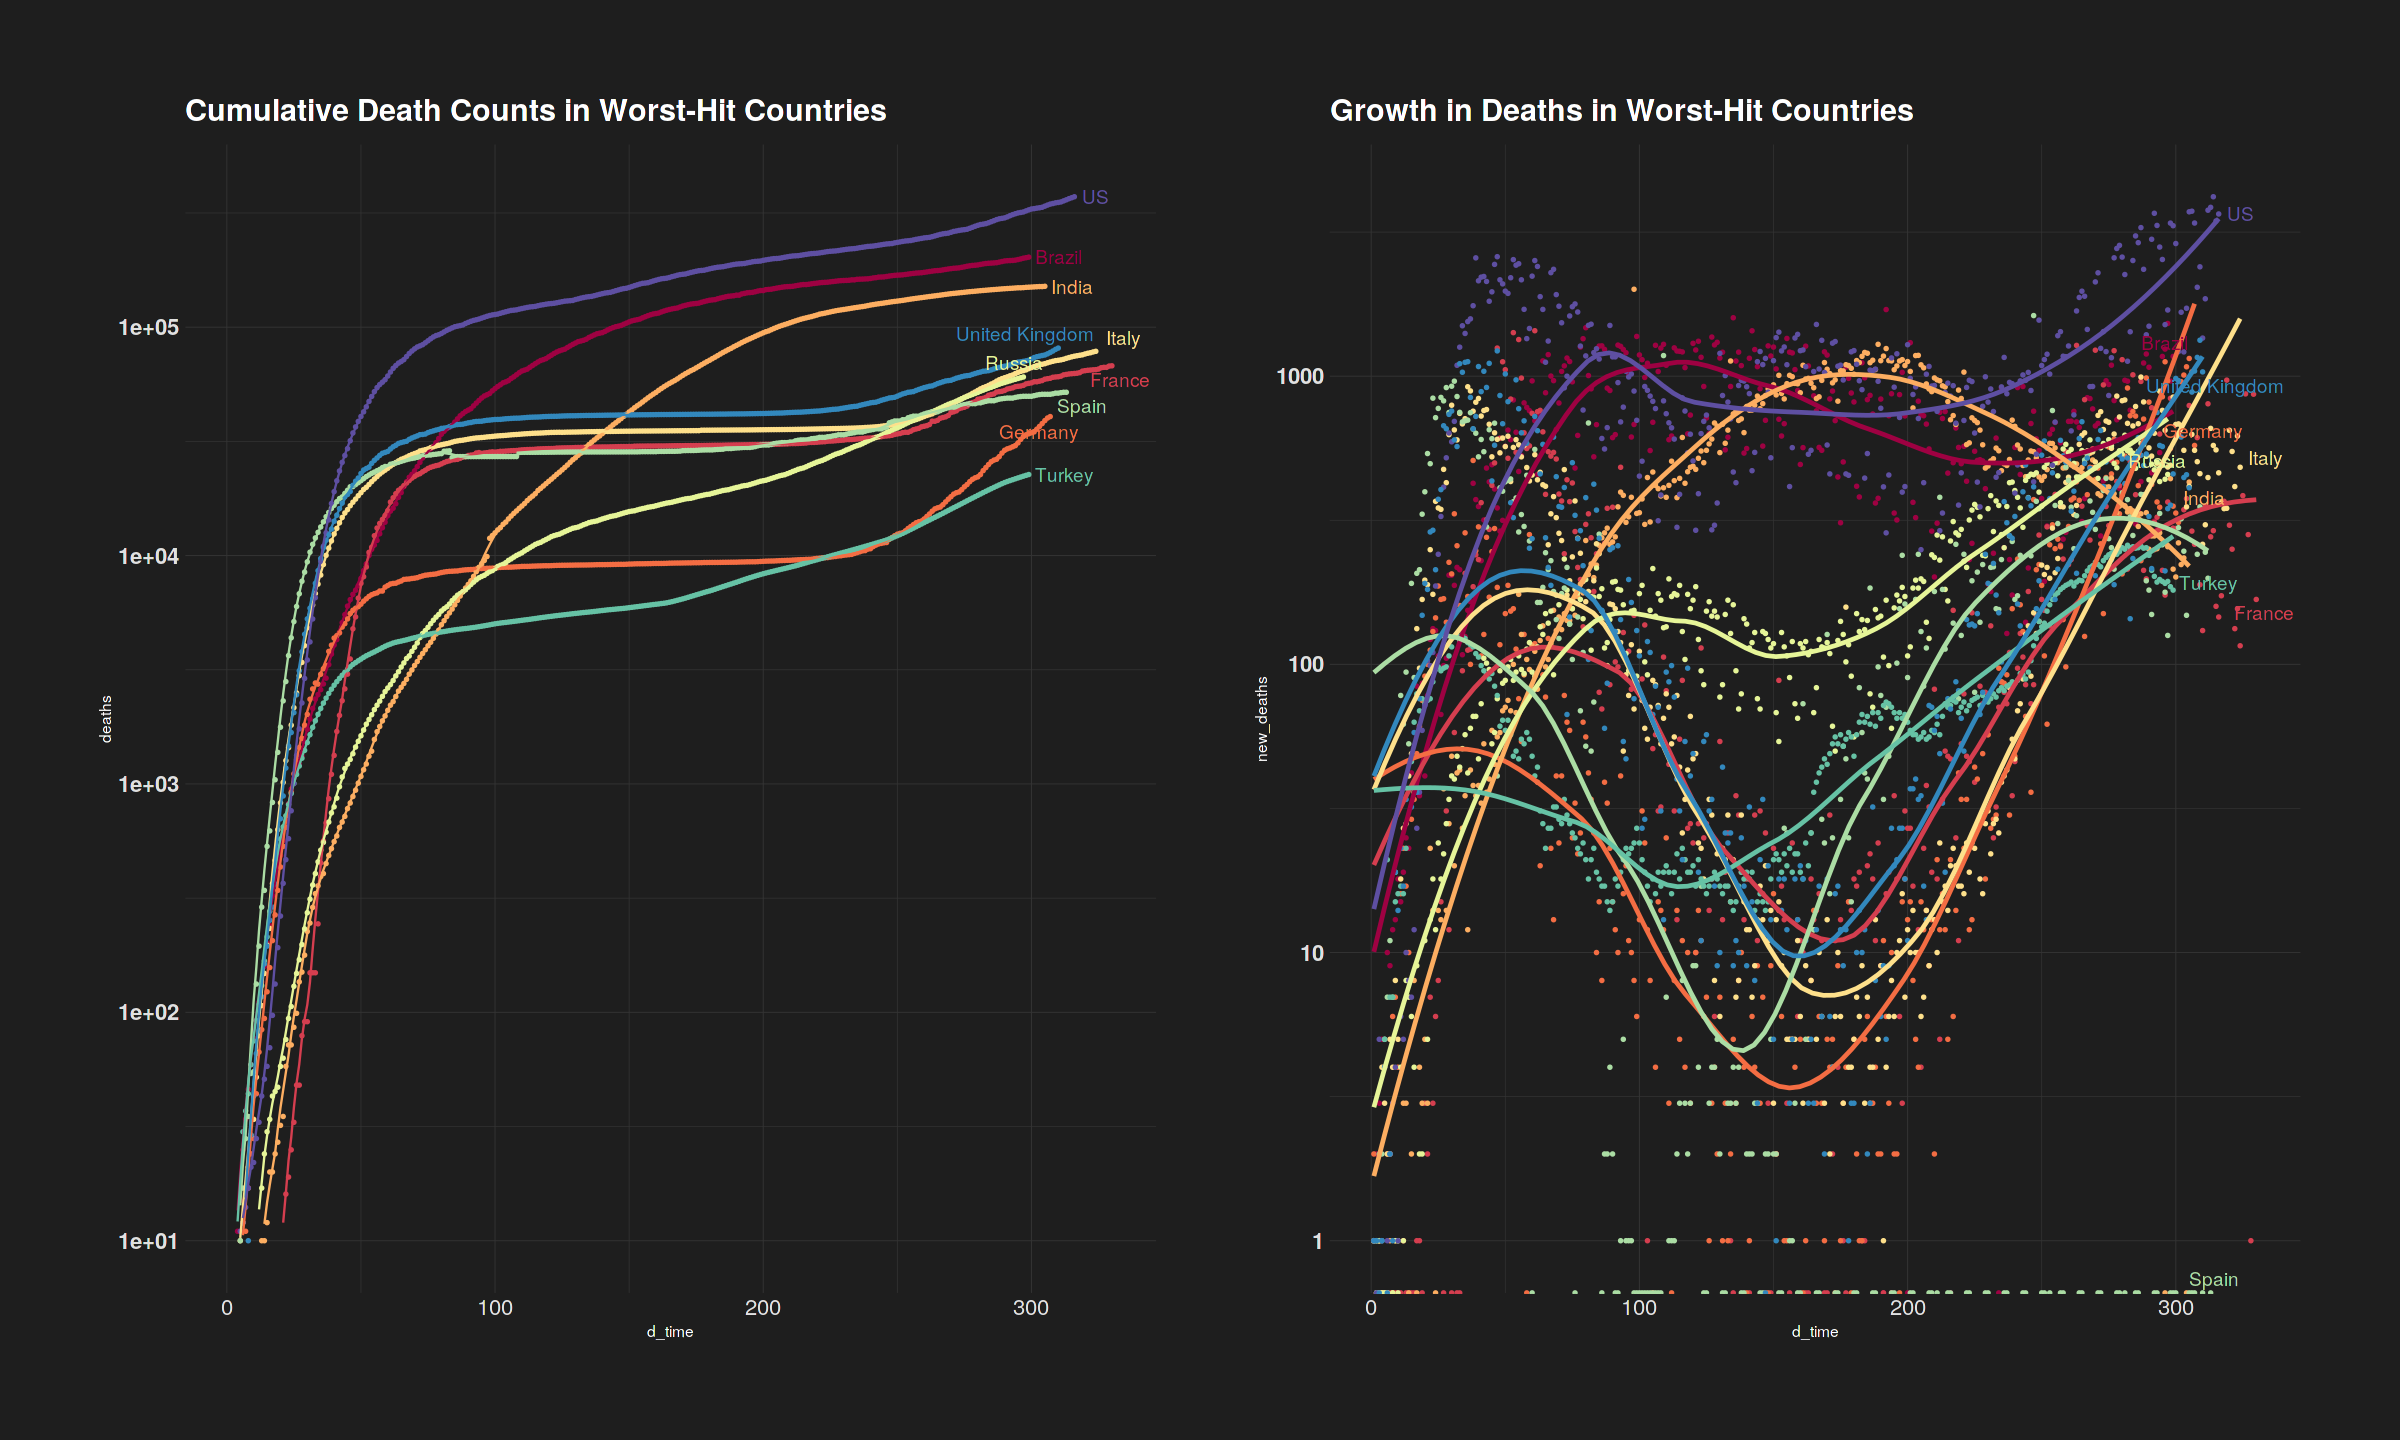

In [13]:
p1 = ggplot(t10_subset,
           aes(x = d_time, y = deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = deaths), size = 0.5) + geom_line(aes(y = rm7_deaths)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Death Counts in Worst-Hit Countries') 

p2 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = new_deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_deaths), size = 0.5) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Deaths in Worst-Hit Countries')

(p1 | p2 )

## Case Fatality Rate

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 440 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 440 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_smooth).”


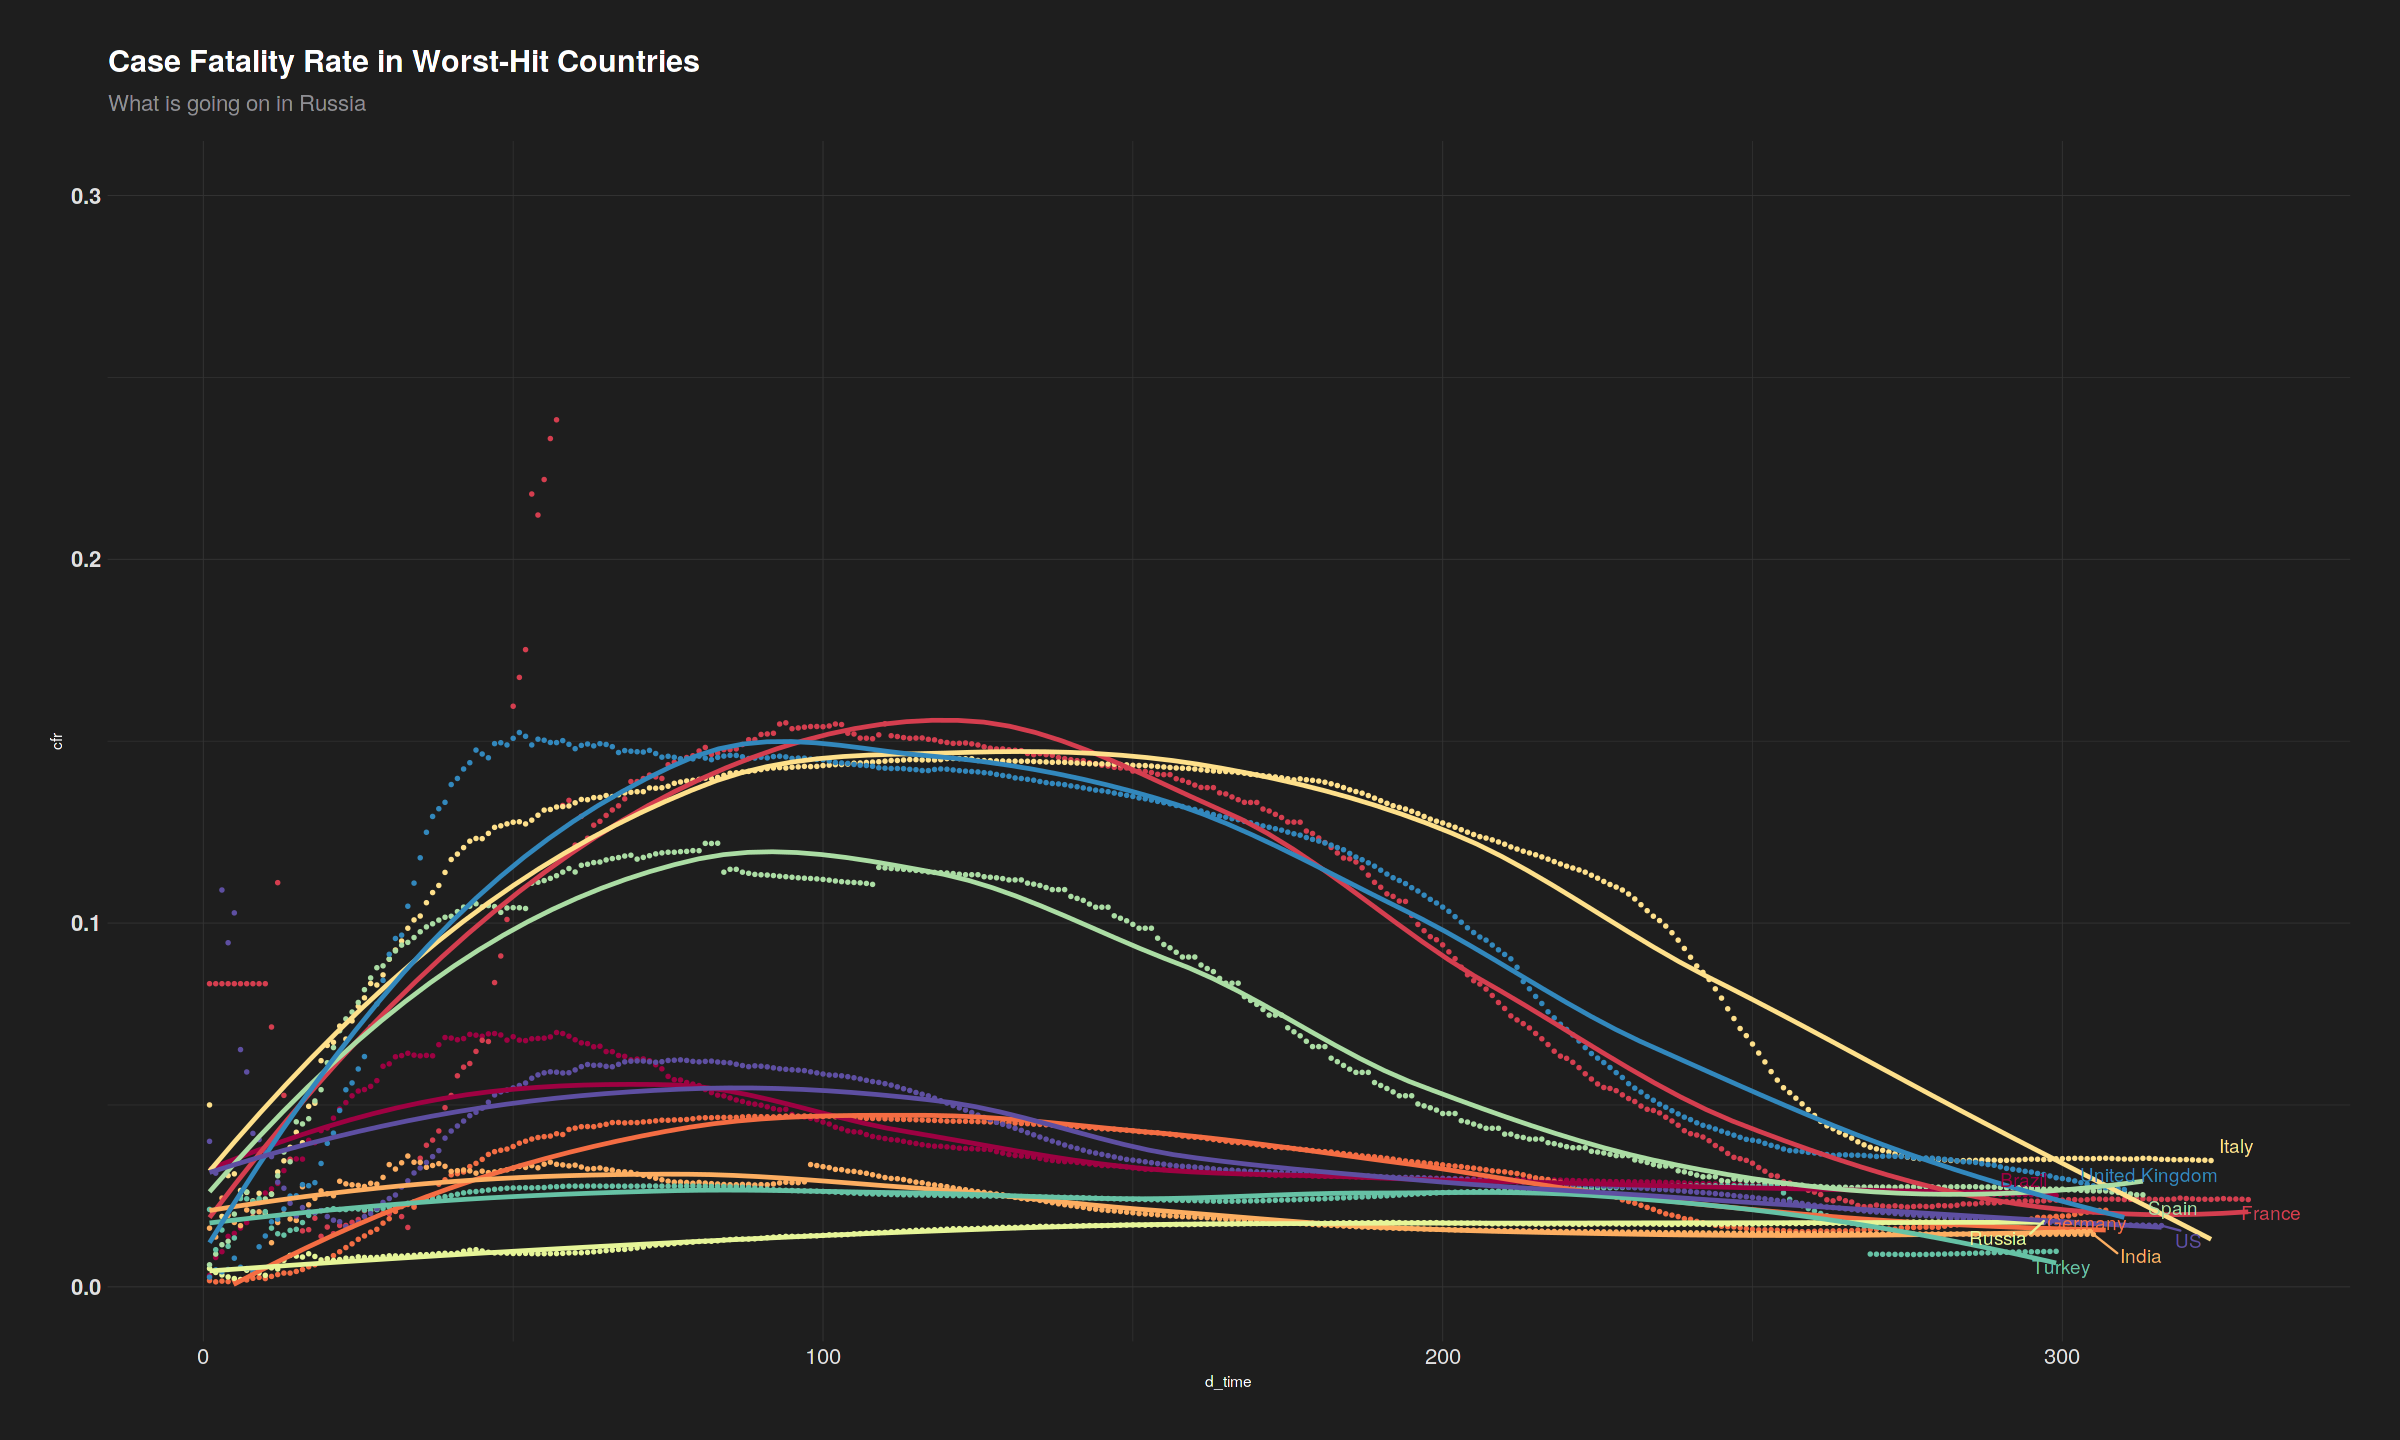

In [14]:
p3 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = cfr, group = Country_Region, colour = Country_Region)) + 
    geom_point(size = 0.5) + 
#     geom_line(aes(y = rm7_cfr)) + 
    geom_smooth(se = F) +
    ylim(c(0, 0.3)) +
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      na.rm = TRUE) +
    labs(title = 'Case Fatality Rate in Worst-Hit Countries', subtitle = "What is going on in Russia")
p3

## Shares

In [15]:
t10_subset[, denom_cases := sum(rm7_new_cases), by = date][, 
            denom_deaths := sum(rm7_new_deaths), by = date]
t10_subset[, newcase_share := rm7_new_cases / denom_cases][, 
            newdeath_share := rm7_new_deaths /denom_deaths]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 34 rows containing missing values (position_stack).”
Warning message:
“Removed 37 rows containing missing values (position_stack).”


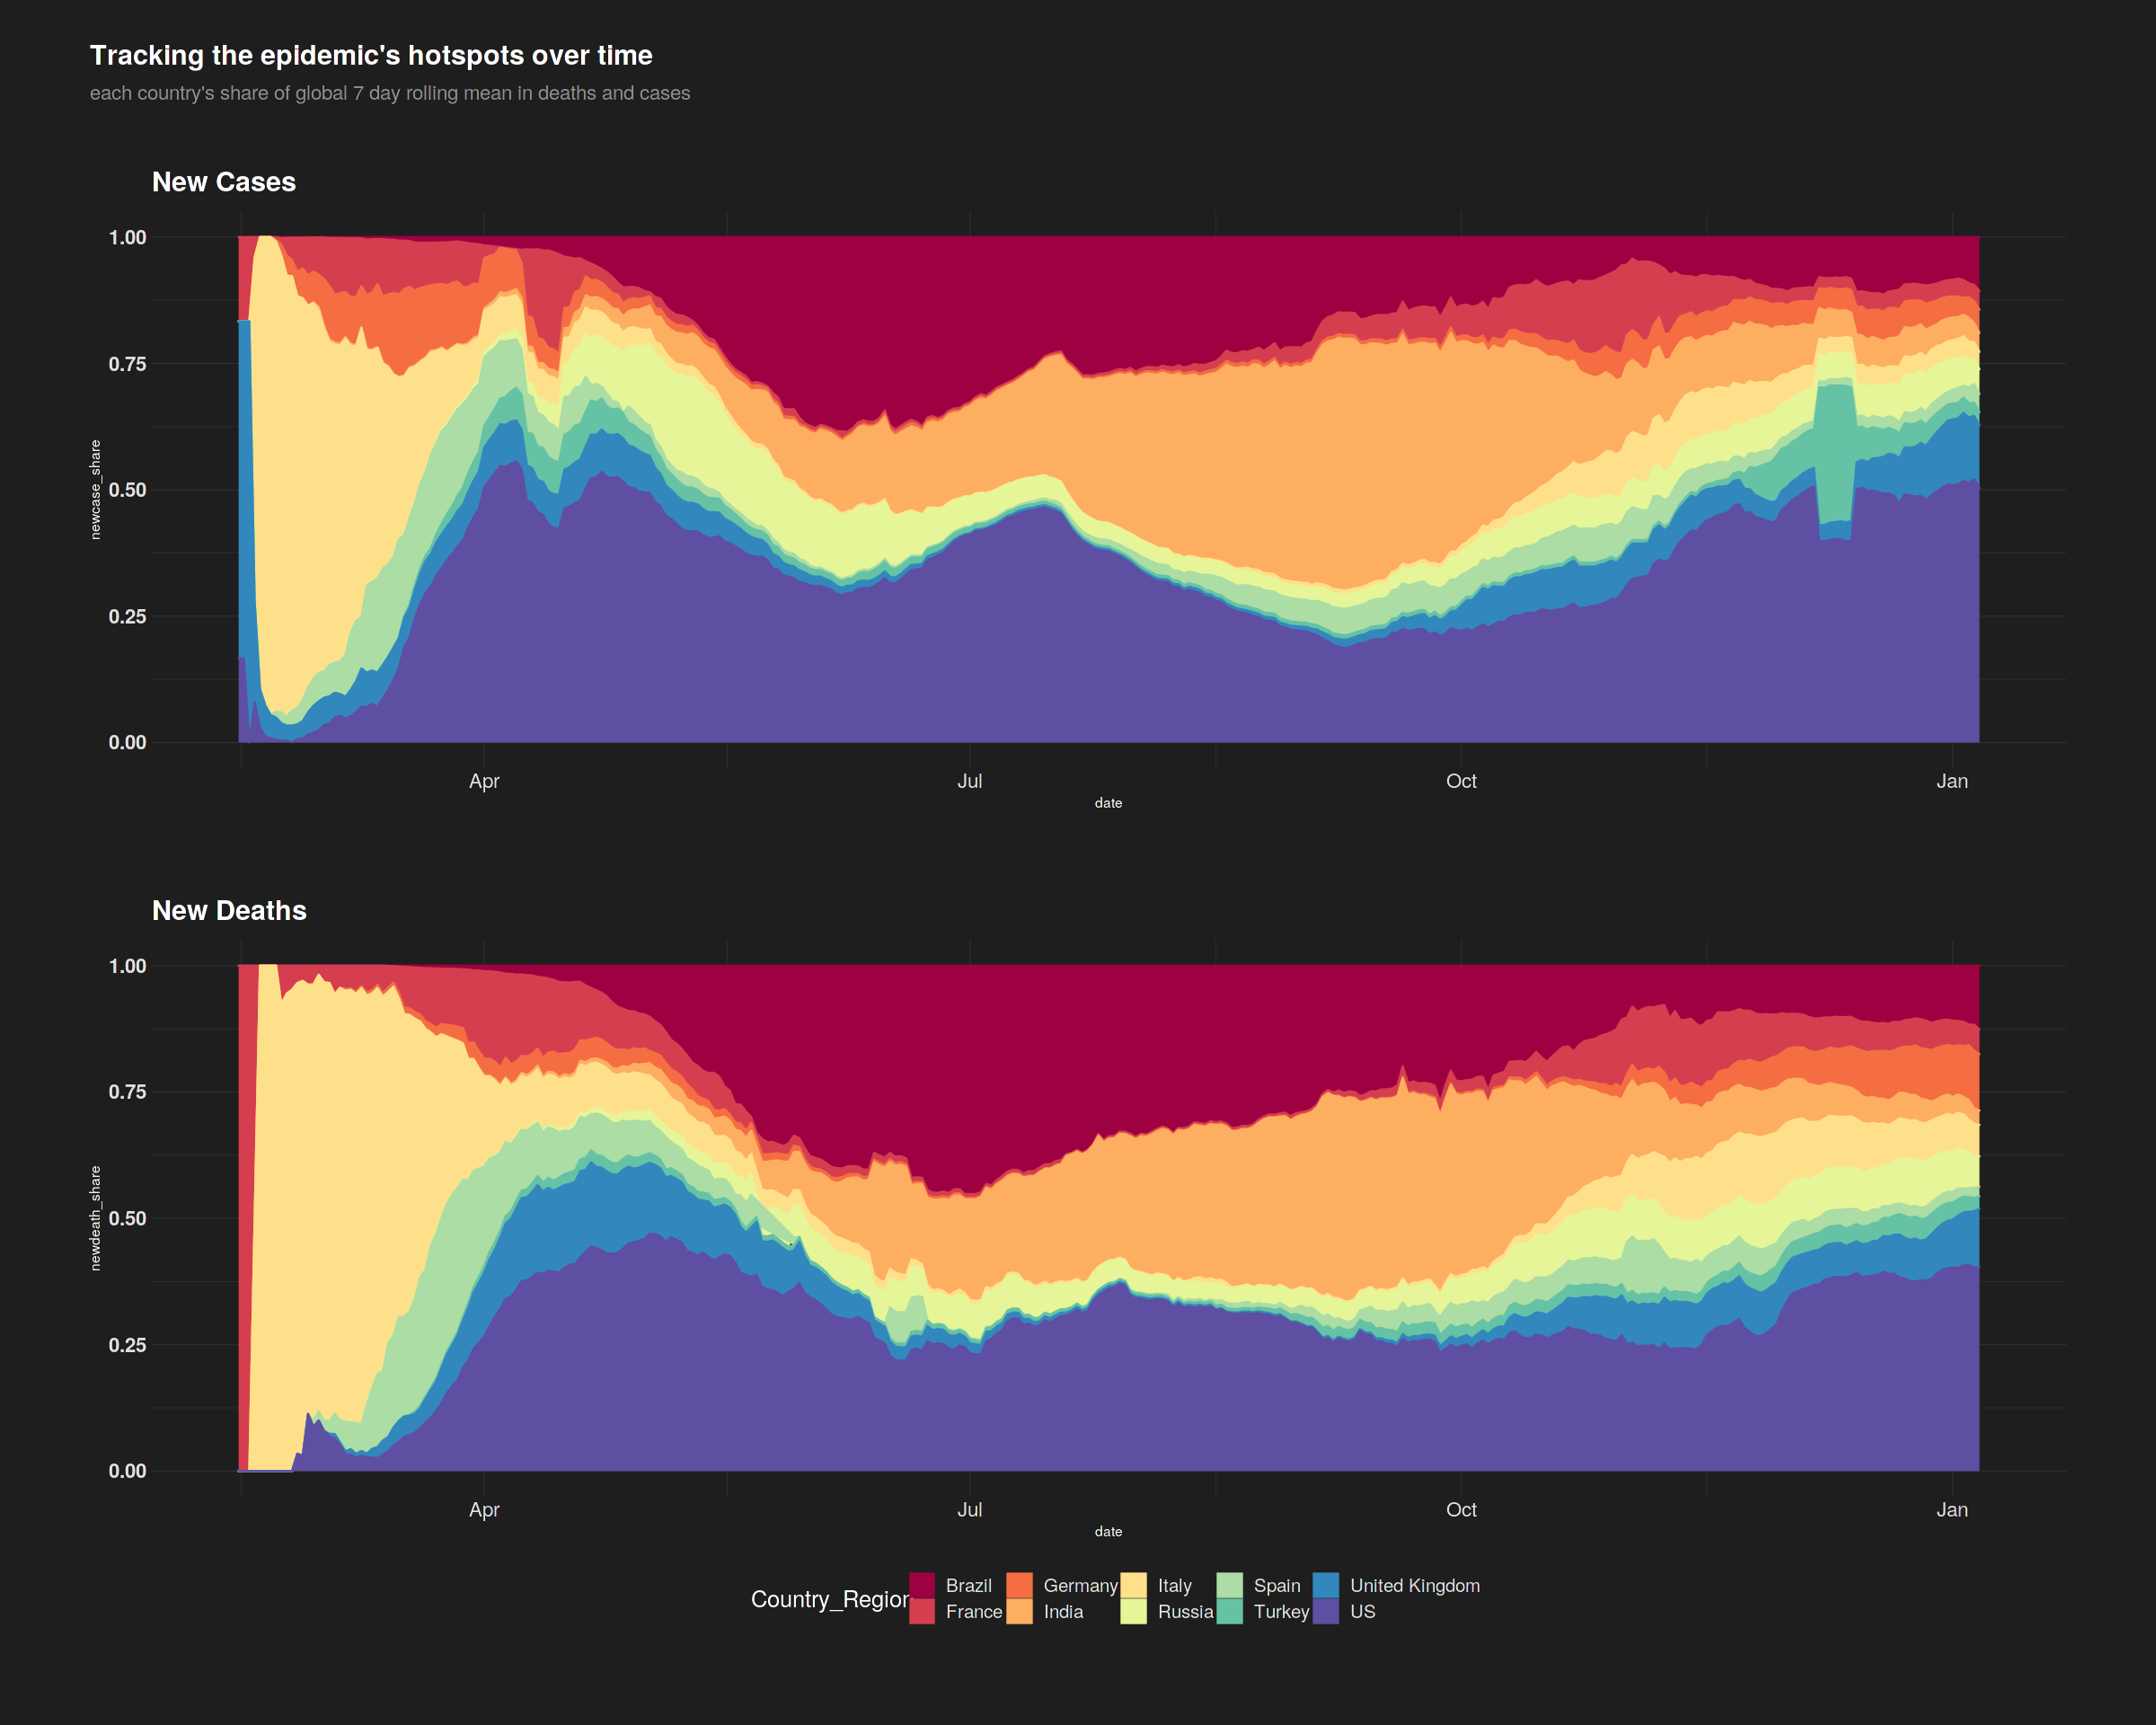

In [16]:
p1 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newcase_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases") + theme(legend.position = "None")
p2 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newdeath_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")

options(repr.plot.width = 20, repr.plot.height = 16)
(p = (p1 / p2 ) + plot_annotation(title = "Tracking the epidemic's hotspots over time", 
                                  subtitle = "each country's share of global 7 day rolling mean in deaths and cases"))

In [17]:
ggsave("carpet_plot_xc.png", p, width = 20, height = 16)

Warning message:
“Removed 34 rows containing missing values (position_stack).”
Warning message:
“Removed 37 rows containing missing values (position_stack).”


# OWID 

In [18]:
owid = fread("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid[, d := ymd(date)]
owid %>% glimpse

Rows: 58,948
Columns: 55
$ iso_code                           <chr> "AFG", "AFG", "AFG", "AFG", "AFG",…
$ continent                          <chr> "Asia", "Asia", "Asia", "Asia", "A…
$ location                           <chr> "Afghanistan", "Afghanistan", "Afg…
$ date                               <date> 2020-02-24, 2020-02-25, 2020-02-2…
$ total_cases                        <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4…
$ new_cases                          <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0…
$ new_cases_smoothed                 <dbl> NA, NA, NA, NA, NA, 0.143, 0.143, …
$ total_deaths                       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ new_deaths                         <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ new_deaths_smoothed                <dbl> NA, NA, NA, NA, NA, 0, 0, 0, 0, 0,…
$ total_cases_per_million            <dbl> 0.026, 0.026, 0.026, 0.026, 0.026,…
$ new_cases_per_million              <dbl> 0.026, 0.000, 0.000, 0.000, 0.000,…
$ new_cases_smoothed_per_mi

In [19]:
fwrite(owid, "data/owid_covid.csv")

In [20]:
all_countries_xs = owid[location!="World"][
    order(-d)][
    , .SD[1], by = .(iso_code)]
(t10 = all_countries_xs[order(-total_cases)][1:10])
#  [order(-total_cases)][1:10])

iso_code continent     location       date       total_cases new_cases
1  USA      North America United States  2021-01-08 21862773    283204   
2  IND      Asia          India          2021-01-08 10413417         0   
3  BRA      South America Brazil         2021-01-08  8013708     52035   
4  RUS      Europe        Russia         2021-01-08  3321163     23330   
5  GBR      Europe        United Kingdom 2021-01-08  2966244     68192   
6  FRA      Europe        France         2021-01-08  2804743     41373   
7  TUR      Asia          Turkey         2021-01-08  2307581     11479   
8  ESP      Europe        Spain          2021-01-08  2050360     25456   
9  DEU      Europe        Germany        2021-01-08  1905638     19077   
10 COL      South America Colombia       2021-01-08  1755568     18221   
   new_cases_smoothed total_deaths new_deaths new_deaths_smoothed ⋯
1  247246             368773       3456       2982.7              ⋯
2   18101             150570          0        225.1              ⋯
3   44733             201460        962        864.1              ⋯
4   23886              60067        439        467.0              ⋯
5   59508              79965       1333        818.3              ⋯
6   15390              67566        866        382.0              ⋯
7   12389              22450        186        193.9              ⋯
8   17442              51874        199        148.1              ⋯
9   20429              40022       1035        839.6              ⋯
10  14384              45431        364        276.6              ⋯
   extreme_poverty cardiovasc_death_rate diabetes_prevalence female_smokers
1   1.2            151.09                10.79               19.1          
2  21.2            282.28                10.39                1.9          
3   3.4            177.96                 8.11               10.1          
4   0.1            431.30                 6.18               23.4          
5   0.2            122.14                 4.28               20.0          
6    NA             86.06                 4.77               30.1          
7   0.2            171.28                12.13               14.1          
8   1.0             99.40                 7.17               27.4          
9    NA            156.14                 8.31               28.2          
10  4.5            124.24                 7.44                4.7          
   male_smokers handwashing_facilities hospital_beds_per_thousand
1  24.6            NA                  2.77                      
2  20.6         59.55                  0.53                      
3  17.9            NA                  2.20                      
4  58.3            NA                  8.05                      
5  24.7            NA                  2.54                      
6  35.6            NA                  5.98                      
7  41.1            NA                  2.81                      
8  31.4            NA                  2.97                      
9  33.1            NA                  8.00                      
10 13.5         65.39                  1.71                      
   life_expectancy human_development_index d         
1  78.86           0.924                   2021-01-08
2  69.66           0.640                   2021-01-08
3  75.88           0.759                   2021-01-08
4  72.58           0.816                   2021-01-08
5  81.32           0.922                   2021-01-08
6  82.66           0.901                   2021-01-08
7  77.69           0.791                   2021-01-08
8  83.56           0.891                   2021-01-08
9  81.33           0.936                   2021-01-08
10 77.29           0.747                   2021-01-08

In [21]:
owid_t10_subset = owid[location %in% t10$location]

vars = c('new_cases', 'new_deaths', 'new_tests')
owid_t10_subset[, paste0('denom_', vars):= lapply(.SD, sum), by = date, .SDcols = vars]

owid_t10_subset[, `:=`(
            newcase_share  = new_cases / denom_new_cases,
            newdeath_share = new_deaths / denom_new_deaths,
            newtest_share  = new_tests / denom_new_tests
    )][ newcase_share < 0, newcase_share := 0]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 31 rows containing missing values (position_stack).”
Warning message:
“Removed 325 rows containing missing values (position_stack).”


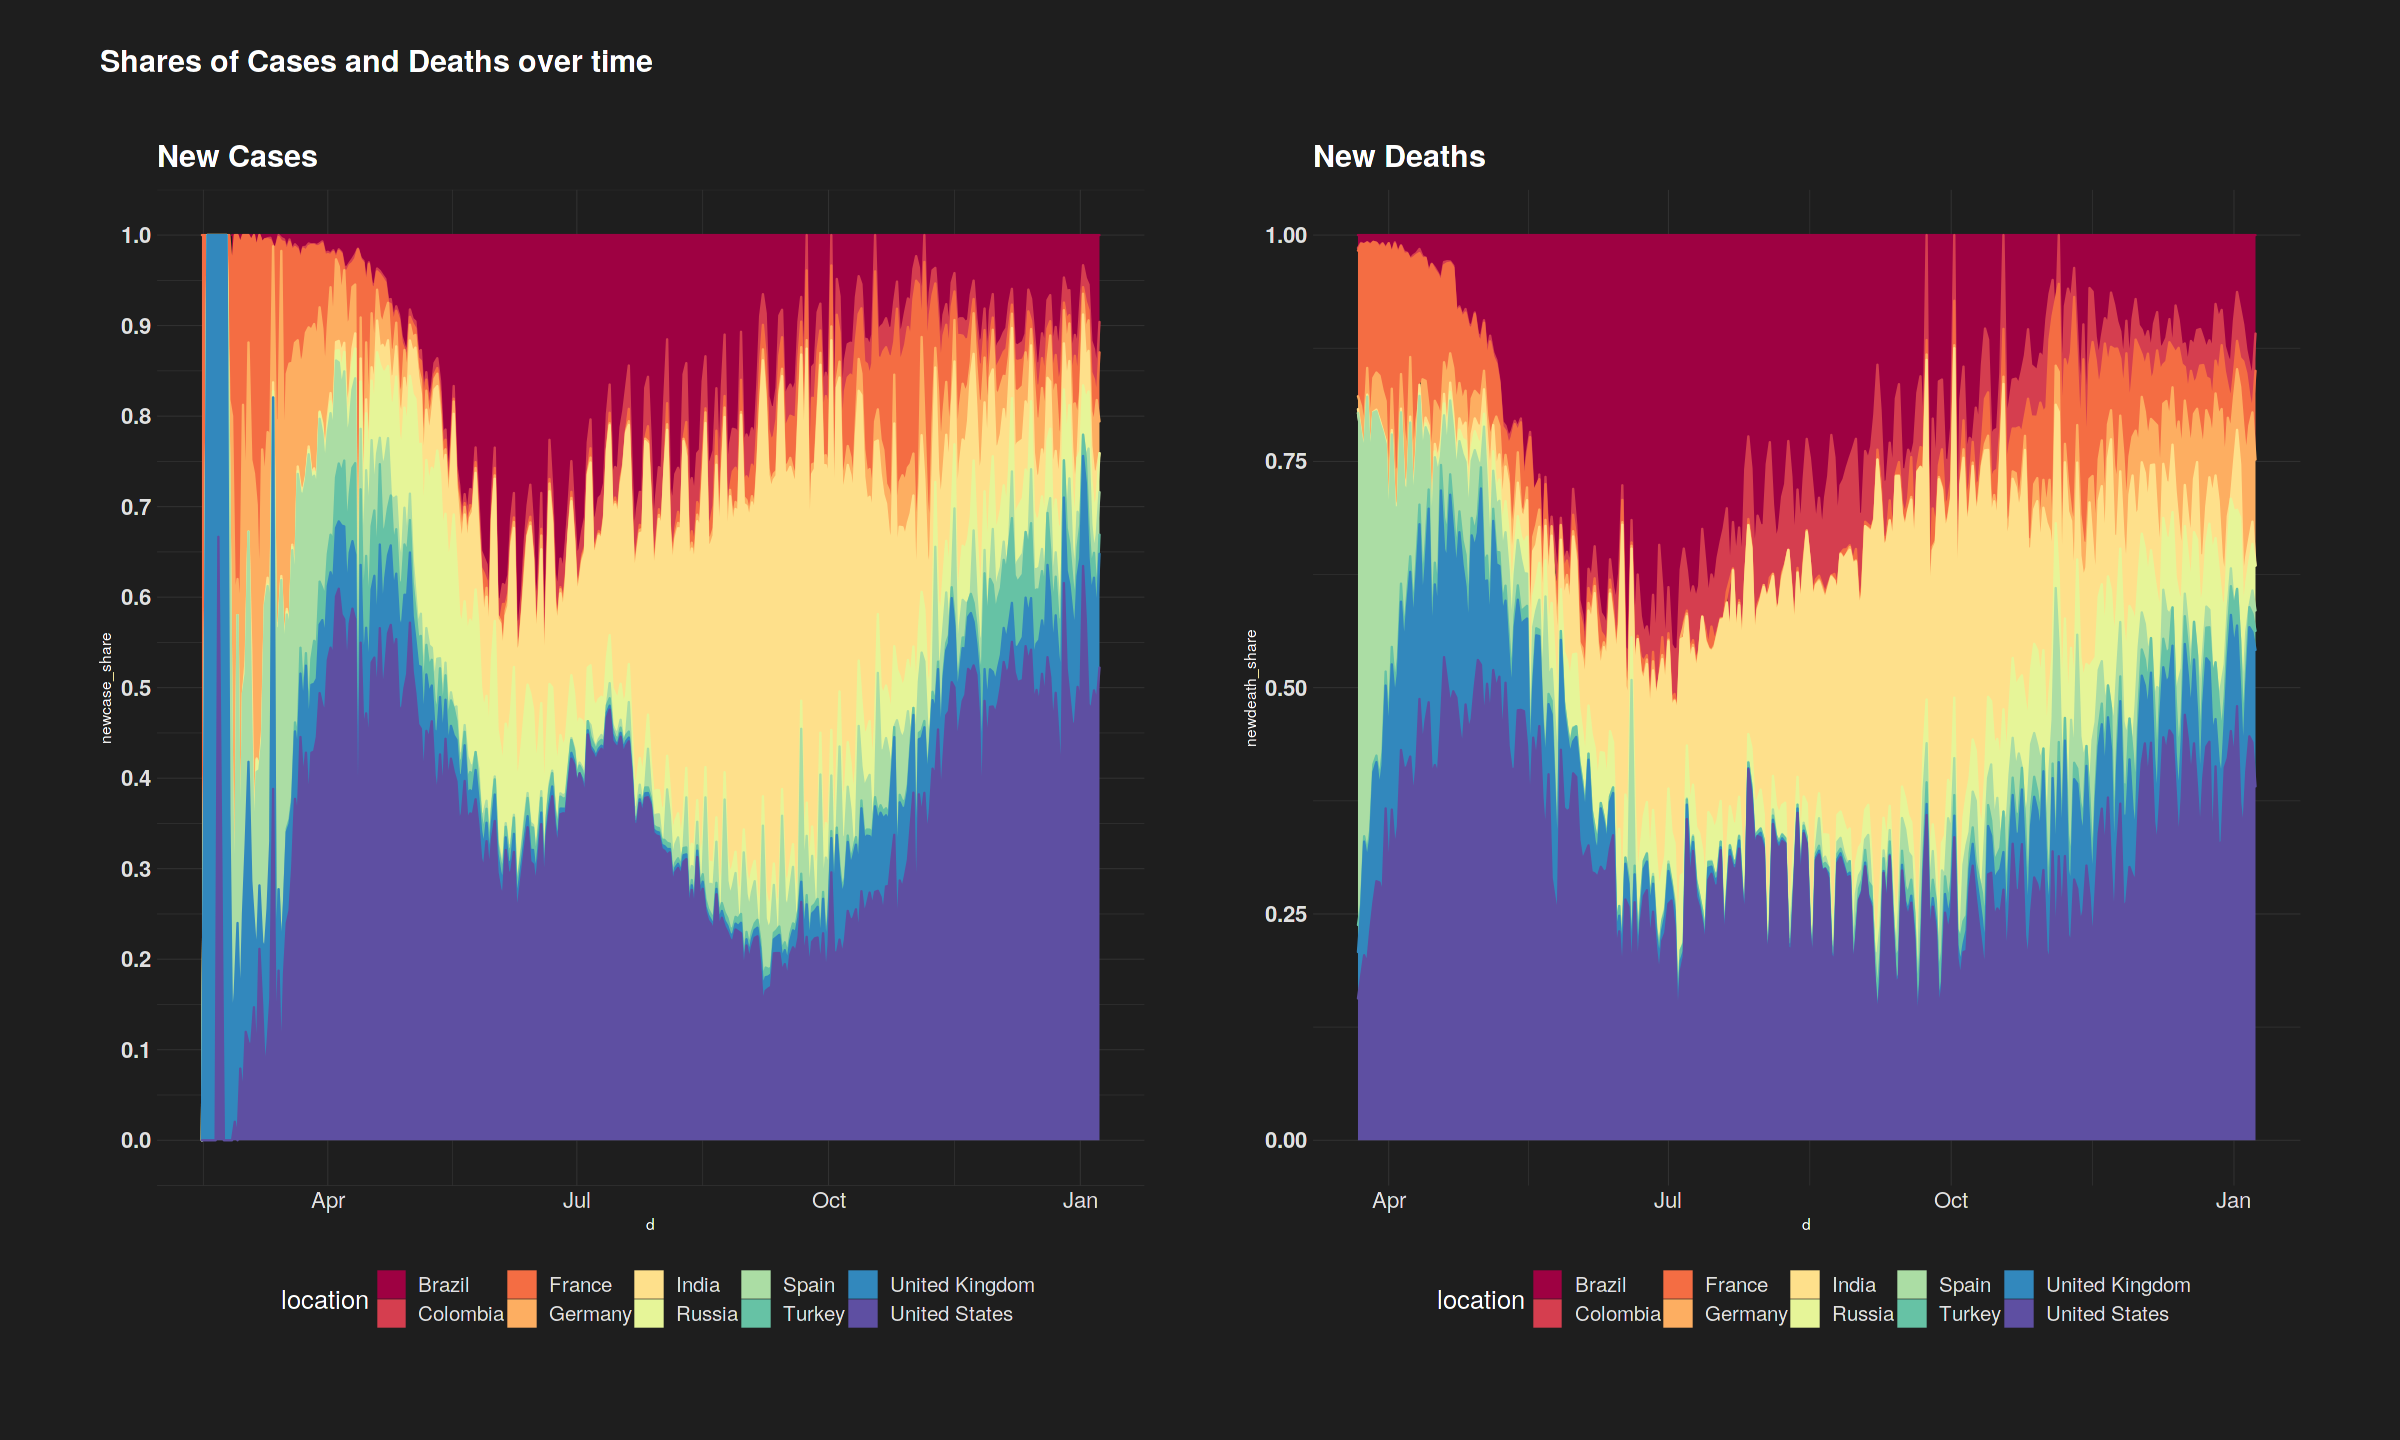

In [22]:
p1 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newcase_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newdeath_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") + ylim(c(0, 1)) +
    ggtitle("New Deaths")
options(repr.plot.width = 20, repr.plot.height = 12)
(p1 | p2 ) + plot_annotation(title = "Shares of Cases and Deaths over time")

## Country Profiles 

In [23]:
country_plot = function(country){
    npl = owid[location == country][order(-date)]
    p1 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_cases)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ylim(c(0, NA)) + 
        ggtitle('Total Cases') 
    
    p2 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_cases)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
         ylim(c(0, NA)) + 
        ggtitle('New Cases')
    
    p3 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_deaths)) +
        ylim(c(0, NA)) + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Deaths')
    
    p4 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
         ylim(c(0, NA)) + 
        ggtitle('New Deaths')

    p5 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_tests)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
         ylim(c(0, NA)) + 
        ggtitle('Total Tests')

    p6 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_tests)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ylim(c(0, NA)) + 
        ggtitle('New Tests')
    suppressMessages(suppressWarnings(print(
        (p5 | p6) / (p1 | p2) / (p3 | p4) + plot_annotation(title = paste0("Covid Profile : ", country))
    )))
}

## South Asia

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



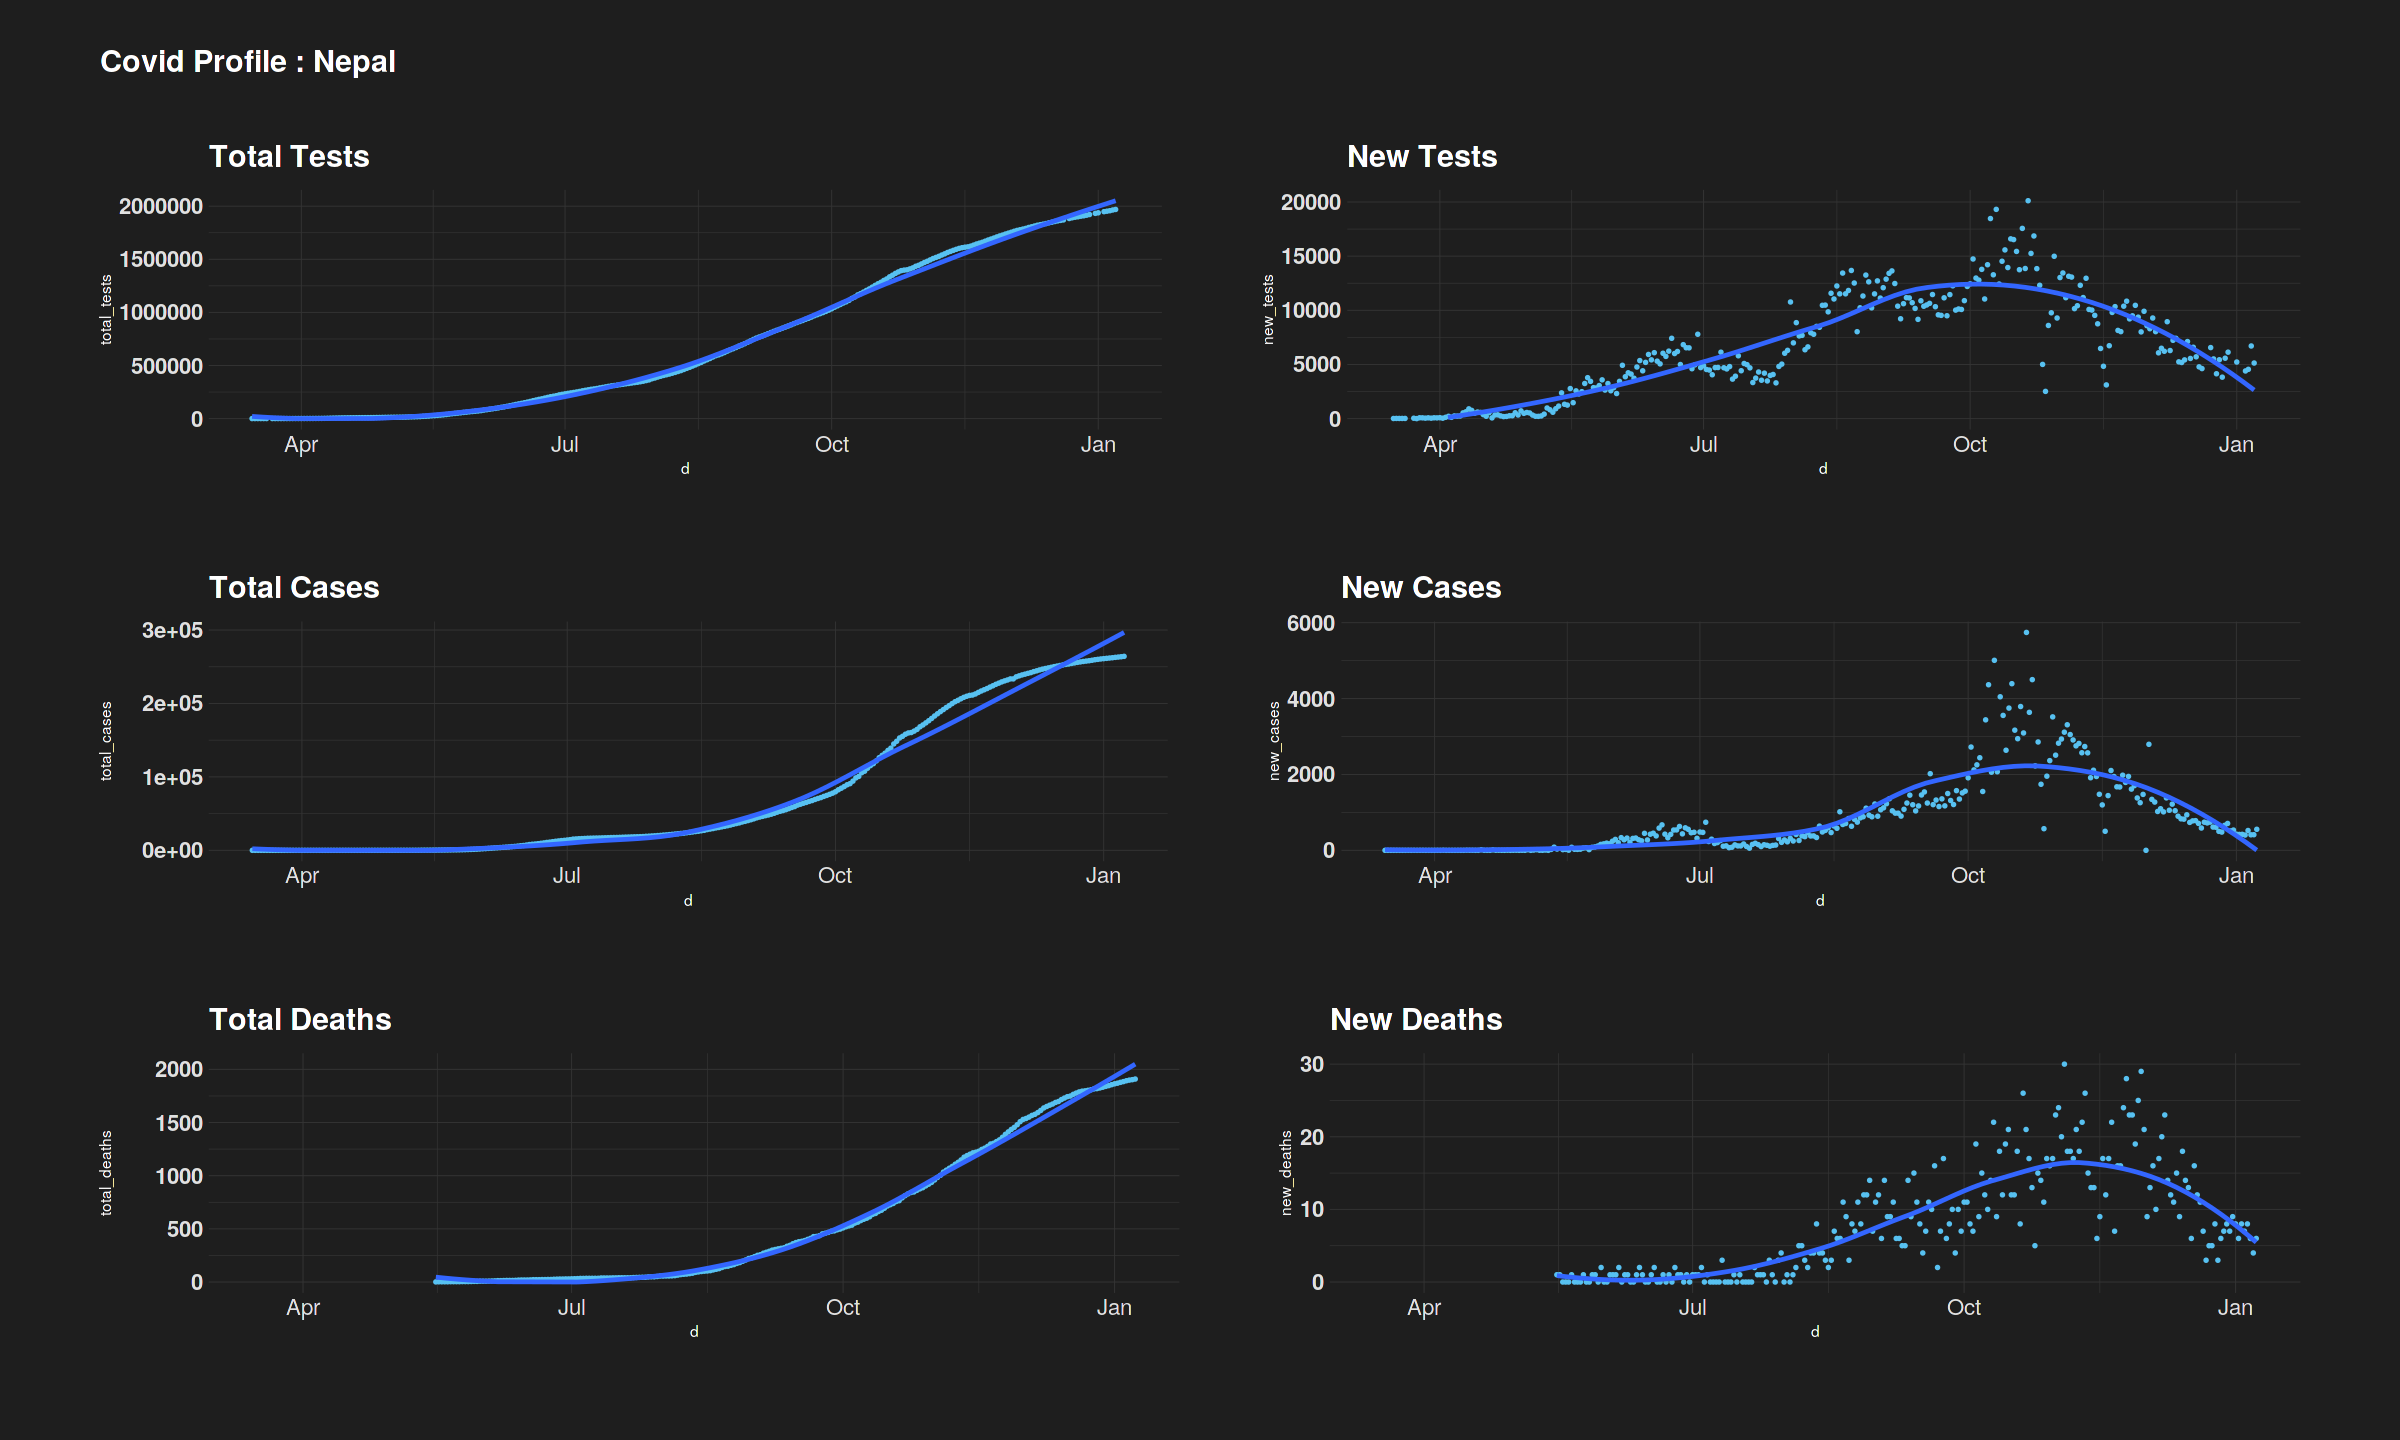

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



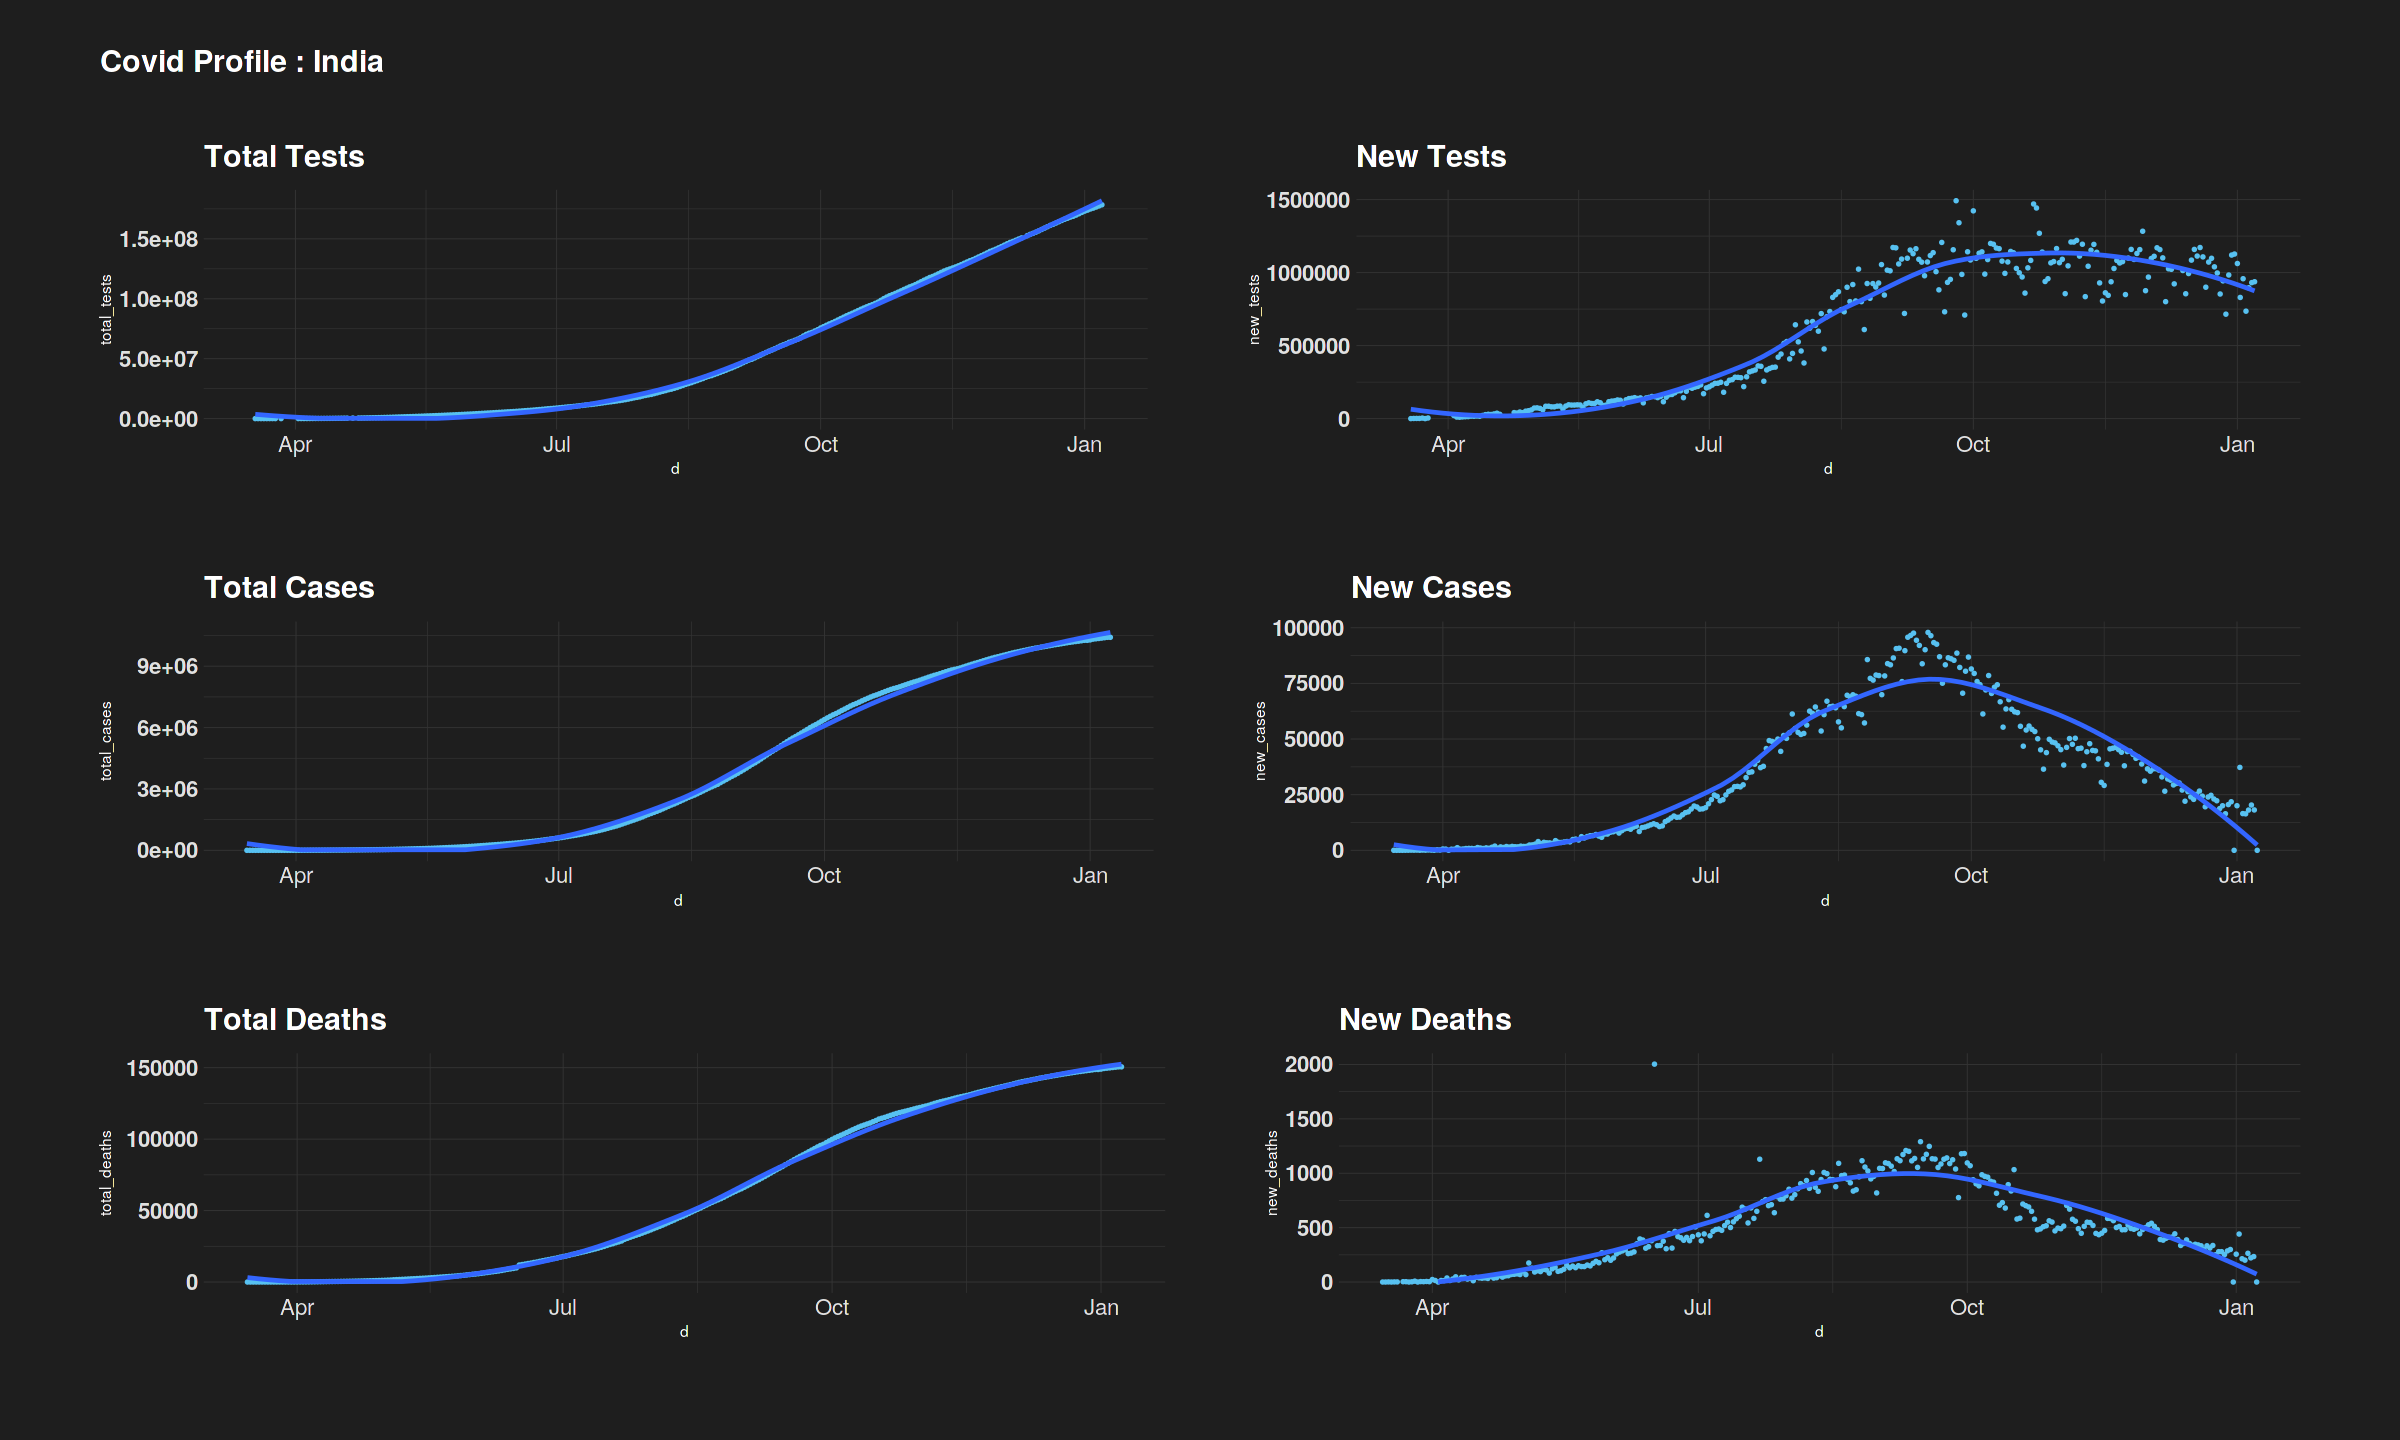

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



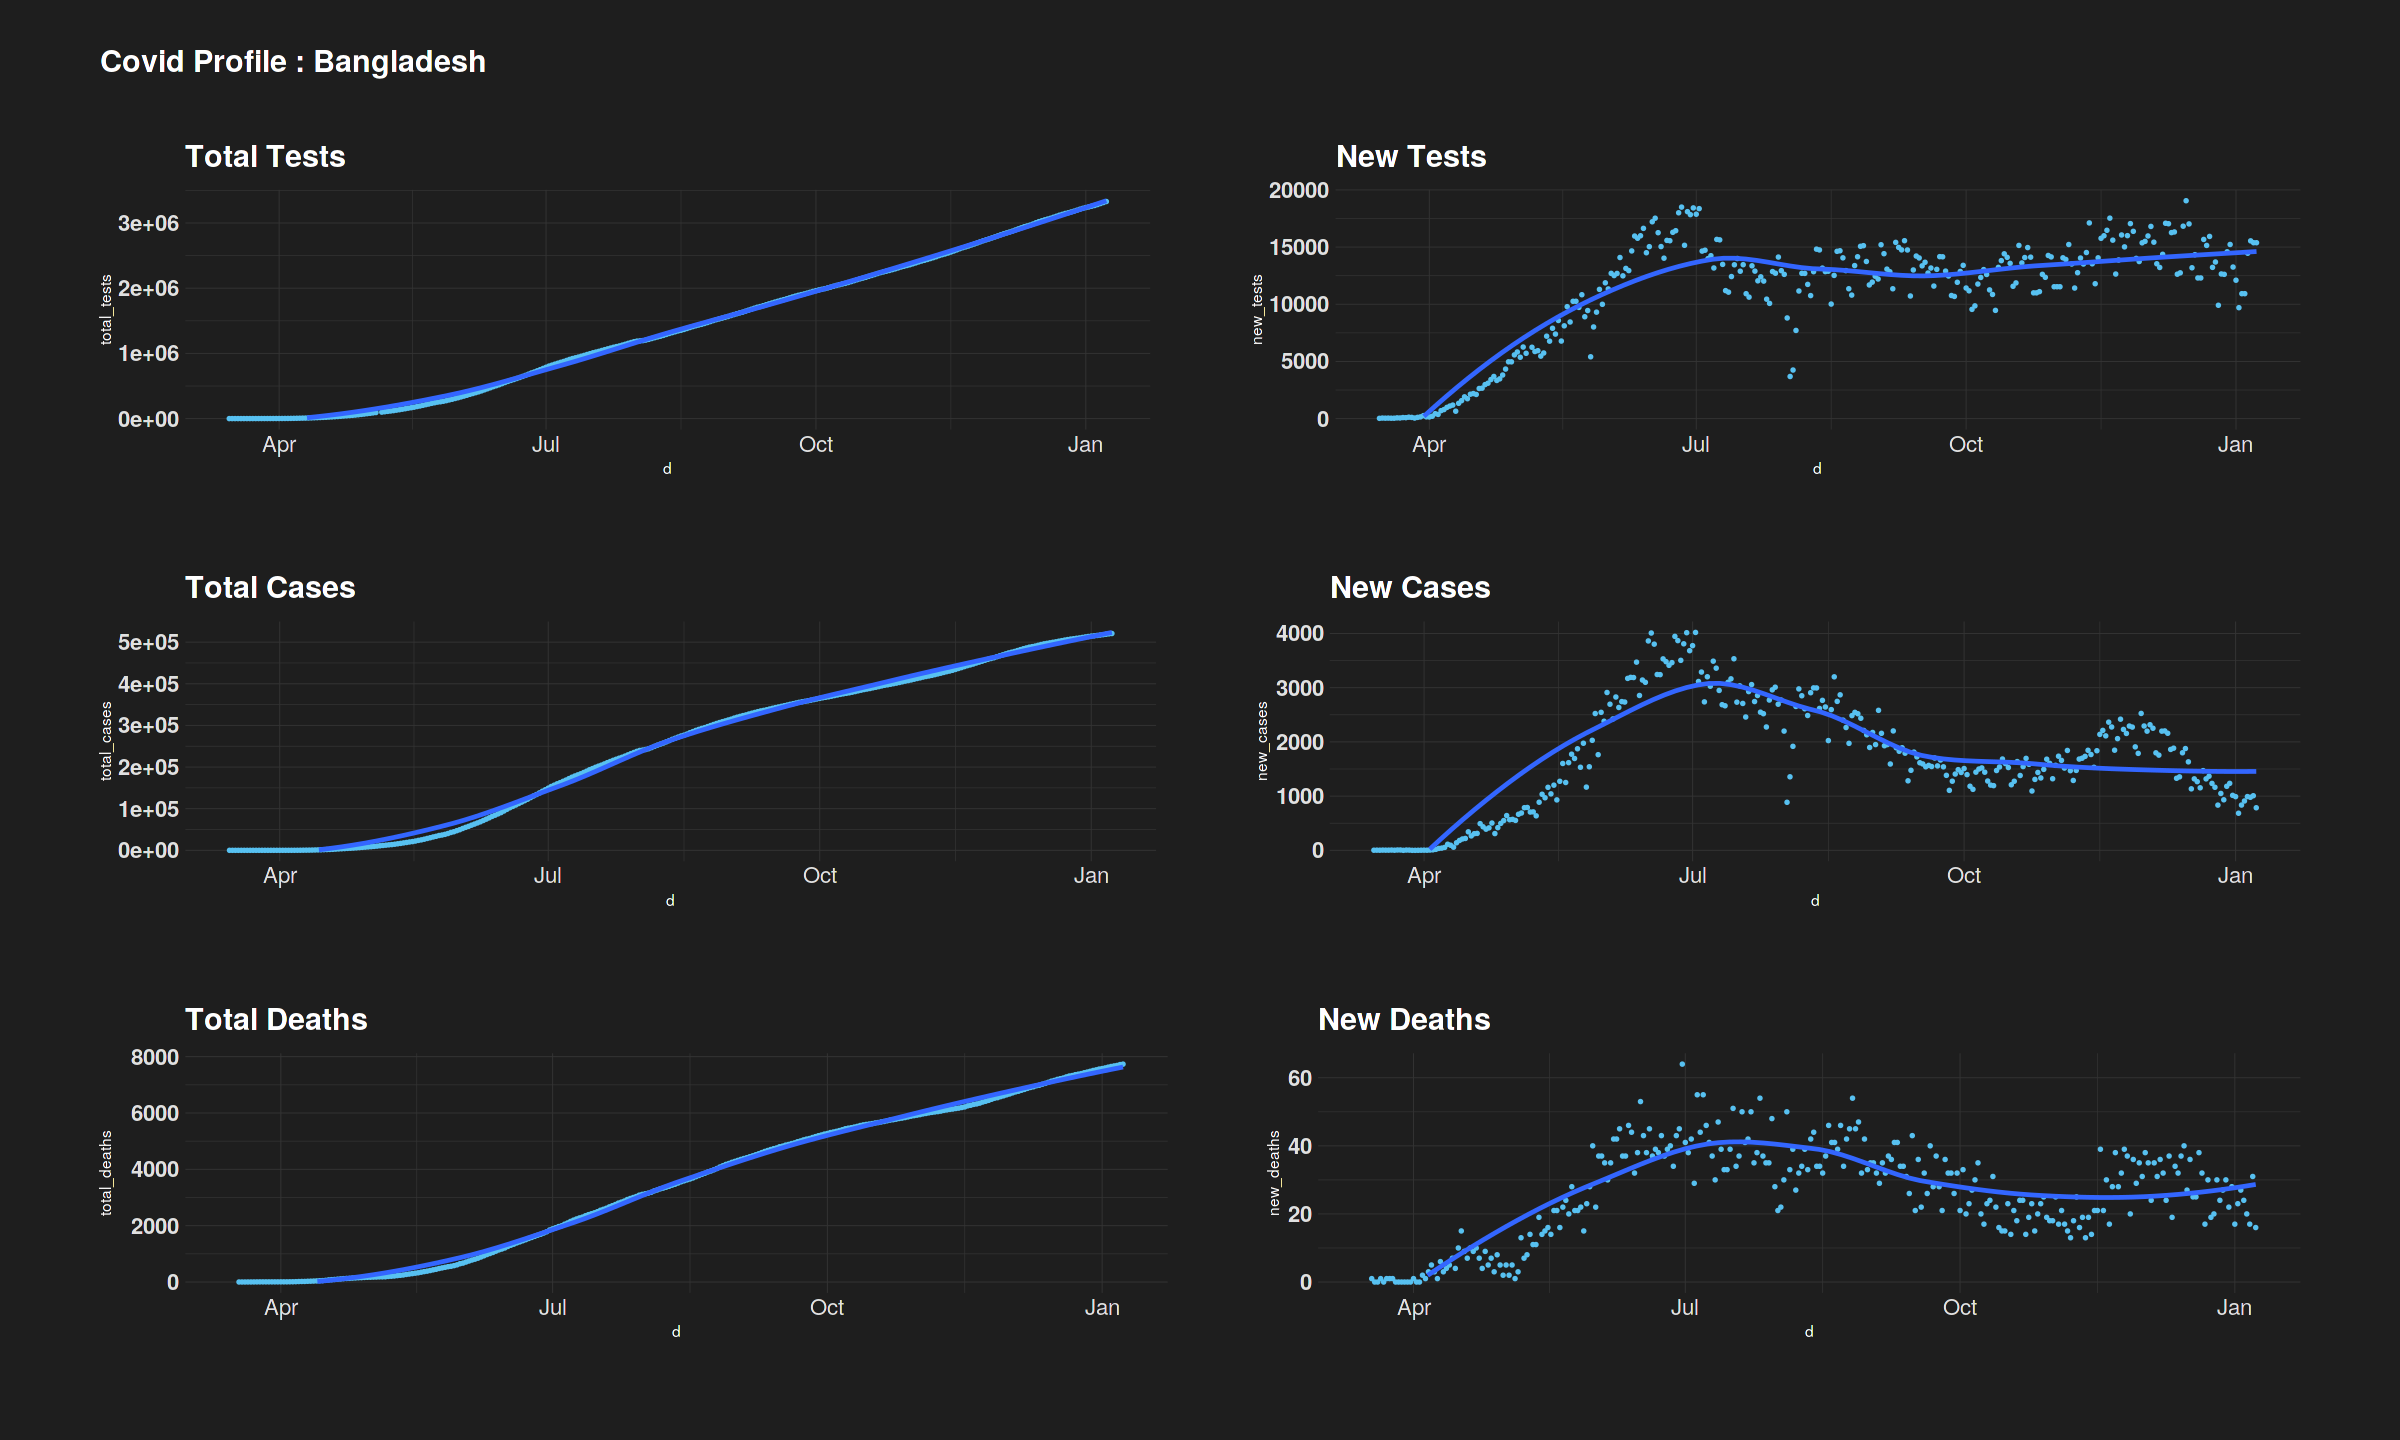

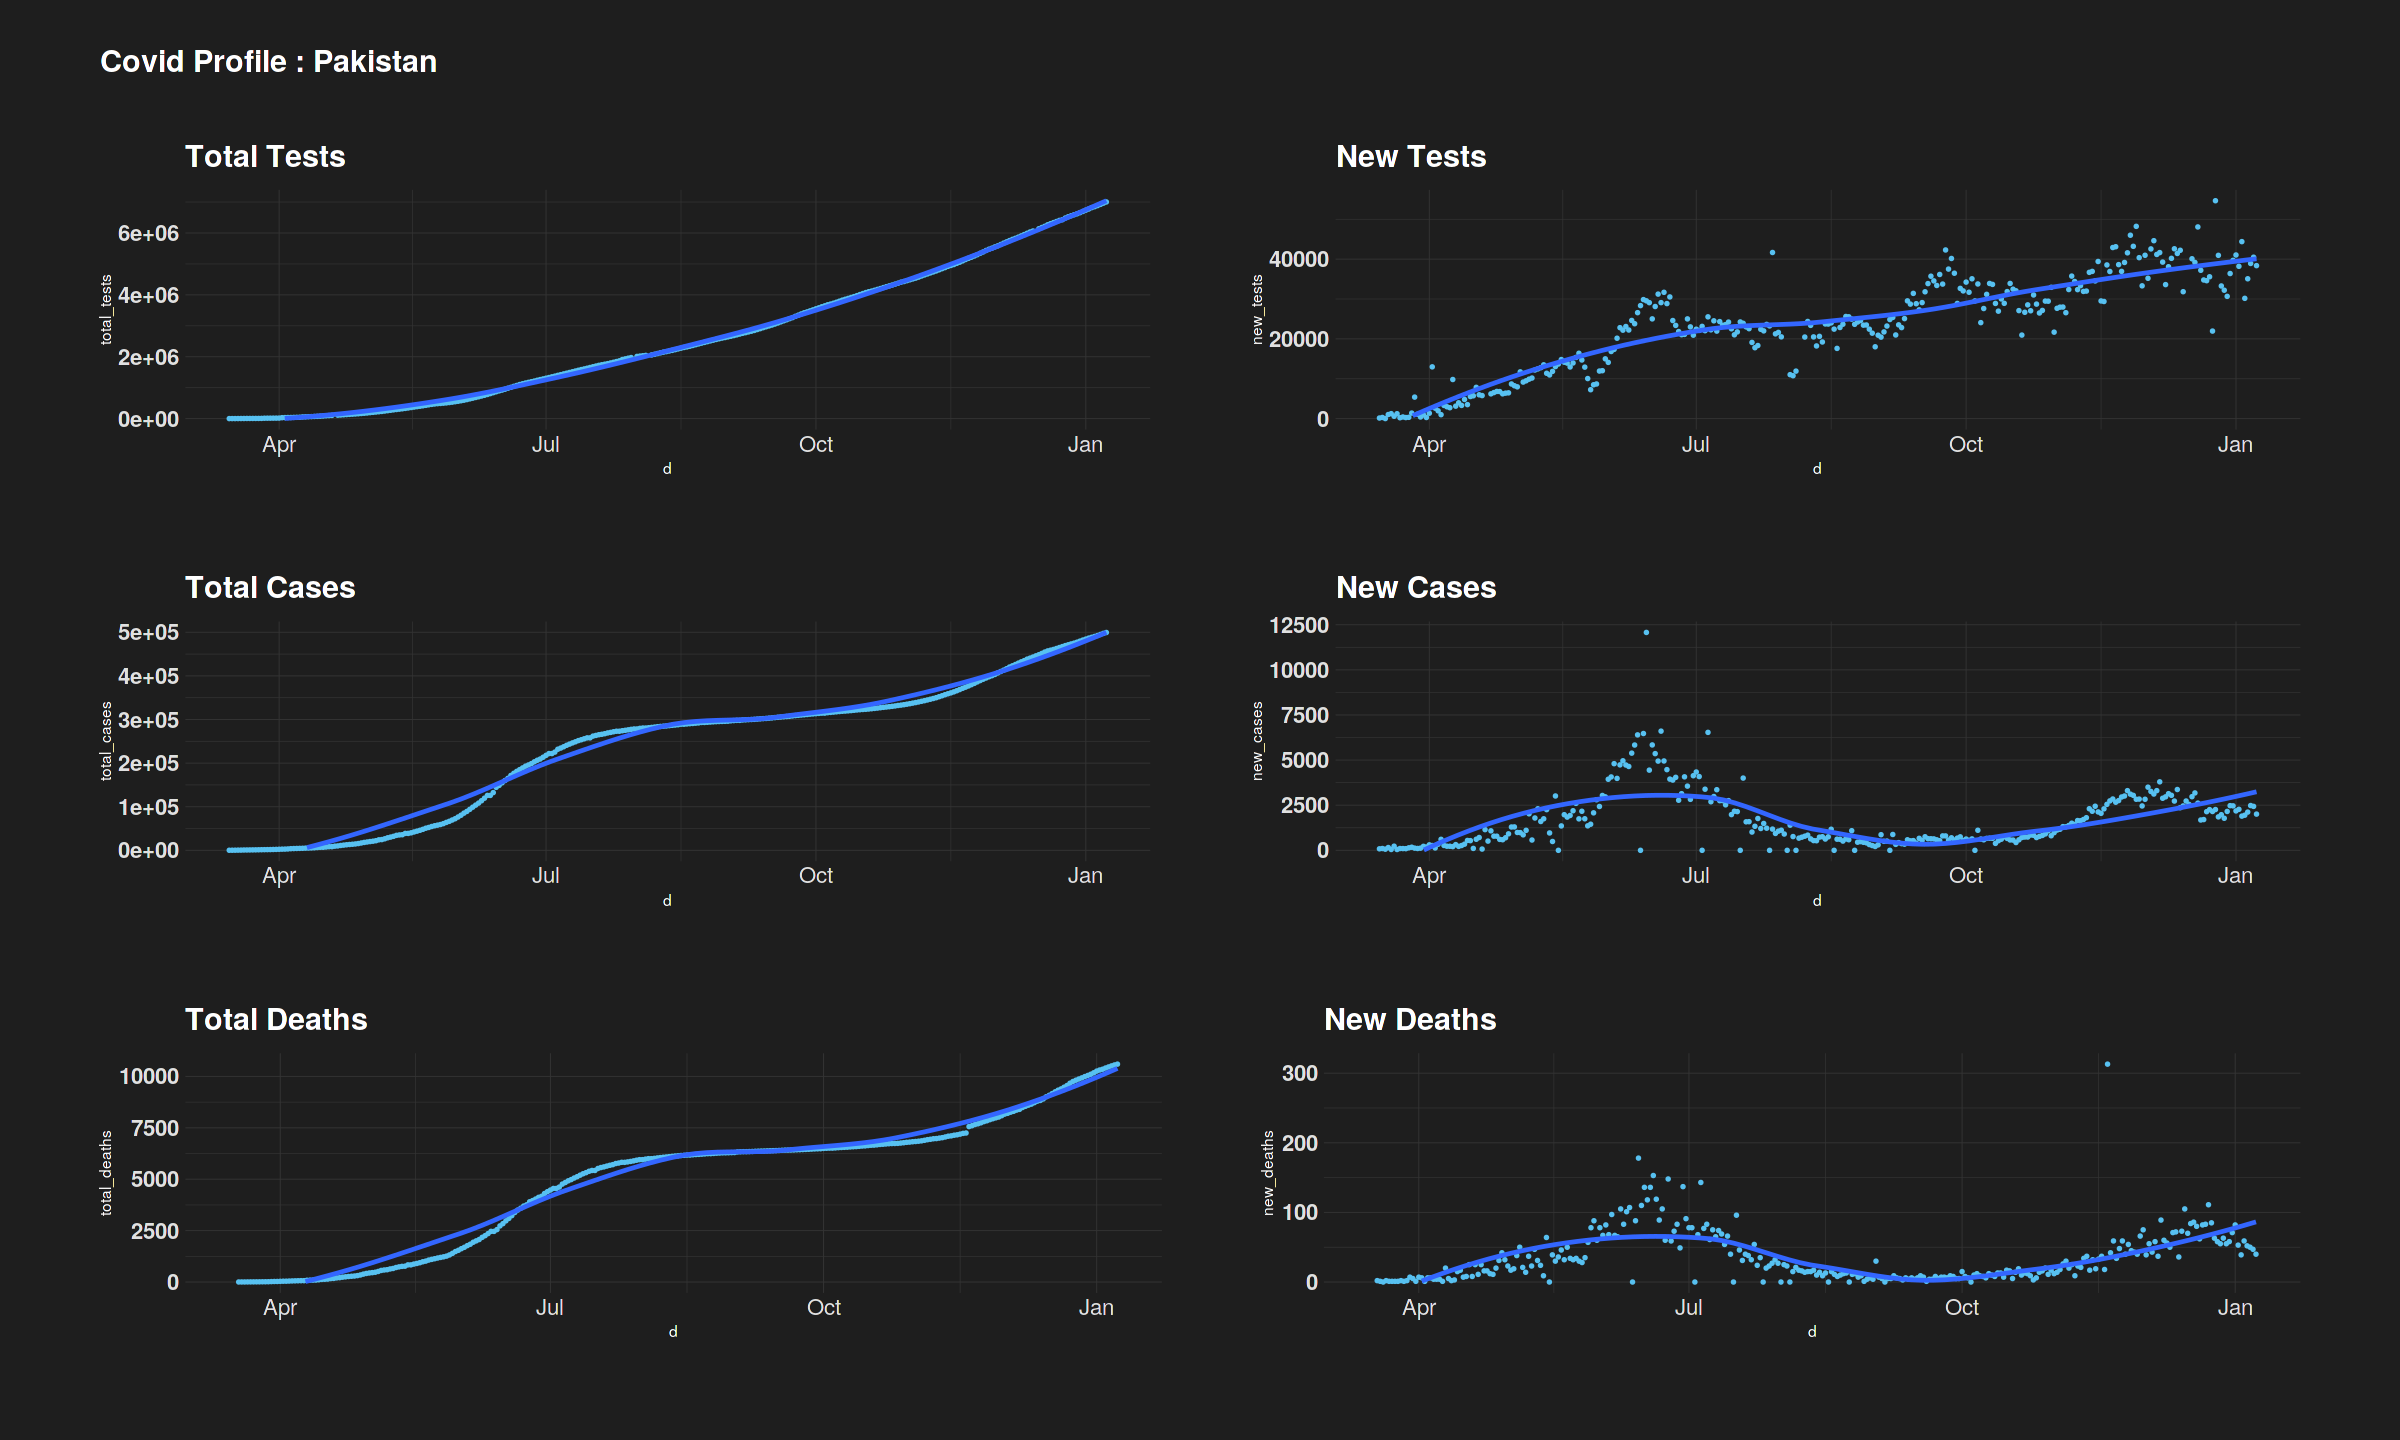

In [24]:
country_plot("Nepal") 
country_plot("India")
country_plot("Bangladesh")
country_plot("Pakistan")

## Sub-Saharan Africa

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



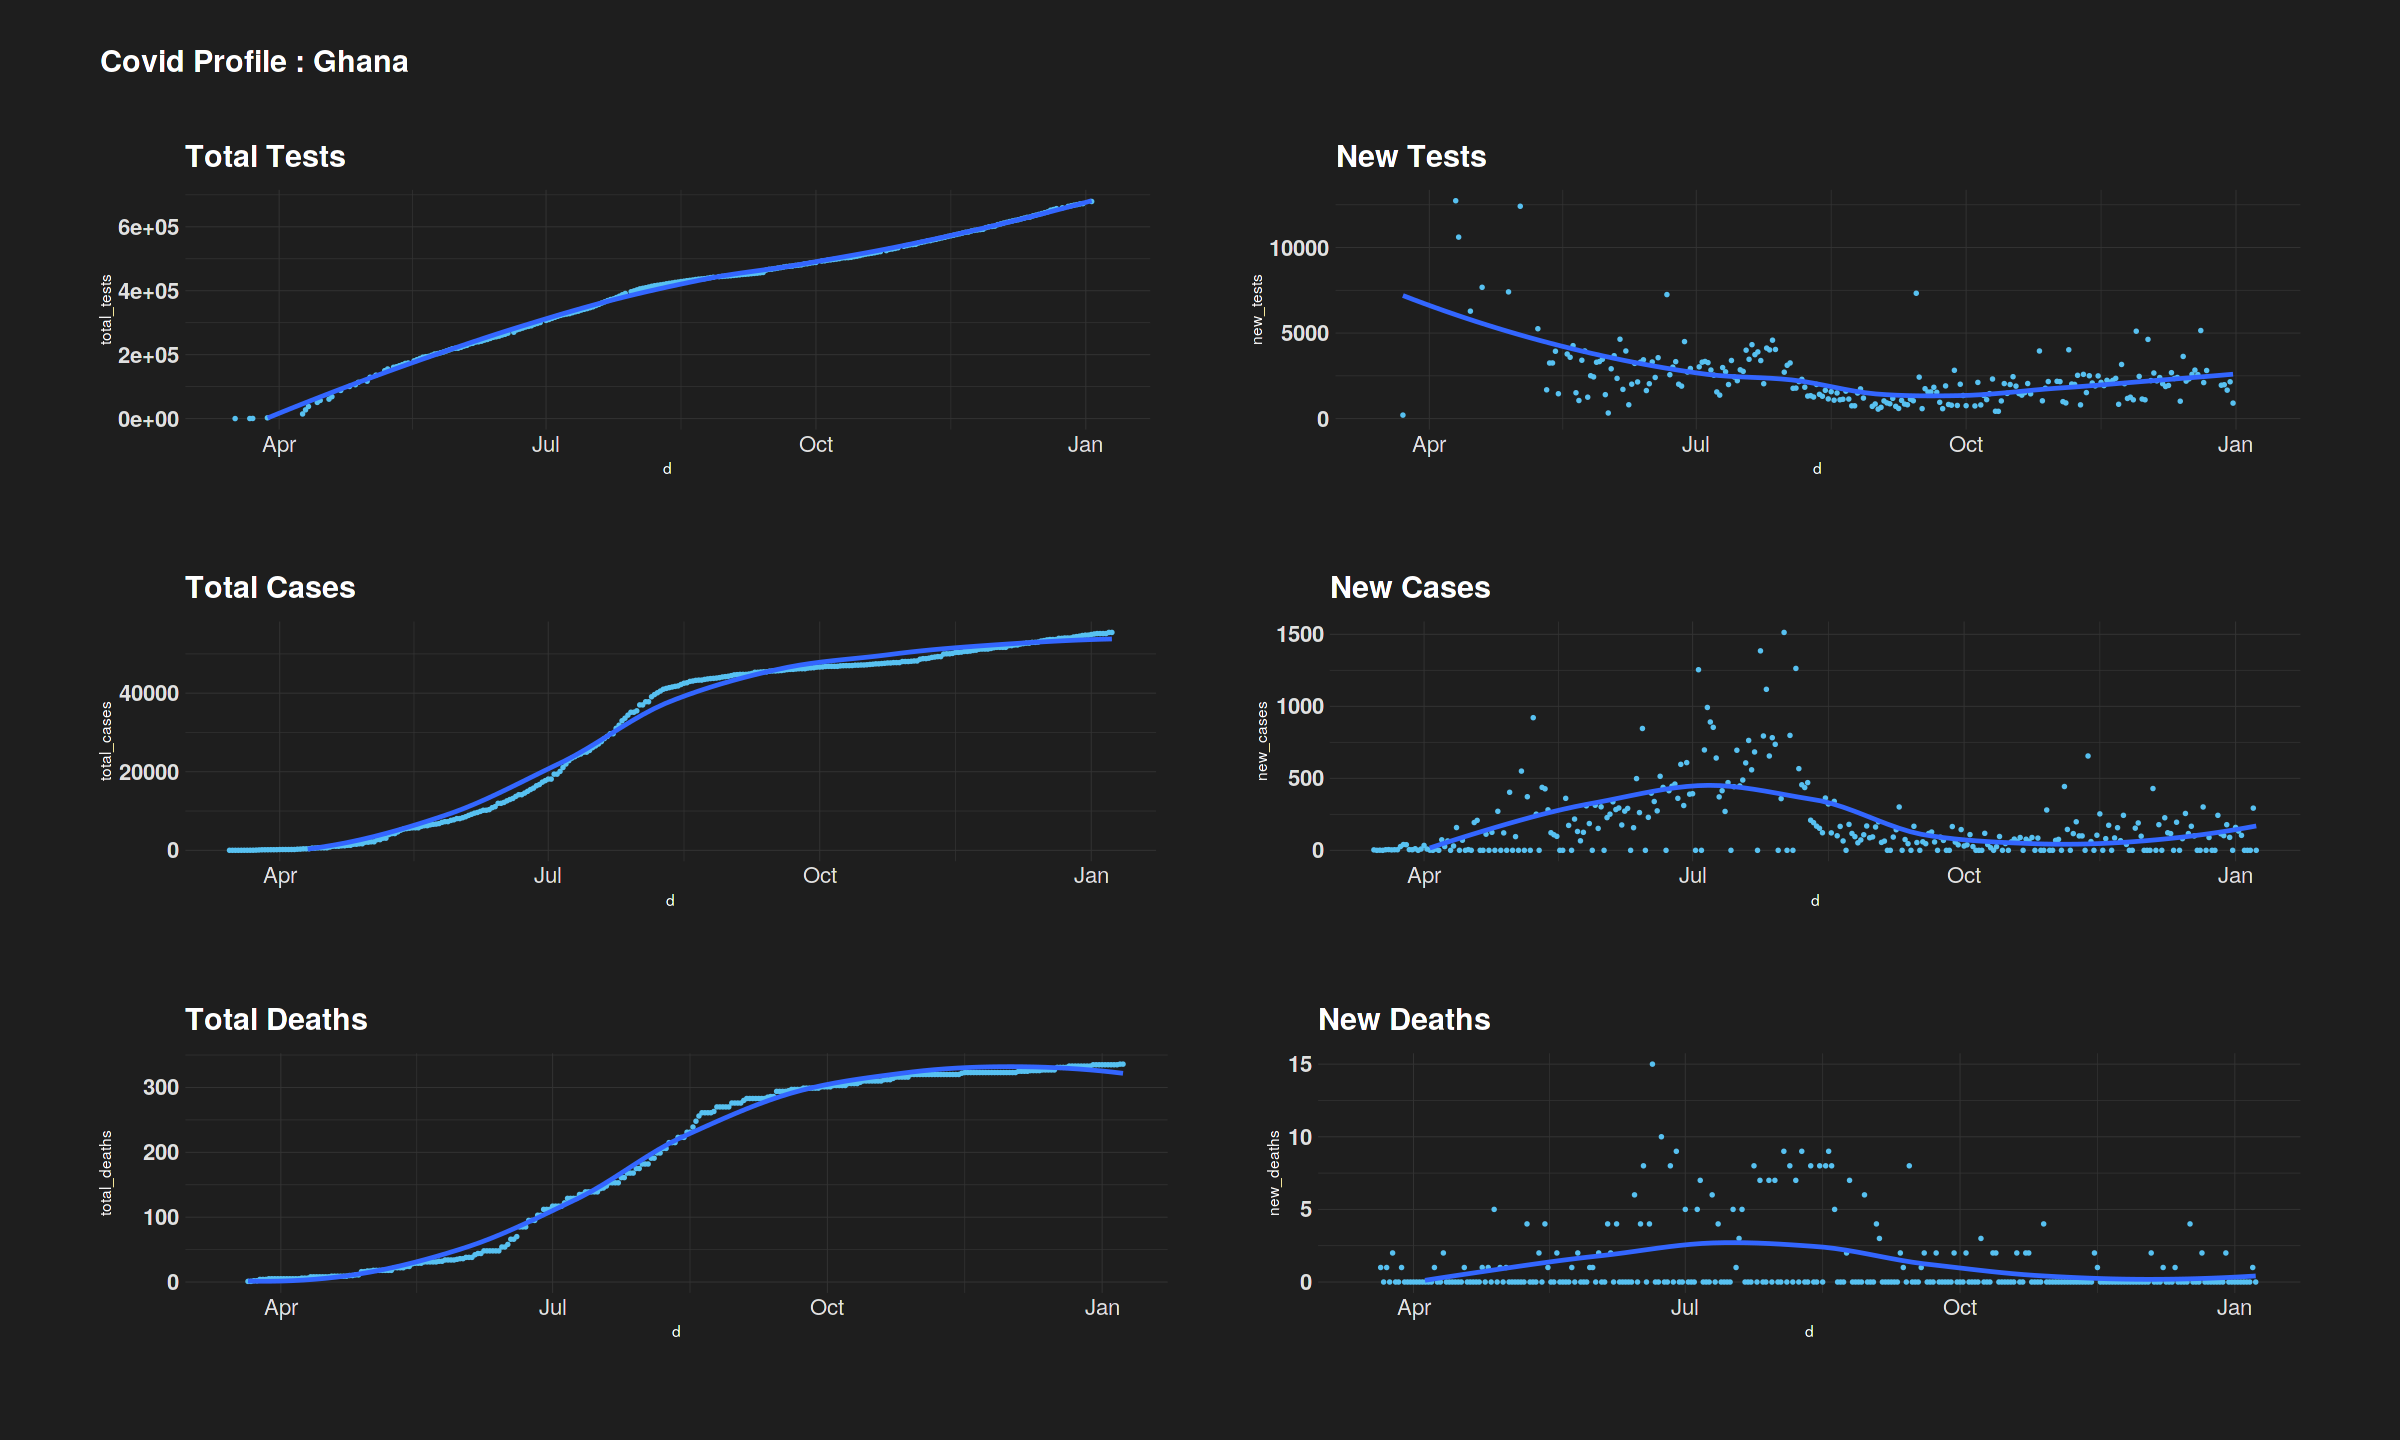

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



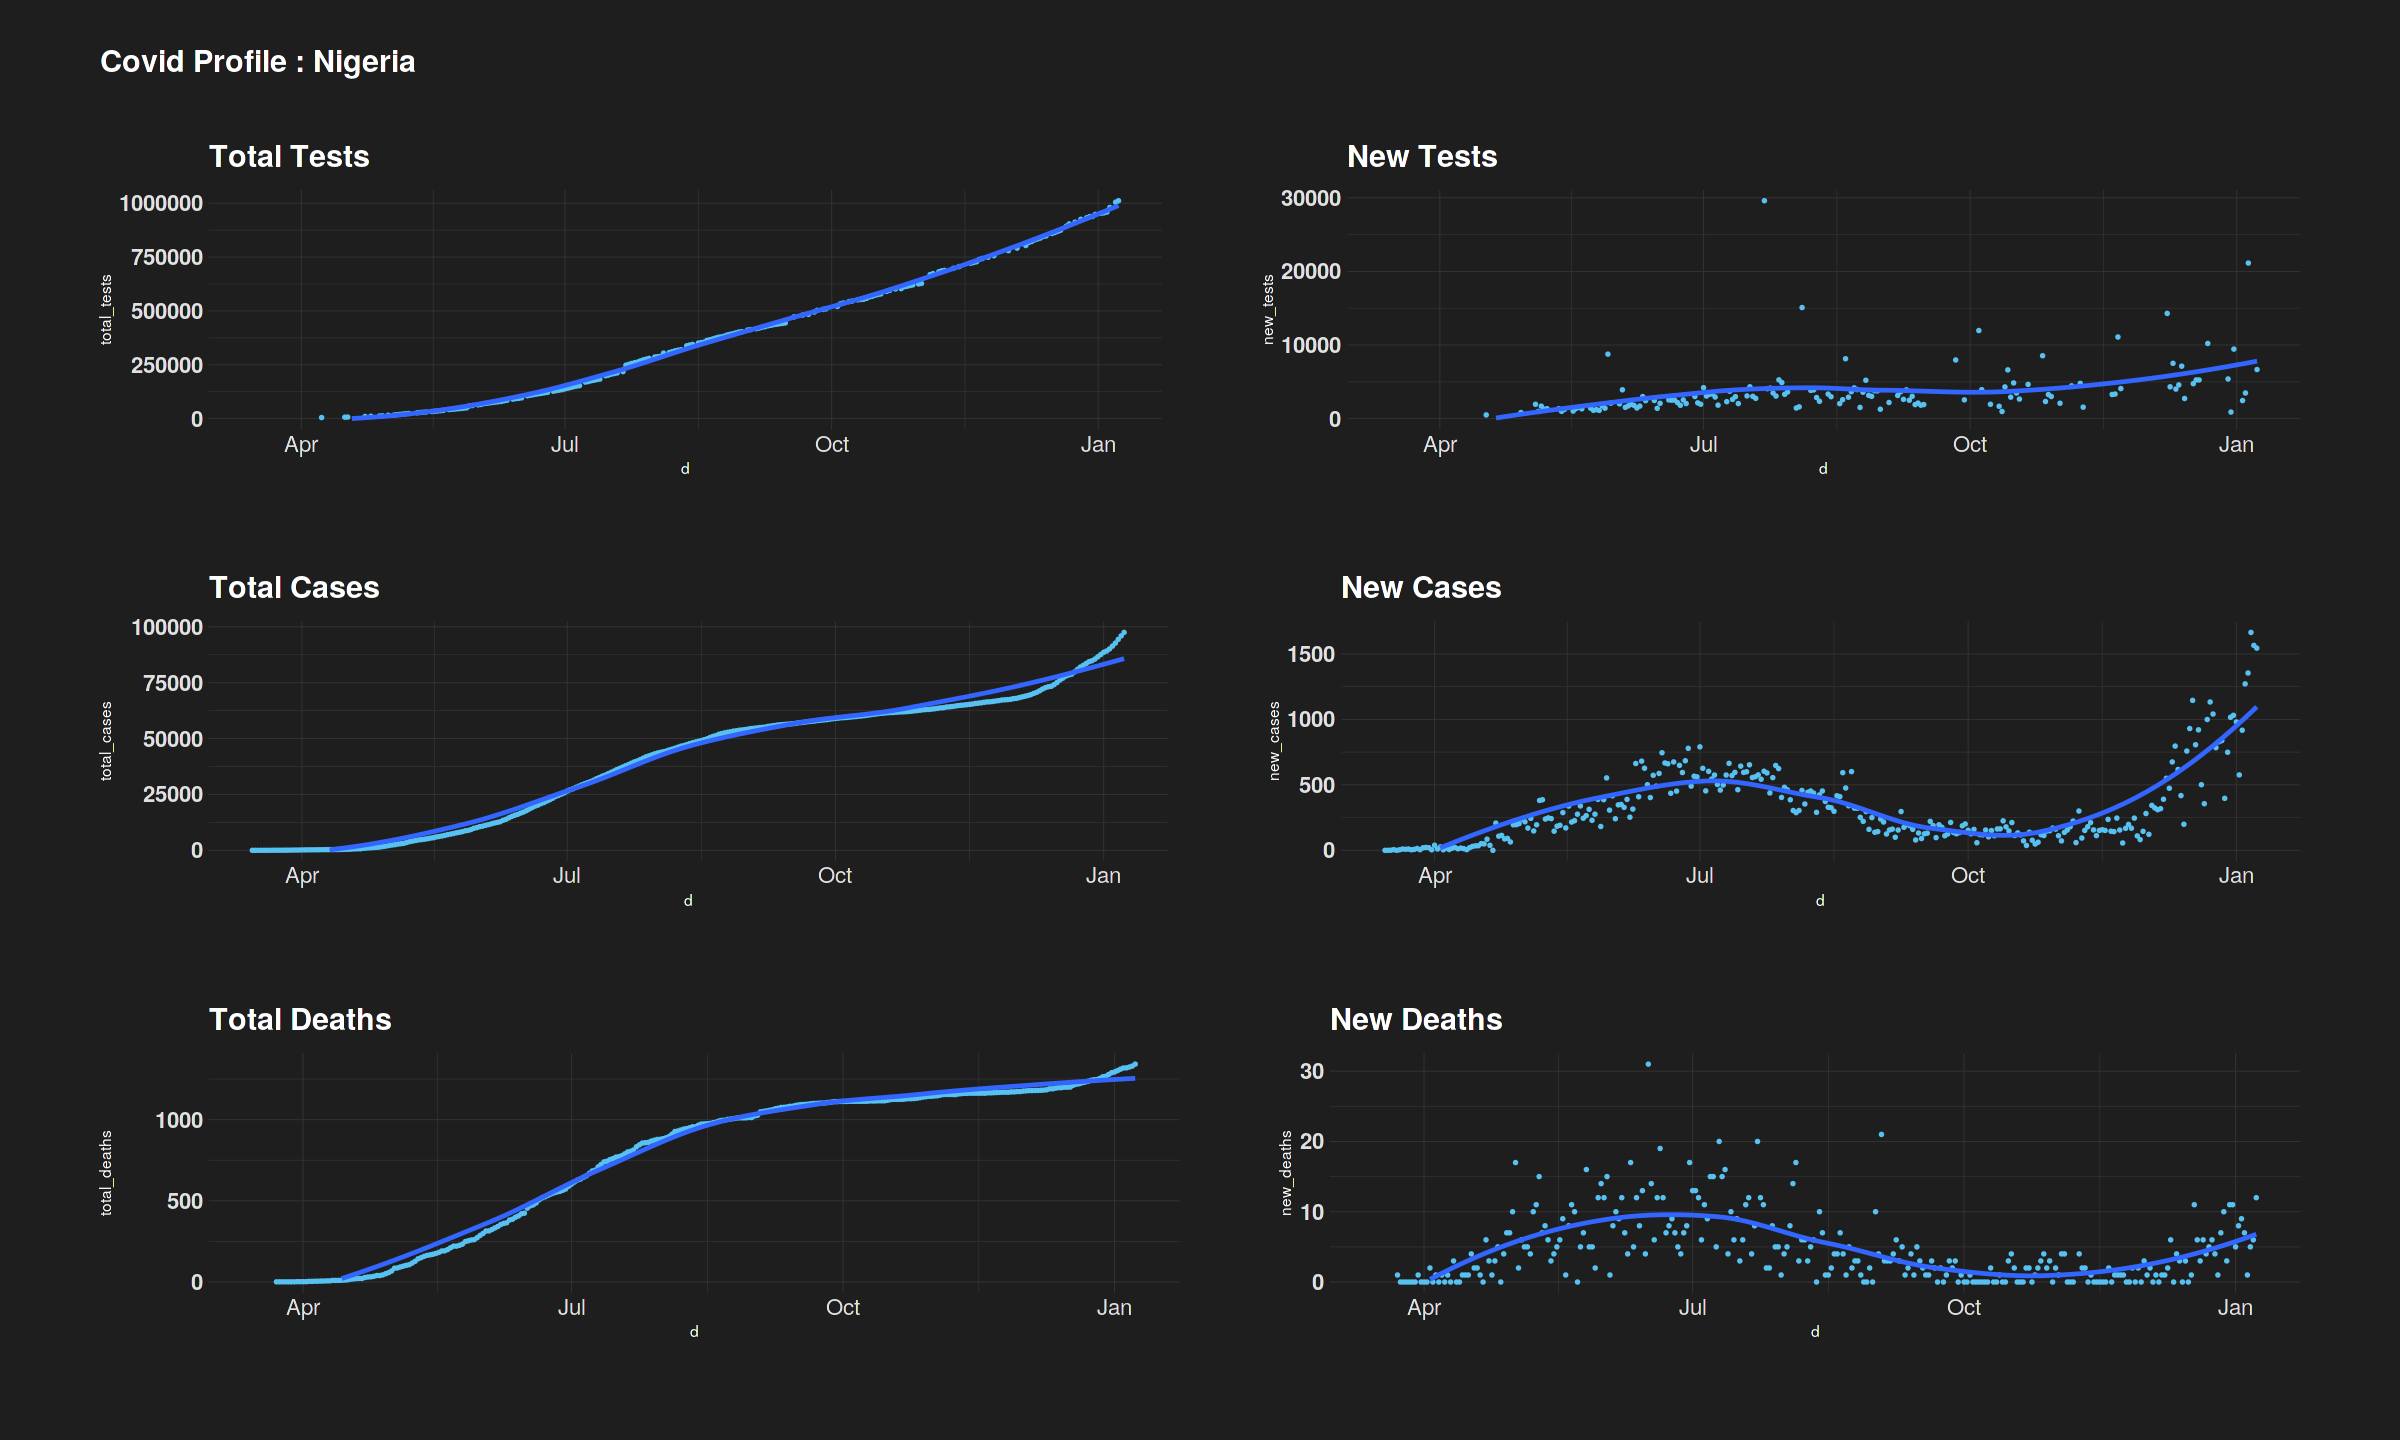

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



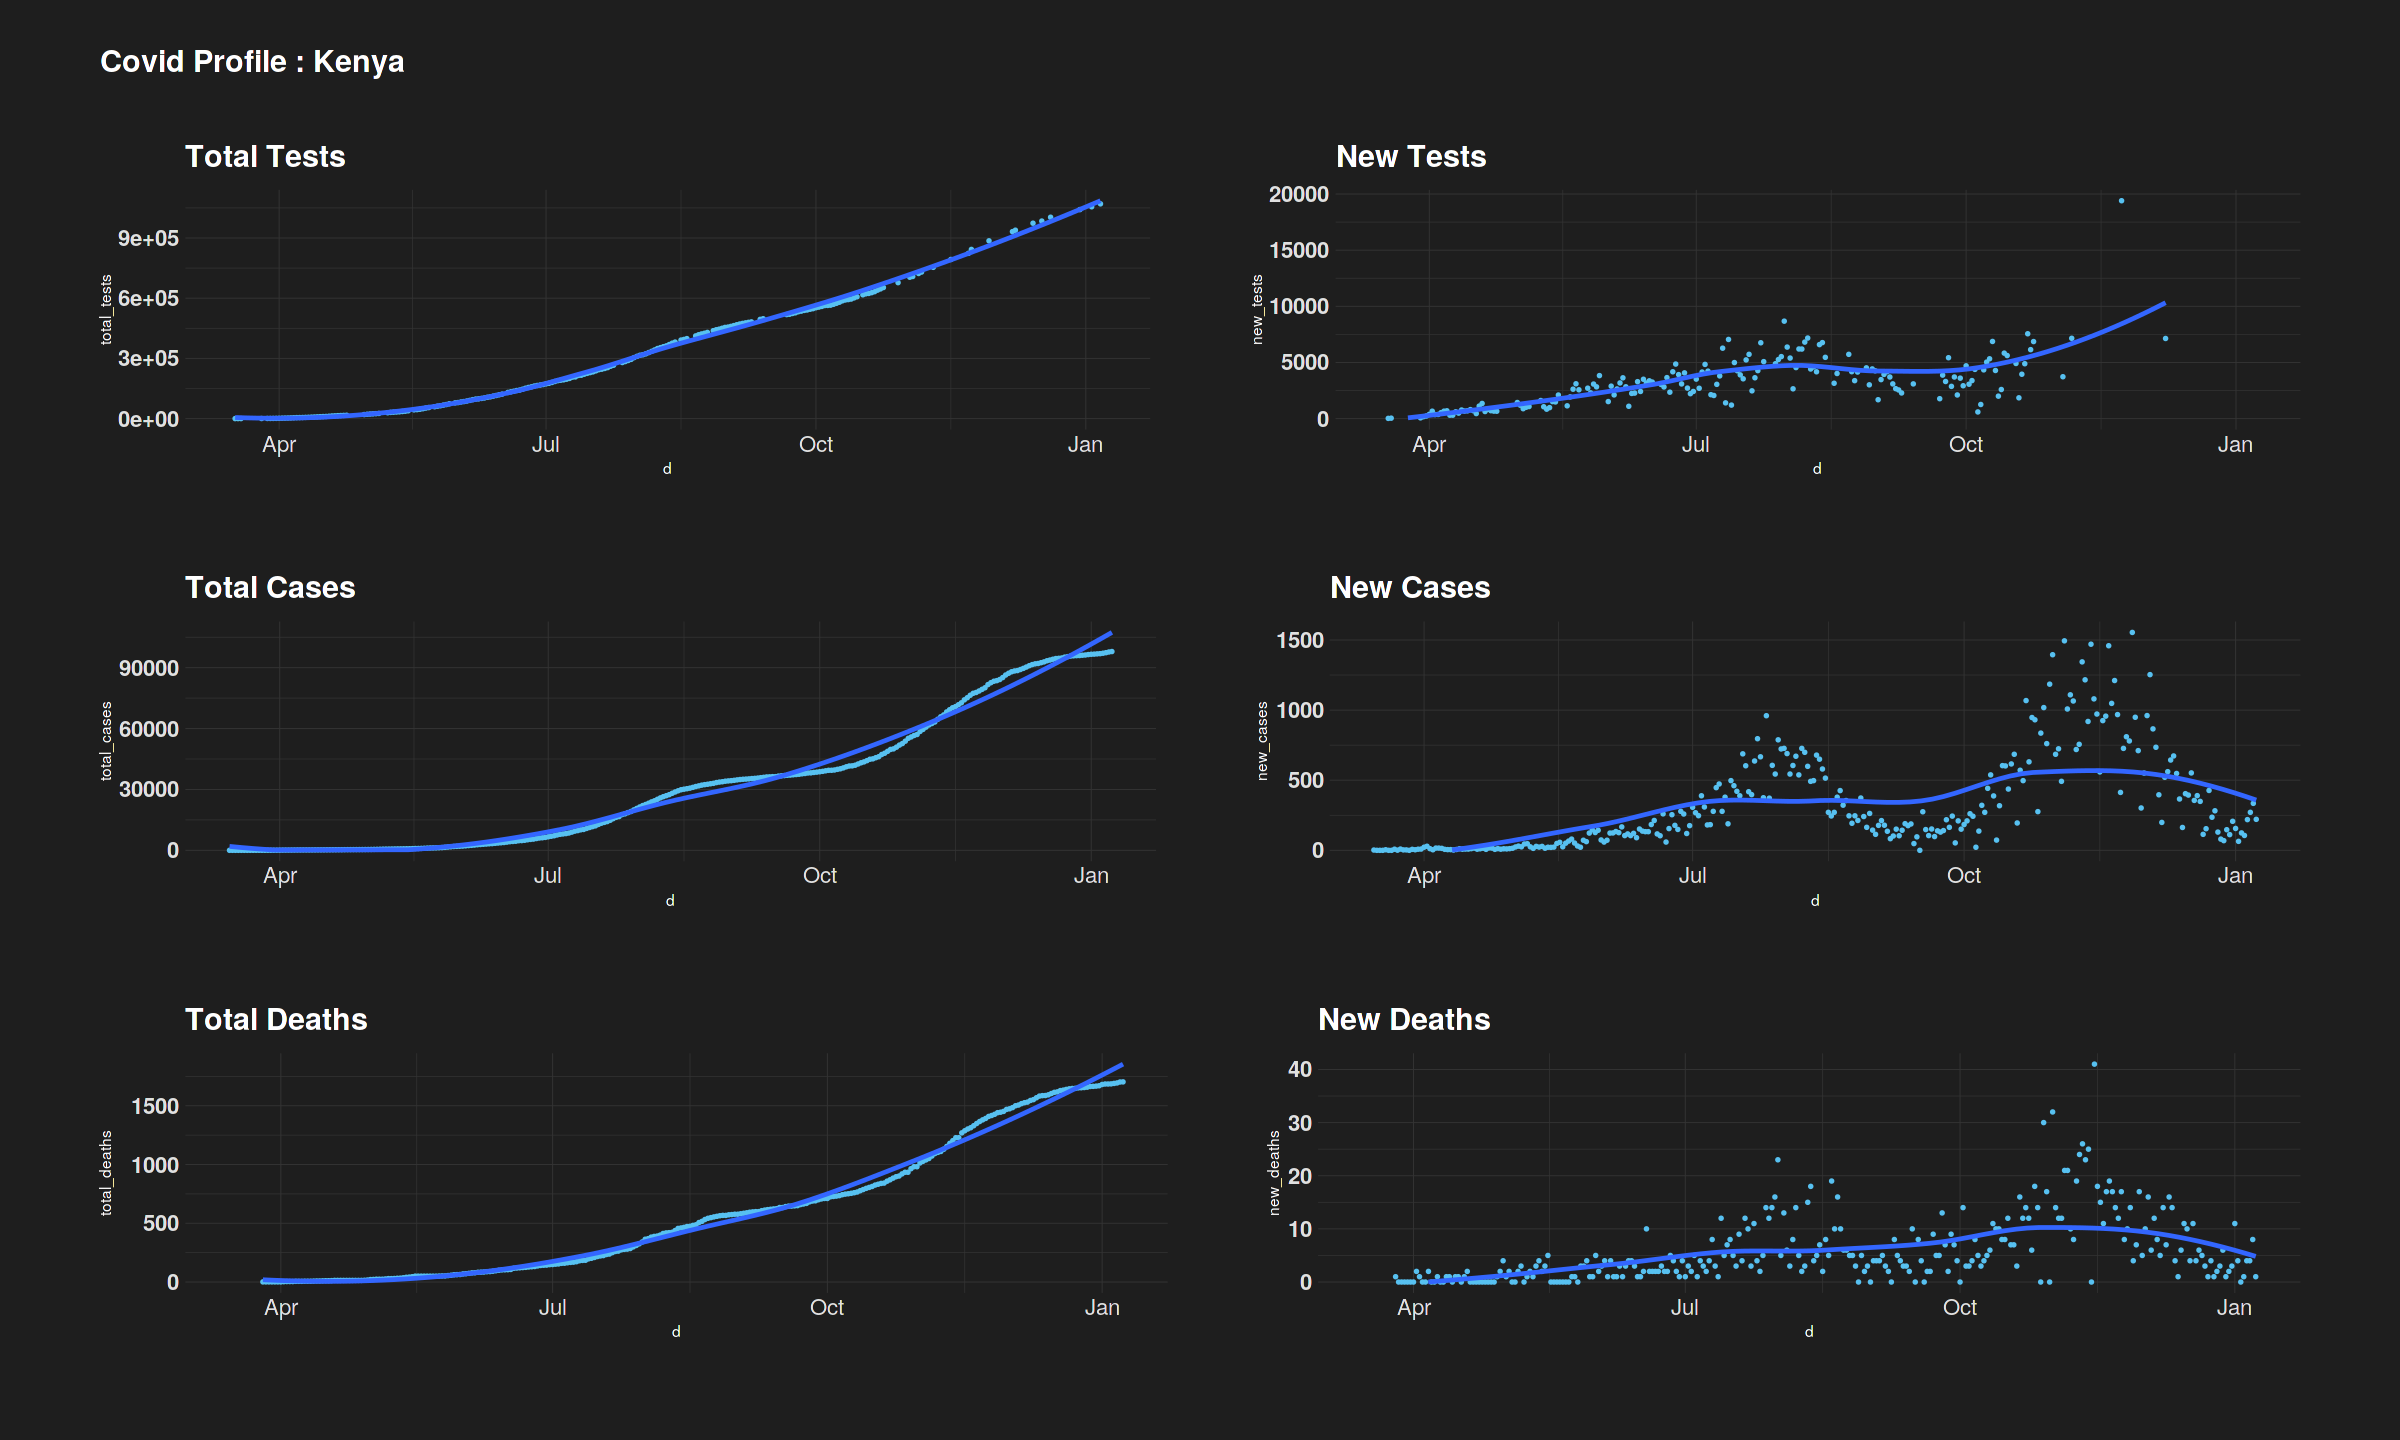

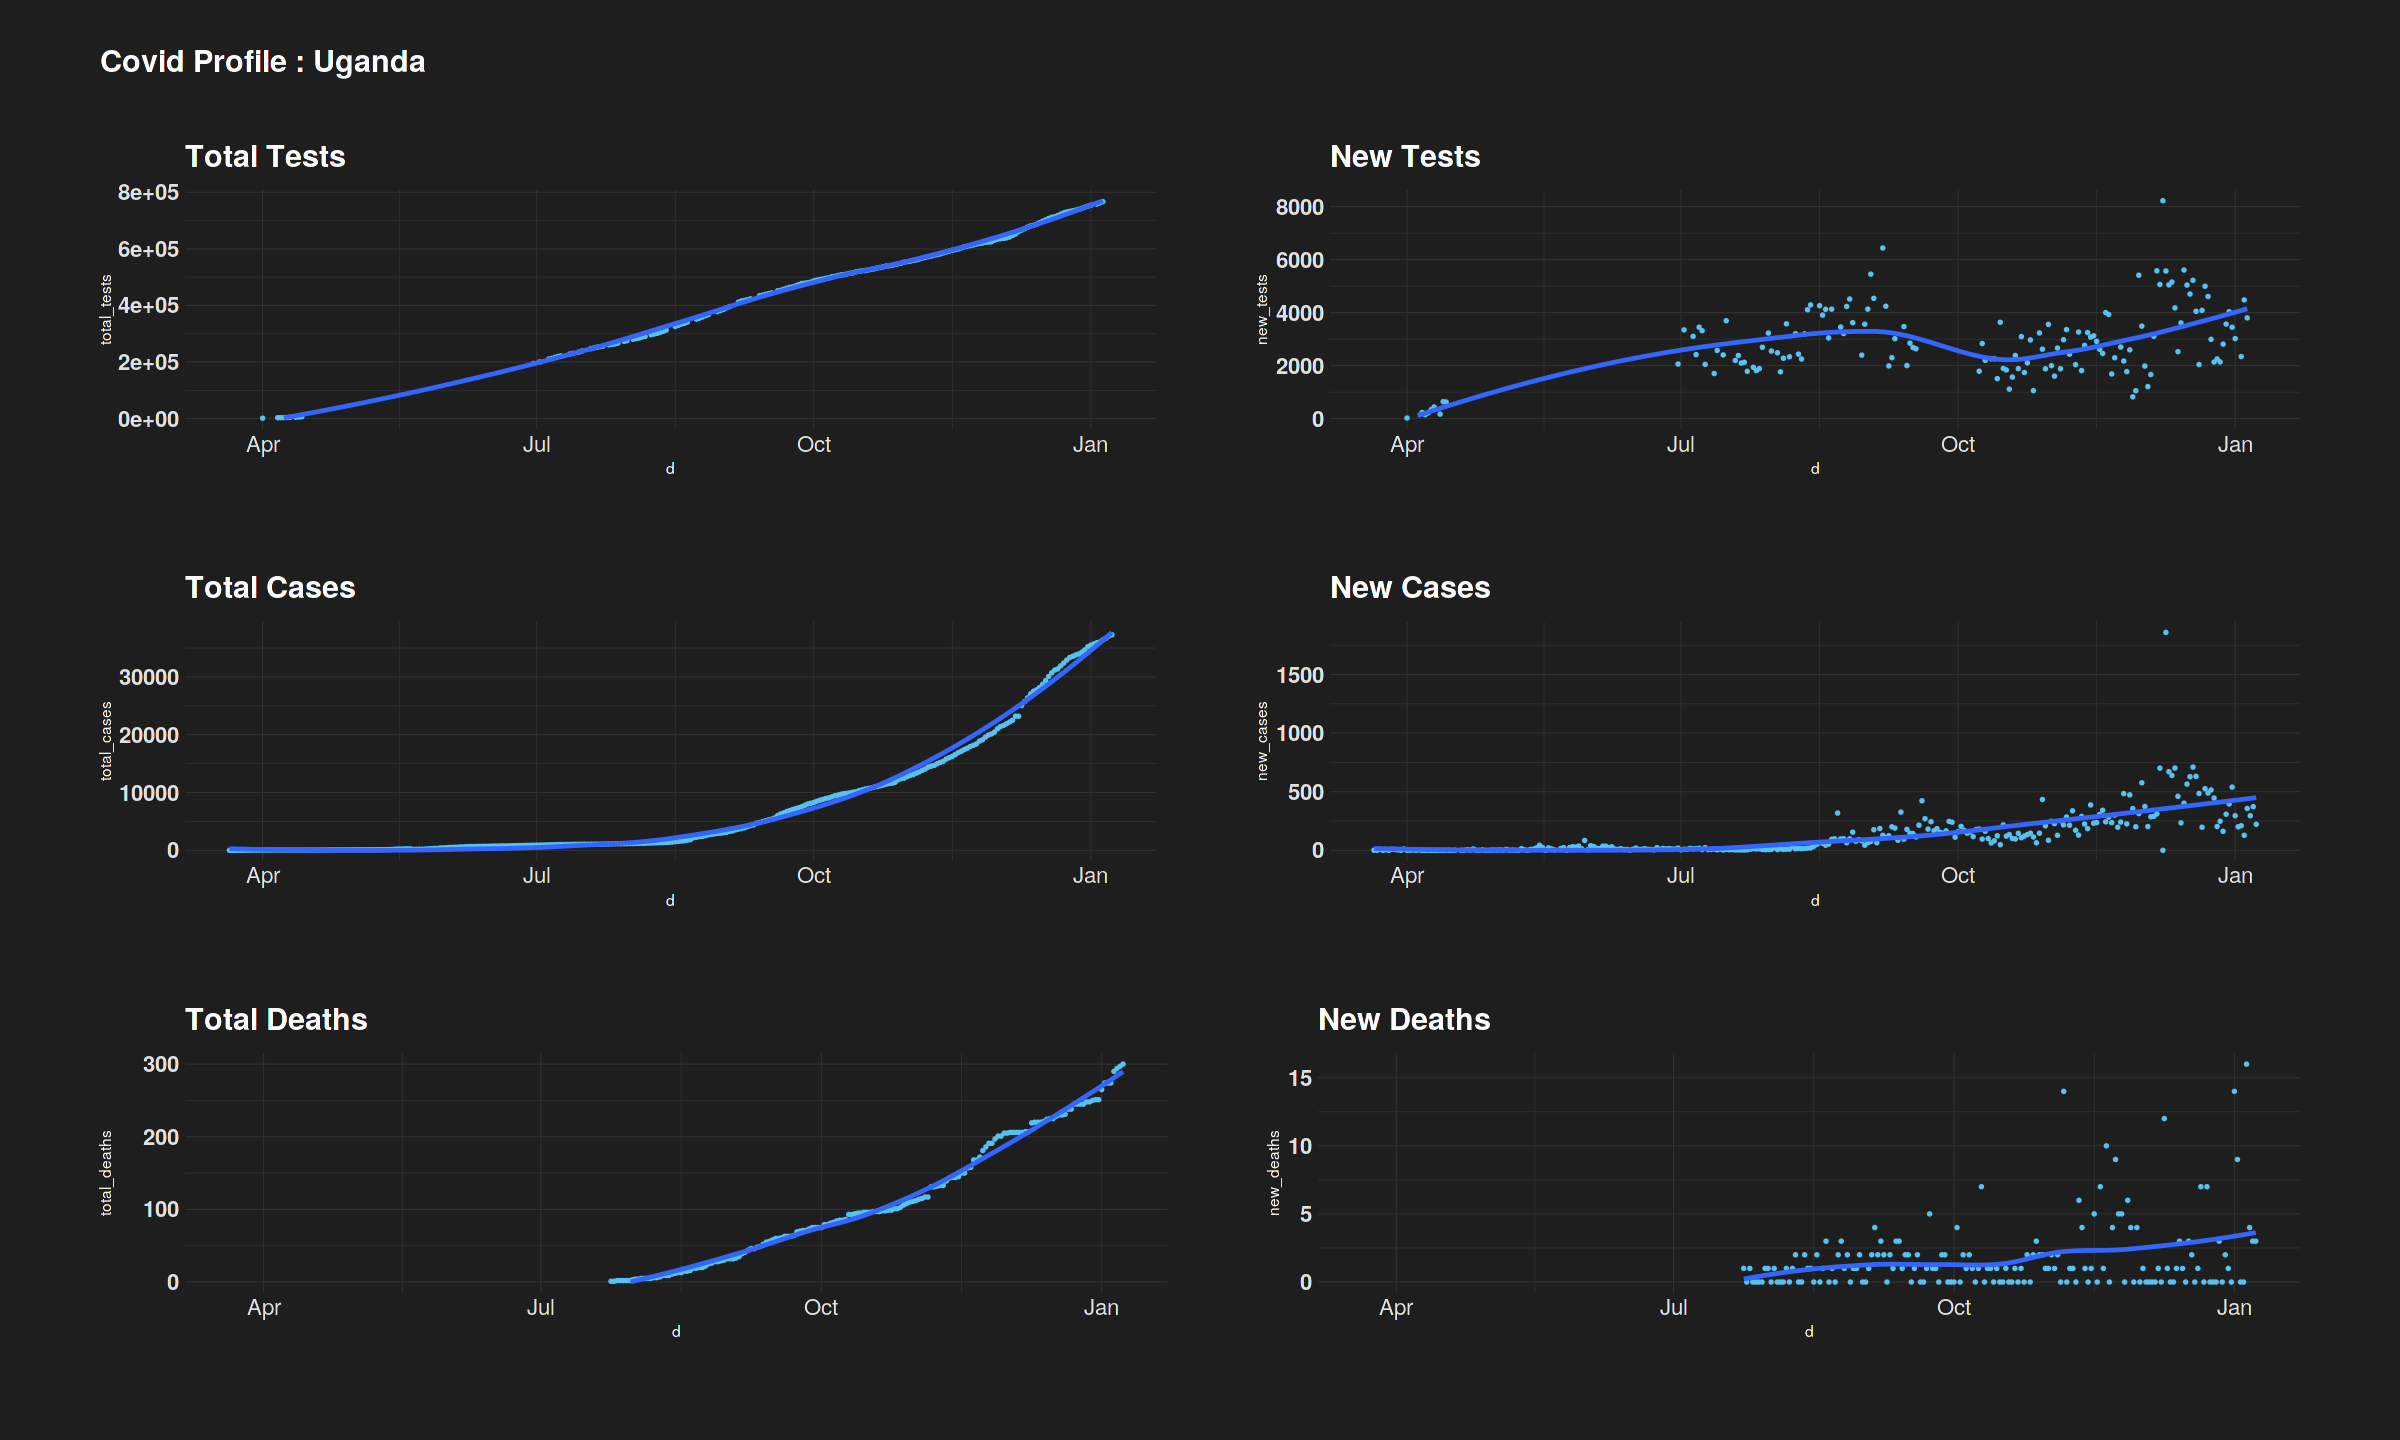

In [25]:
country_plot("Ghana")
country_plot("Nigeria")
country_plot("Kenya")
country_plot("Uganda")

## Eastern Europe

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



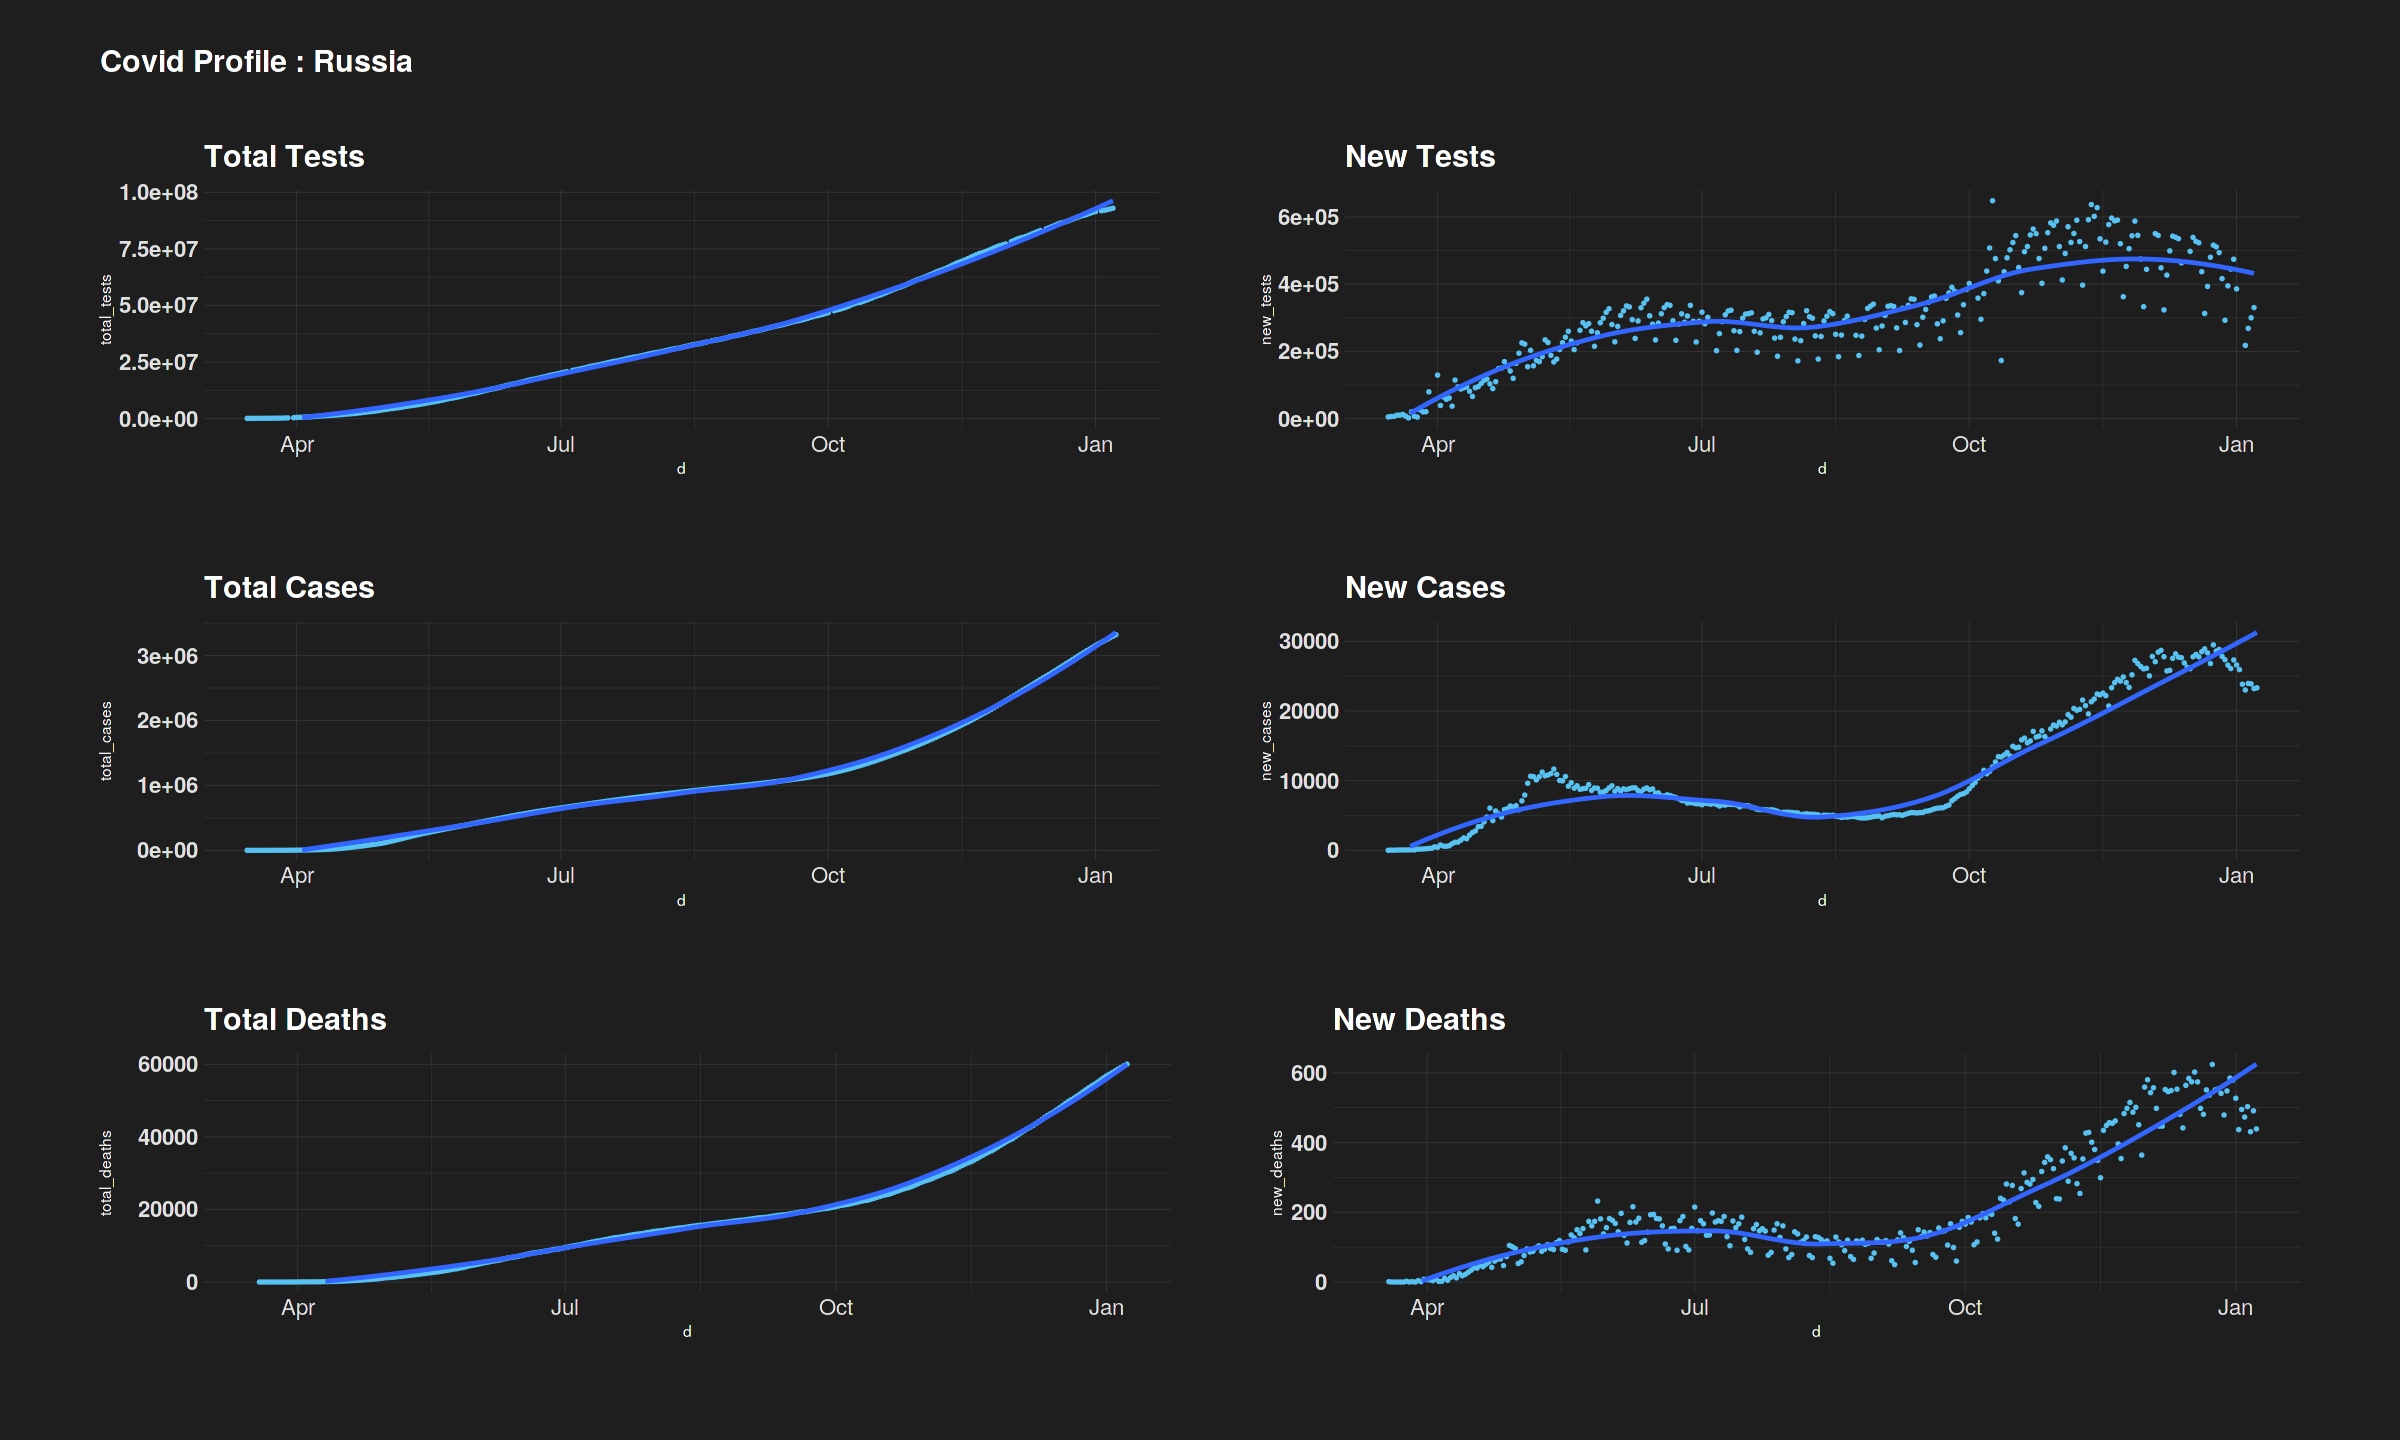

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



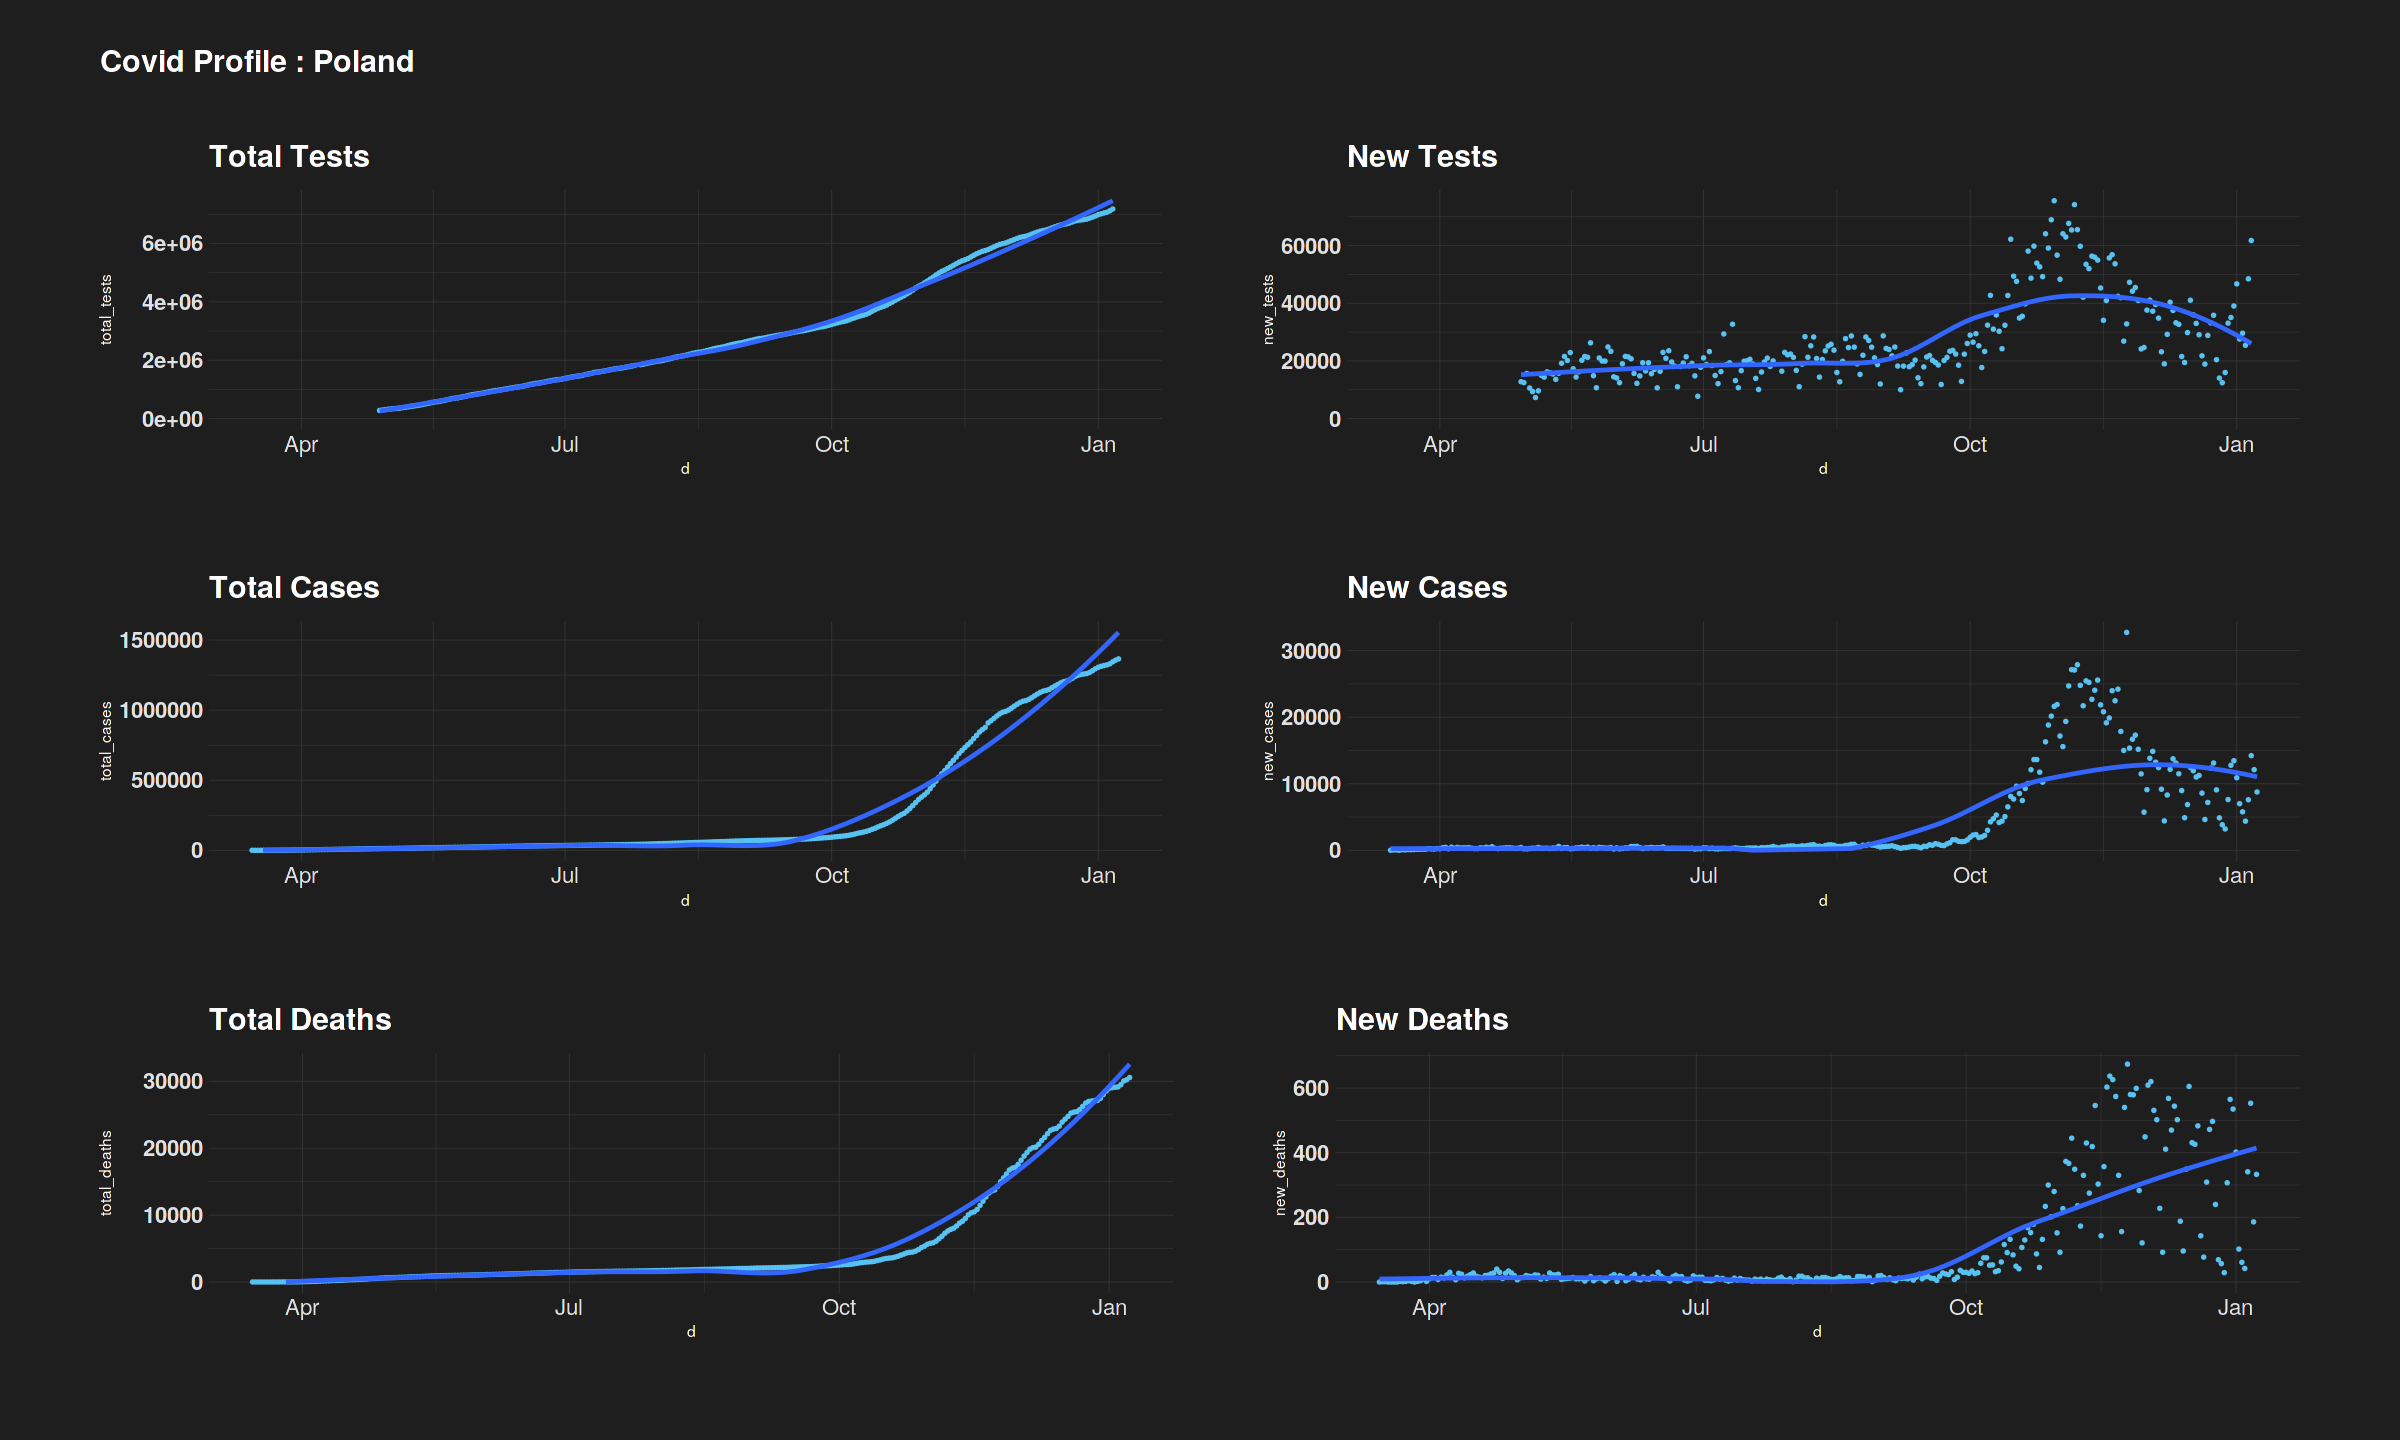

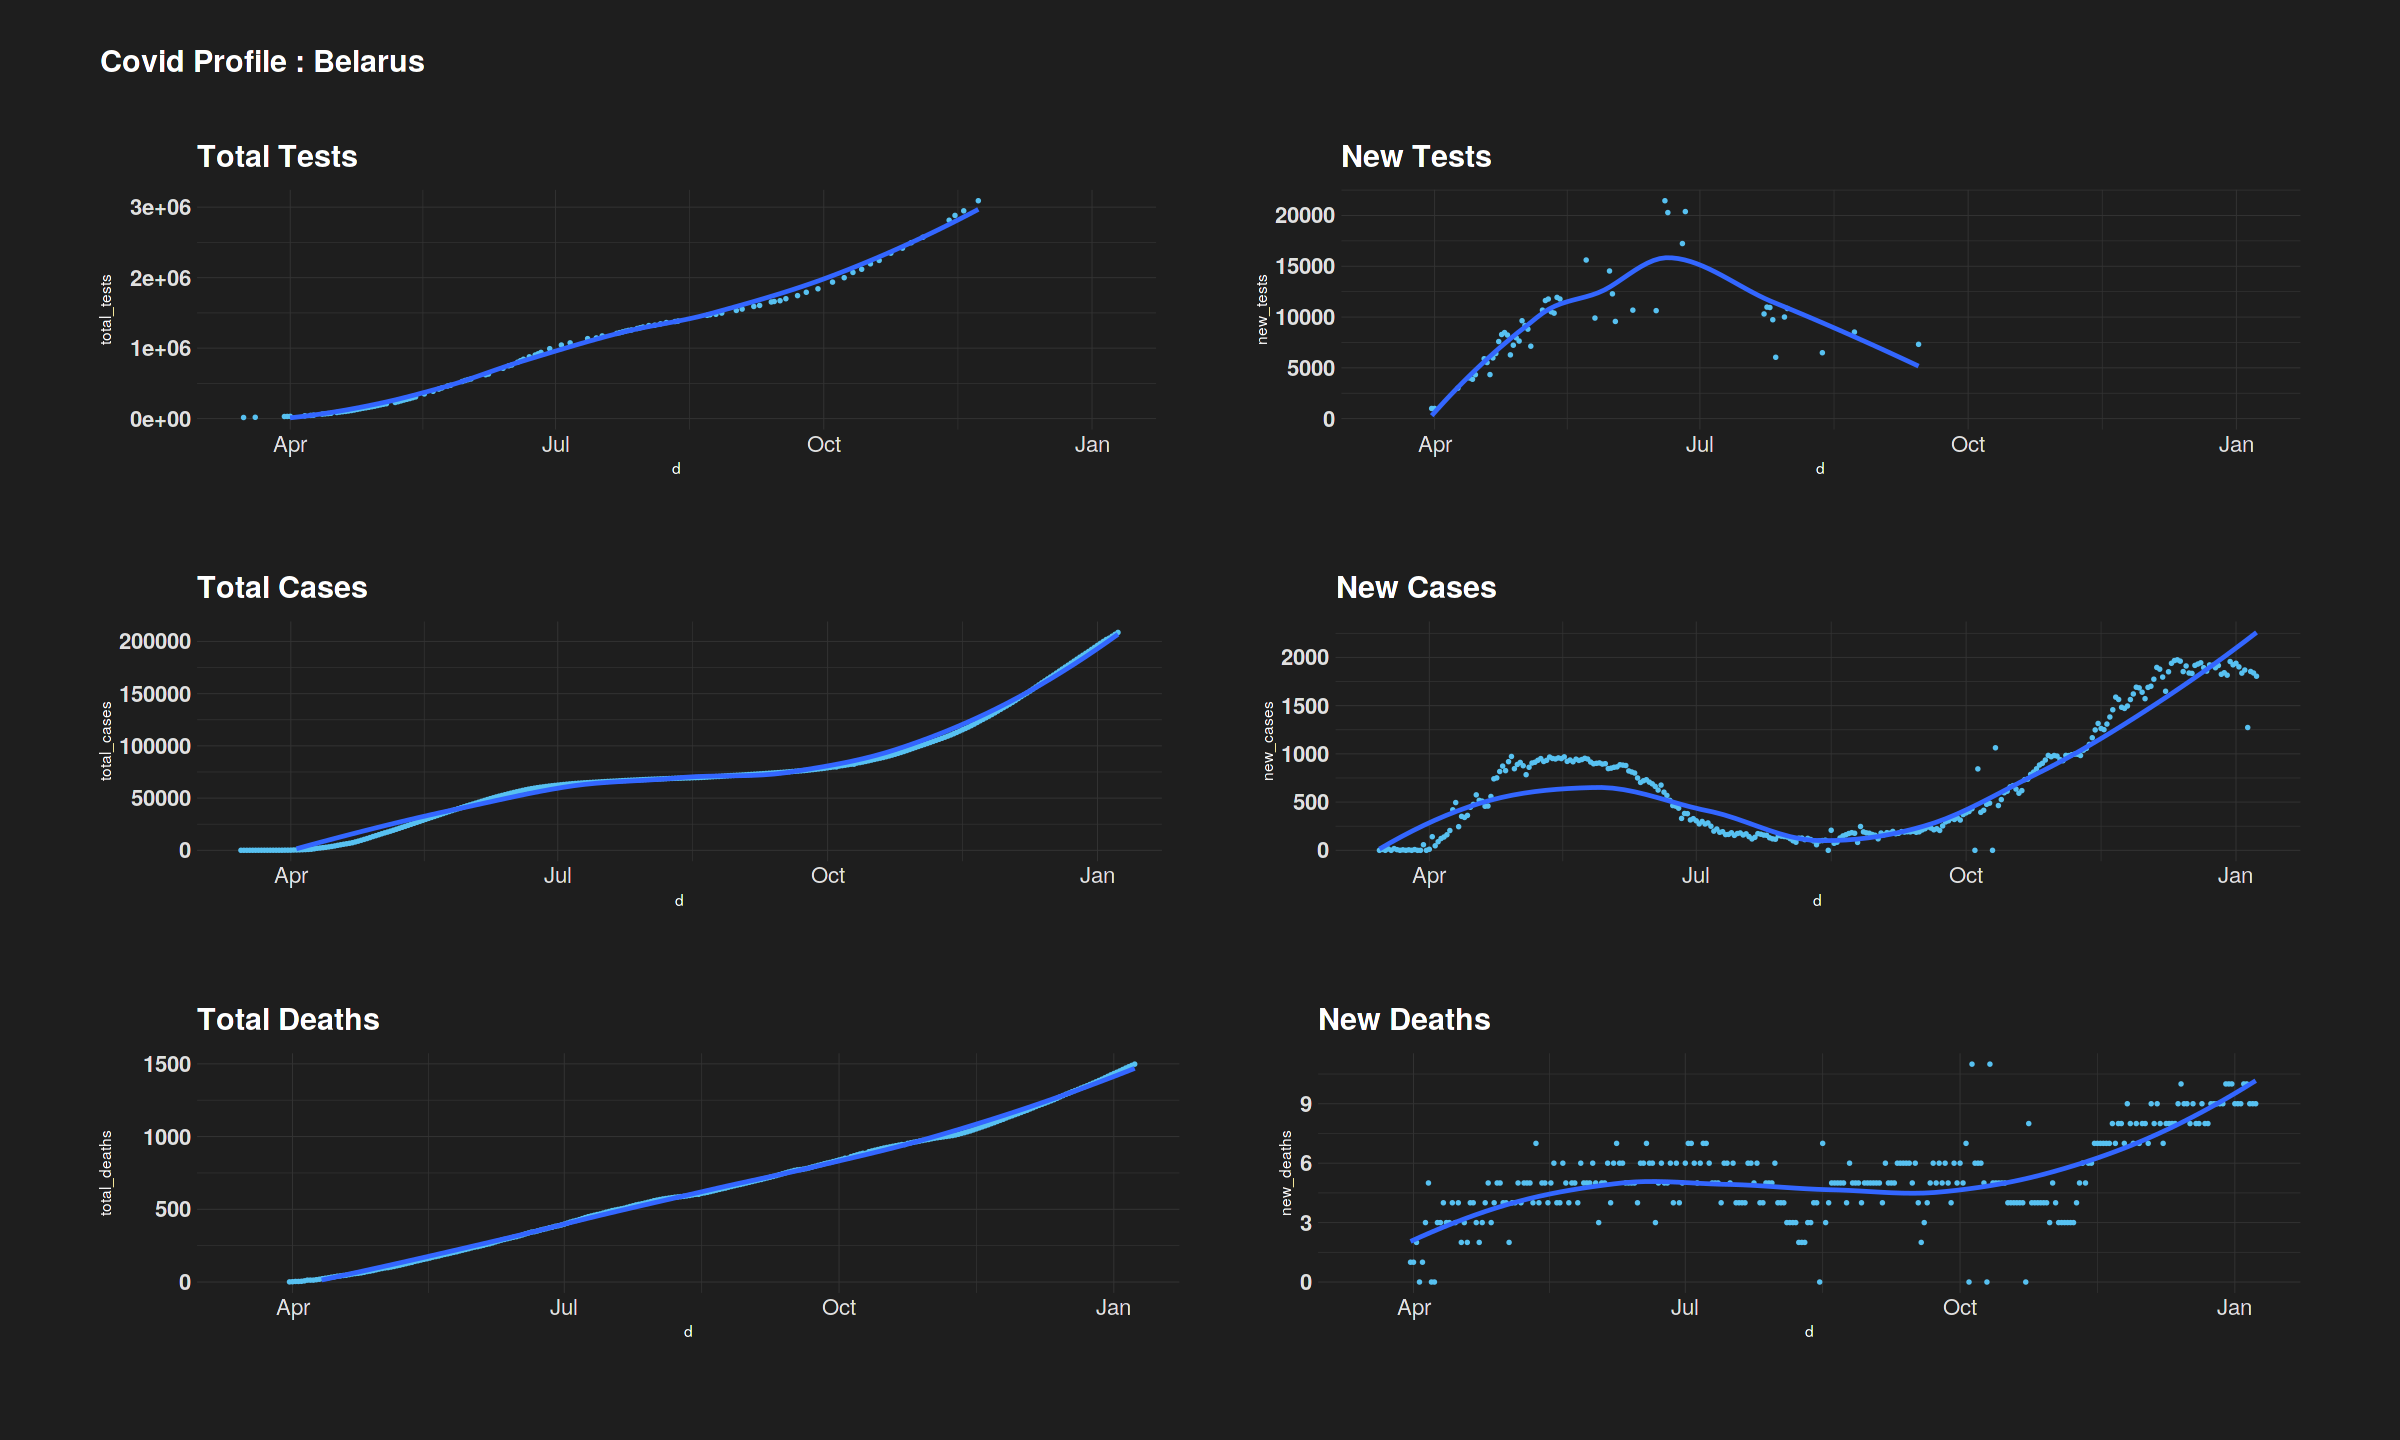

In [26]:
country_plot("Russia")
country_plot("Poland")
country_plot("Belarus")

## North America

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



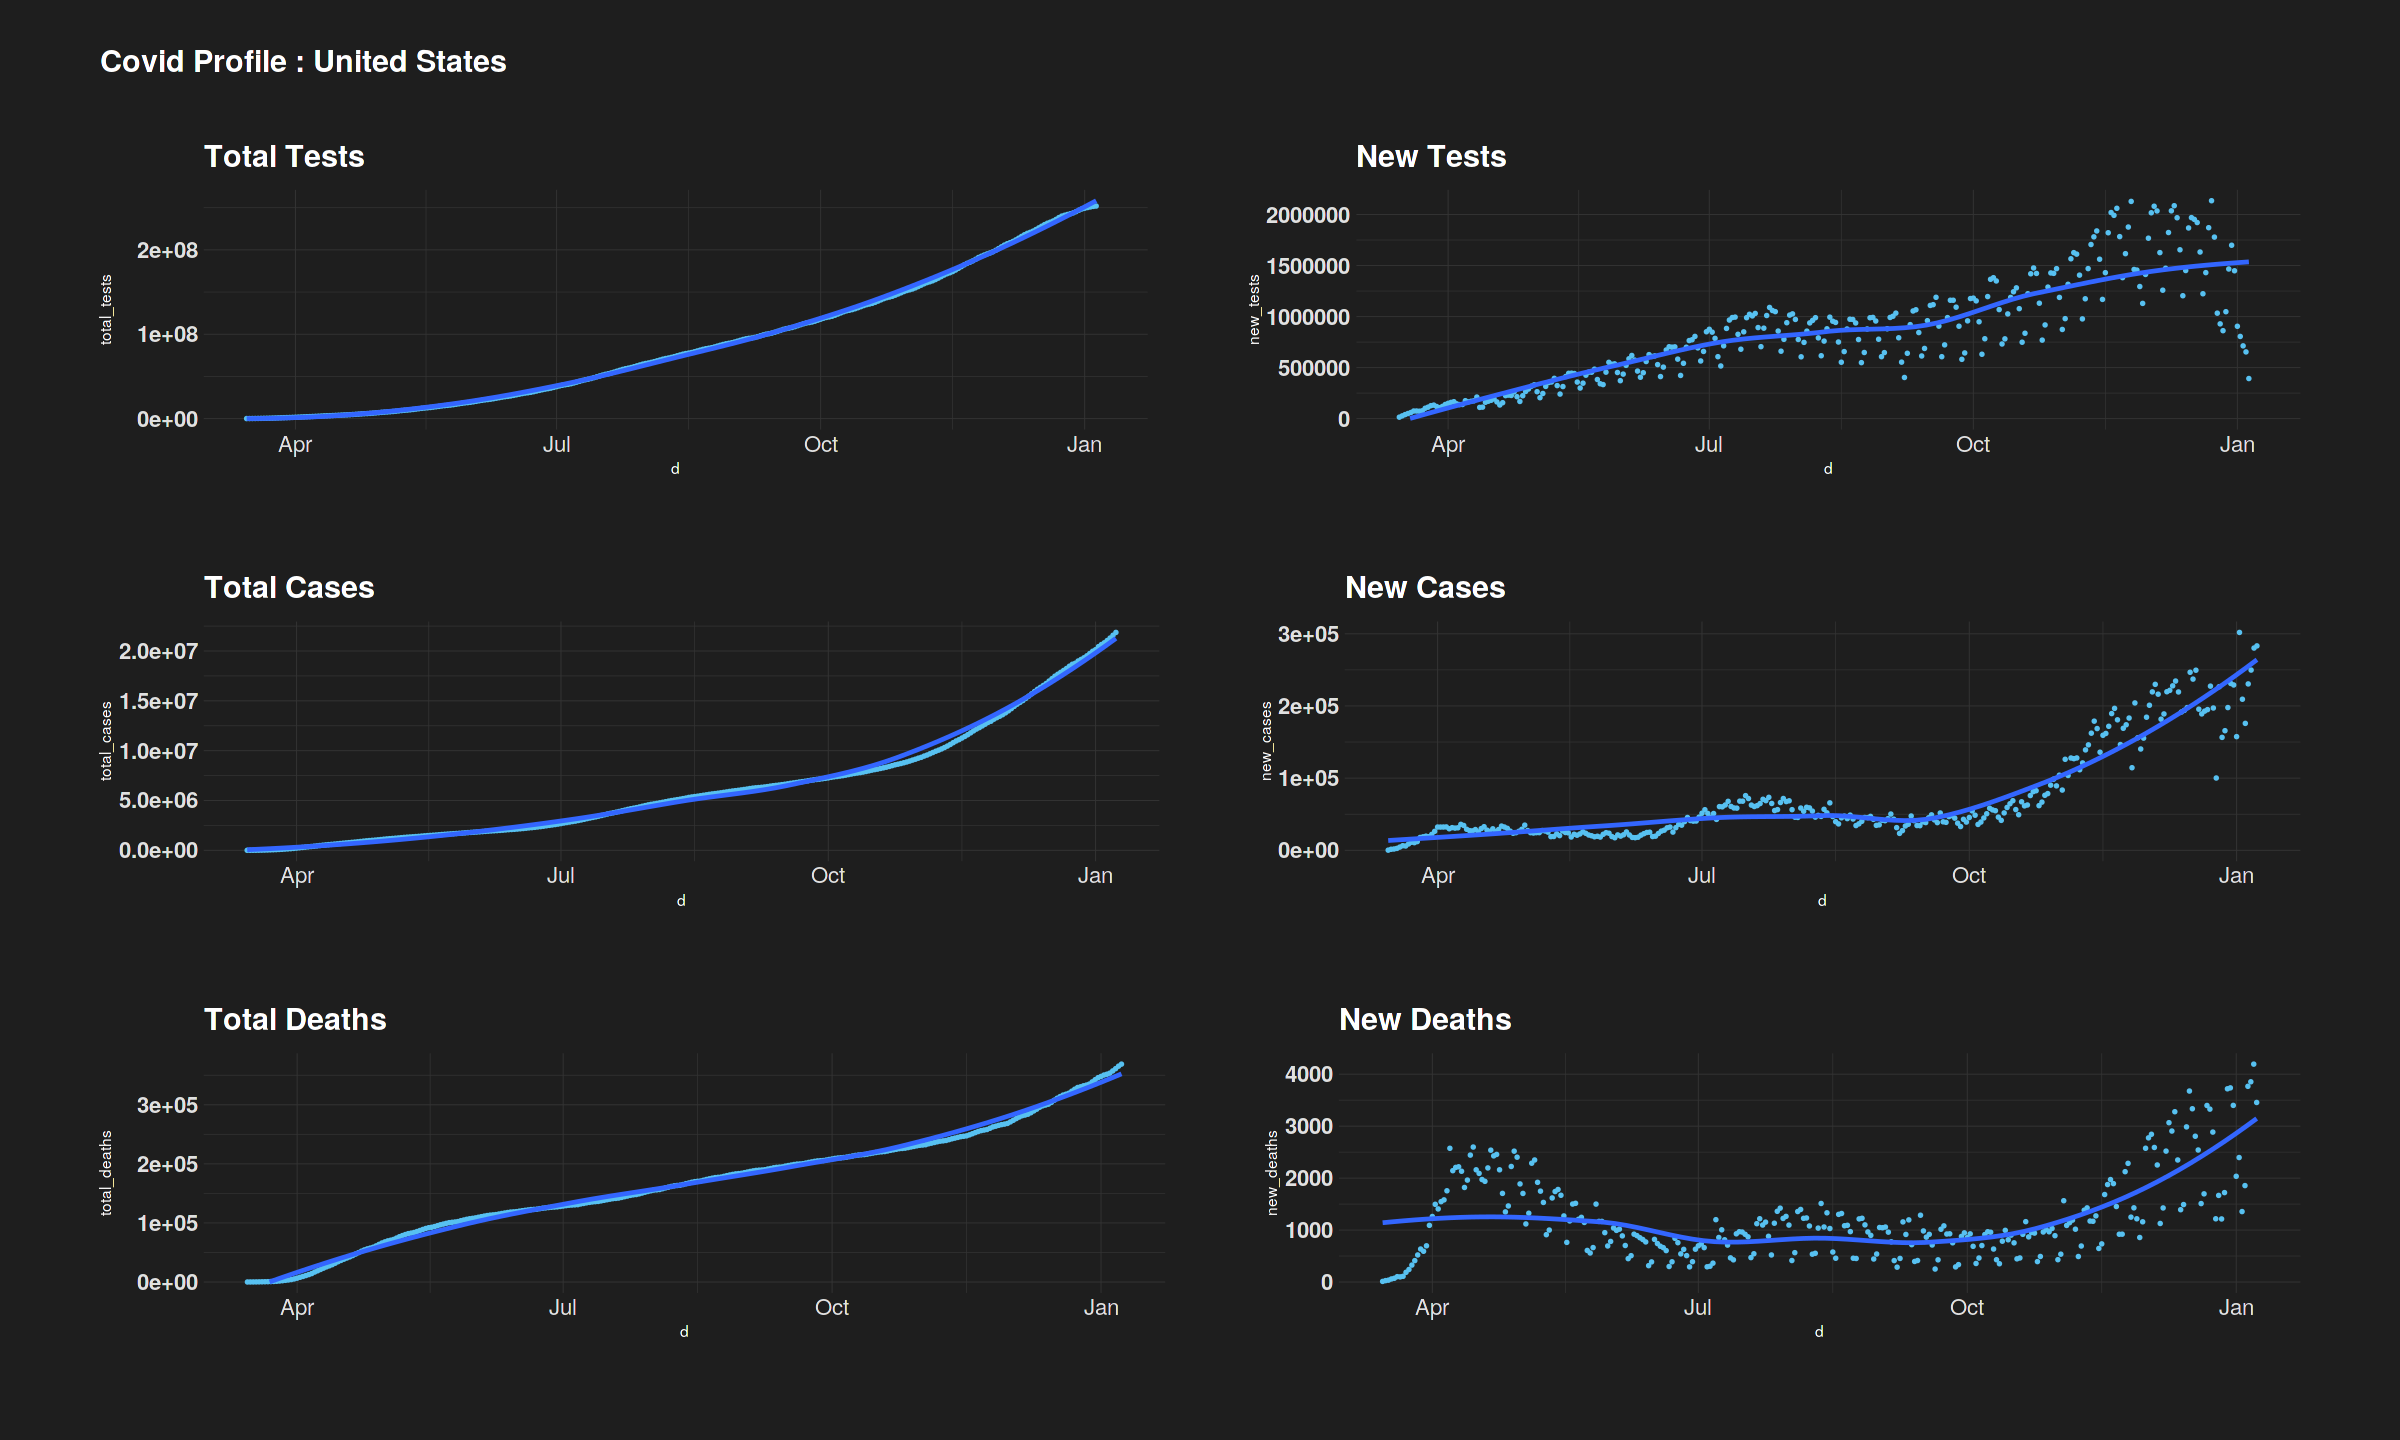

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



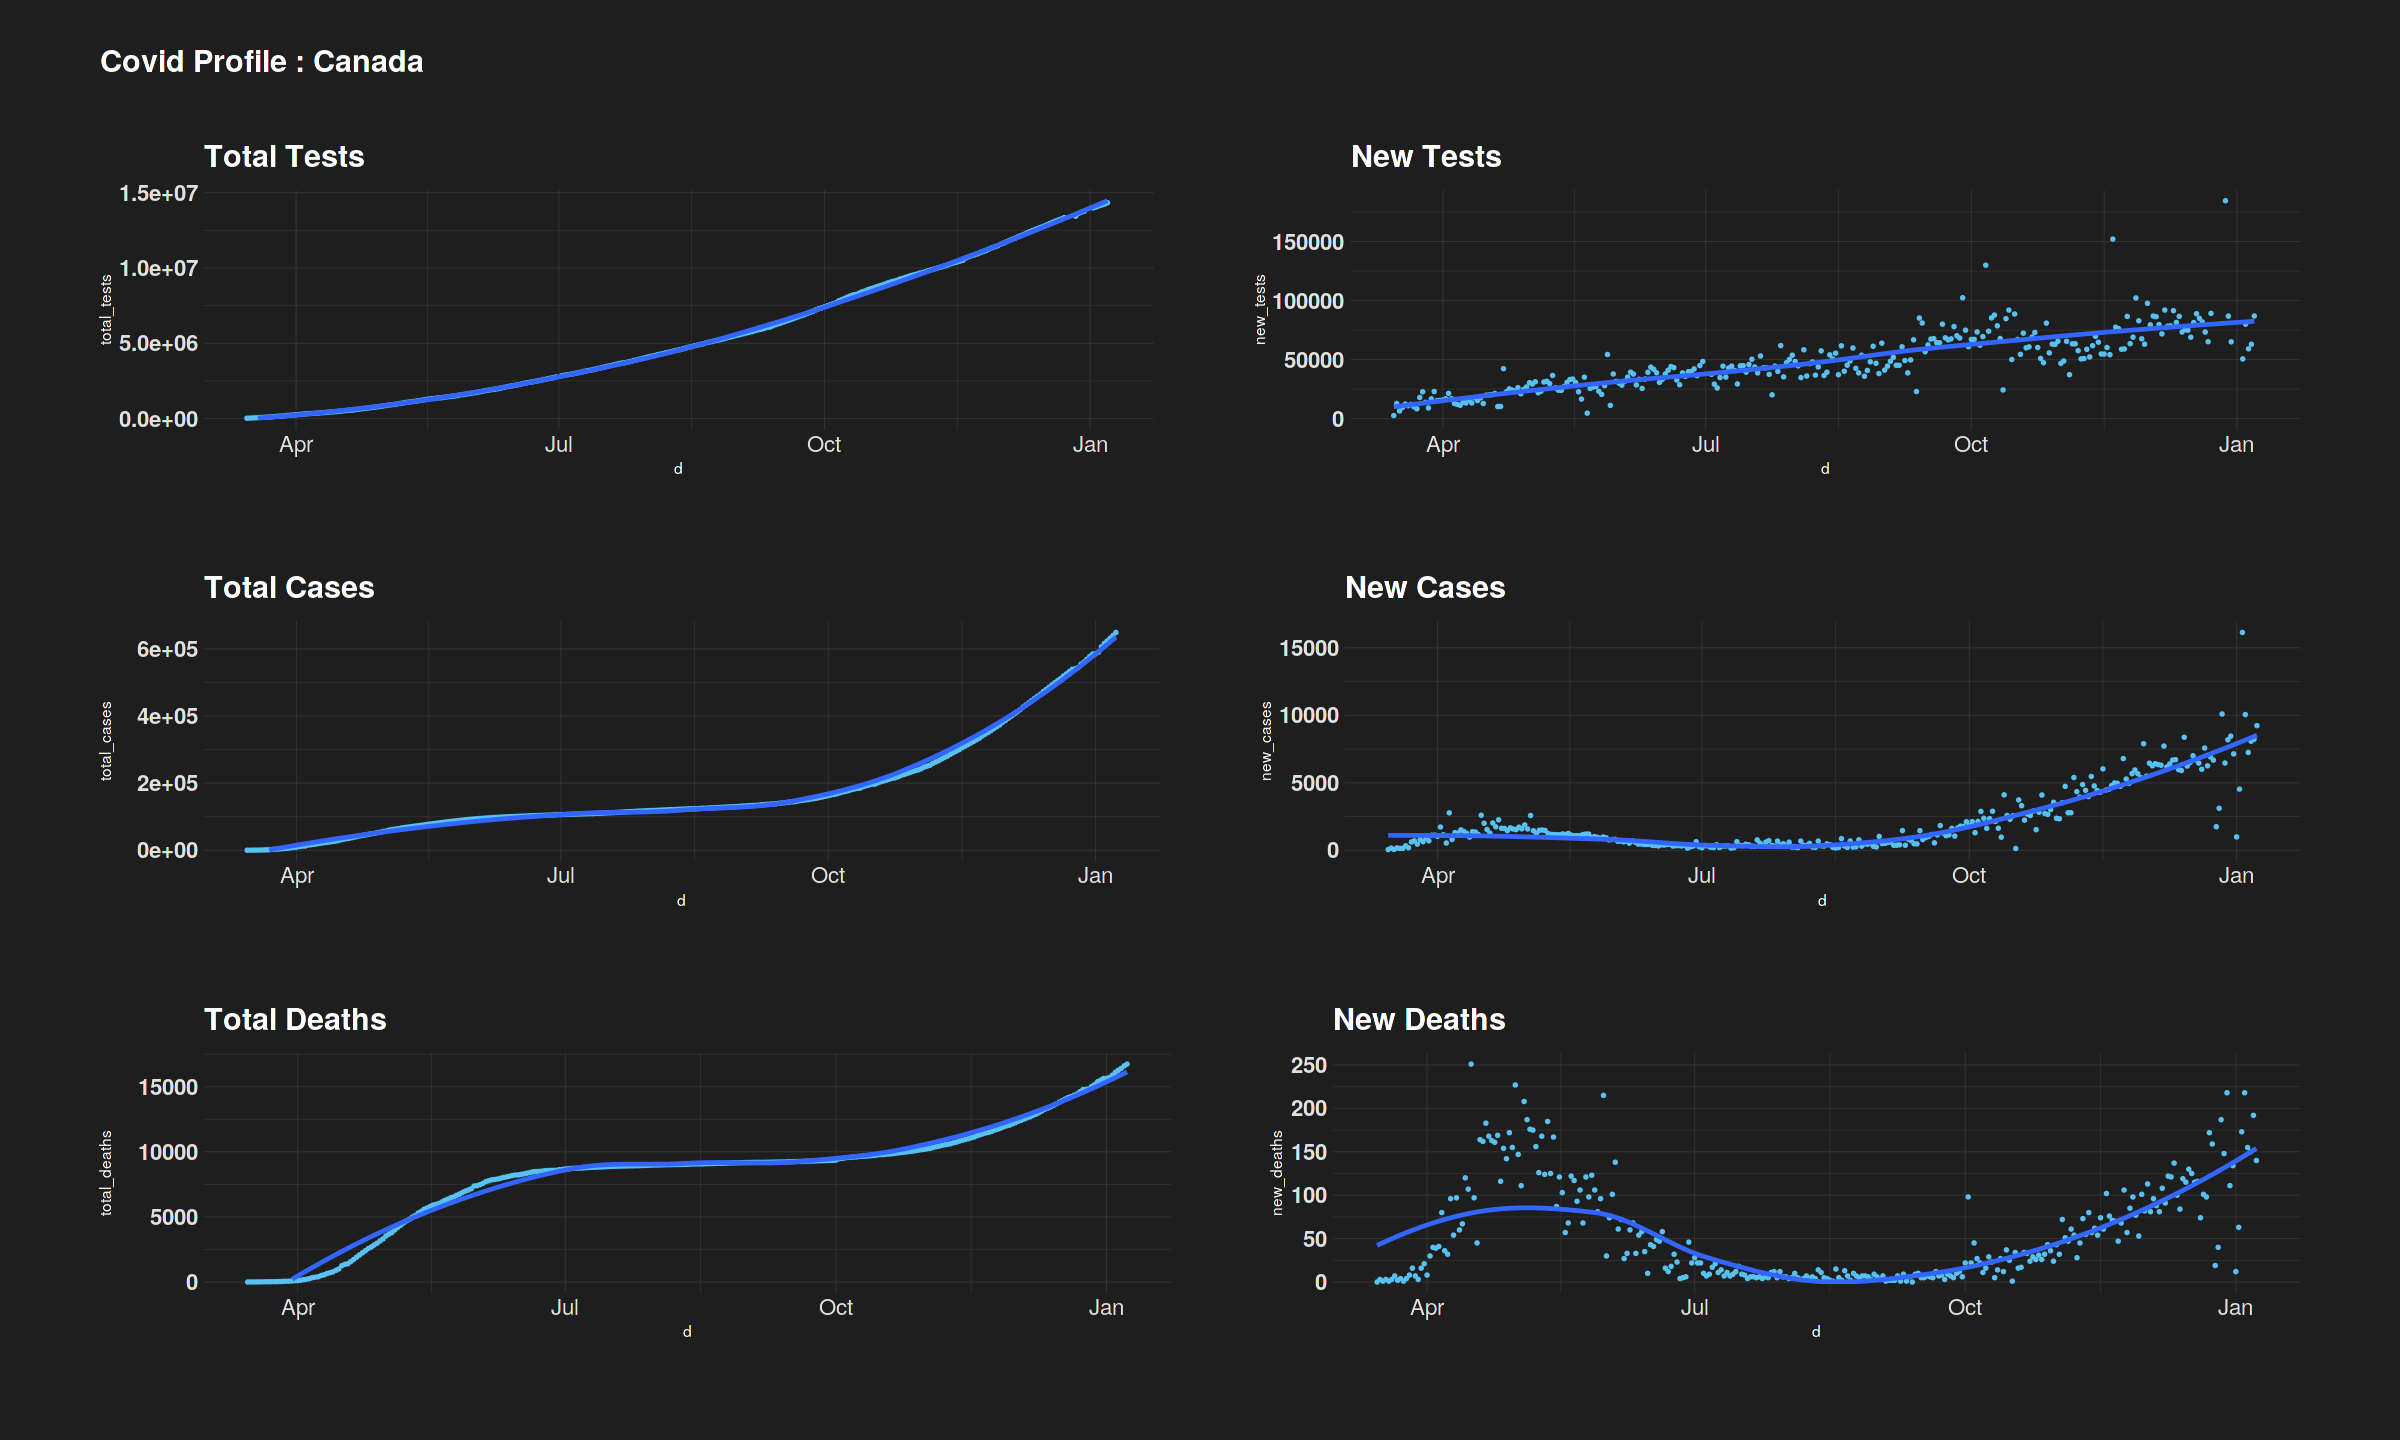

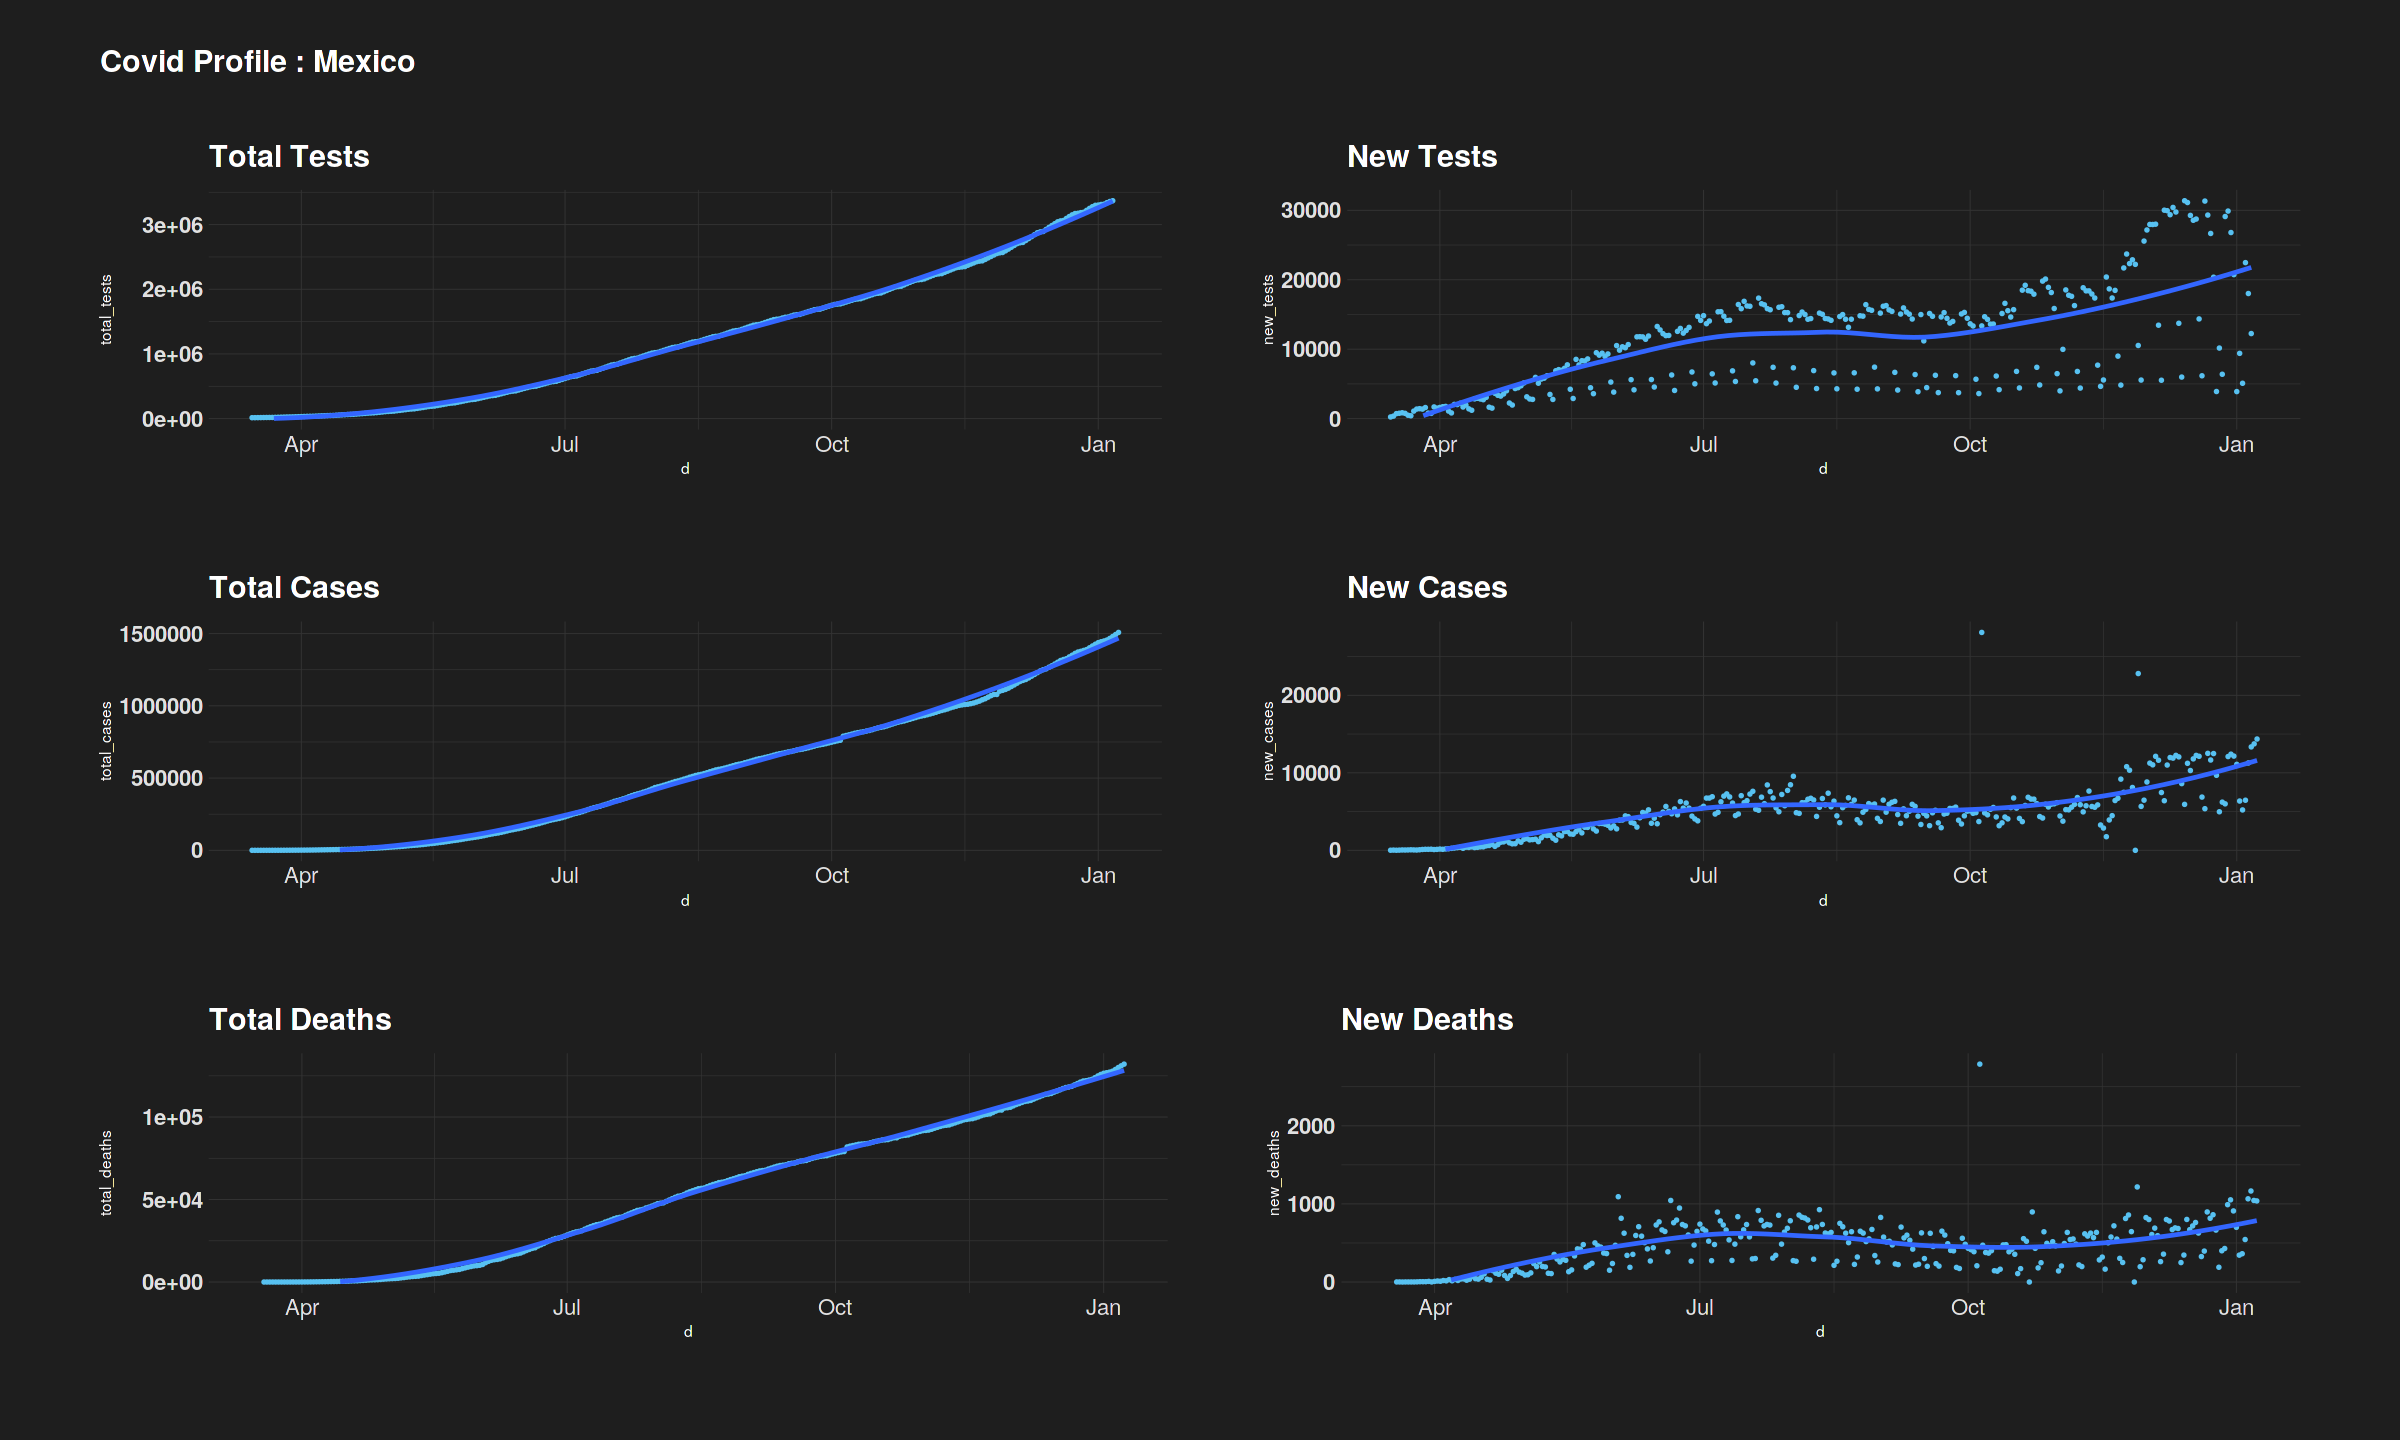

In [27]:
country_plot("United States")
country_plot("Canada")
country_plot("Mexico")

## Europe

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



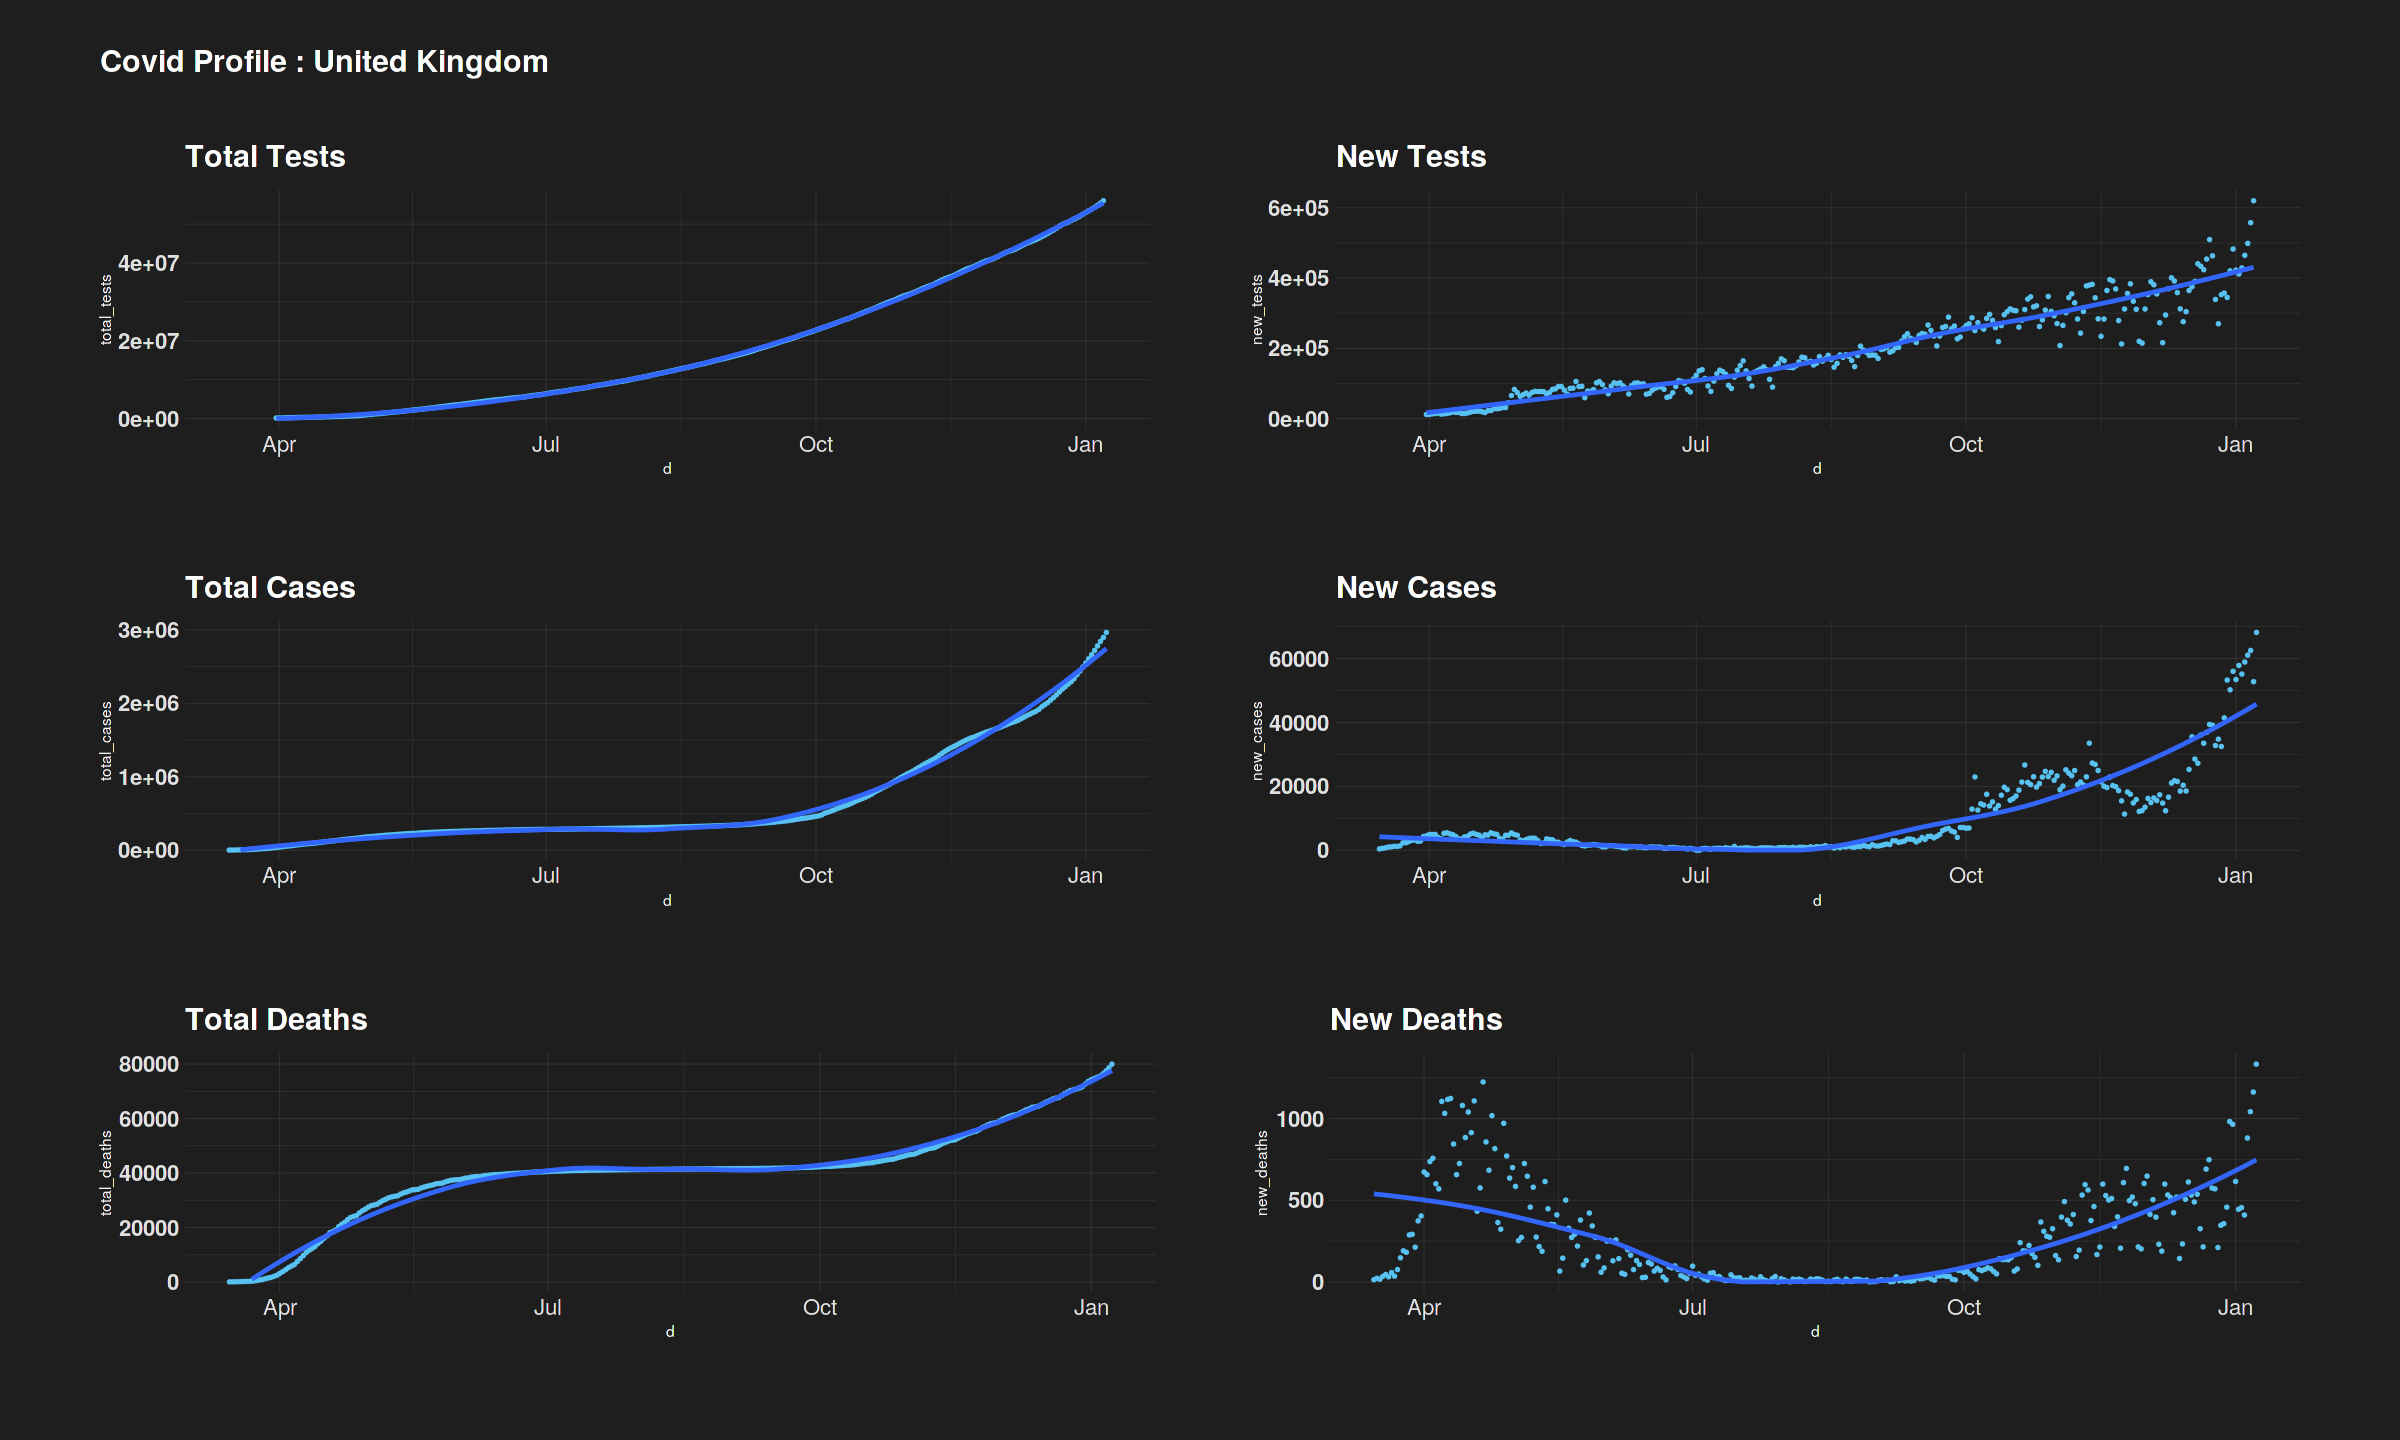

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



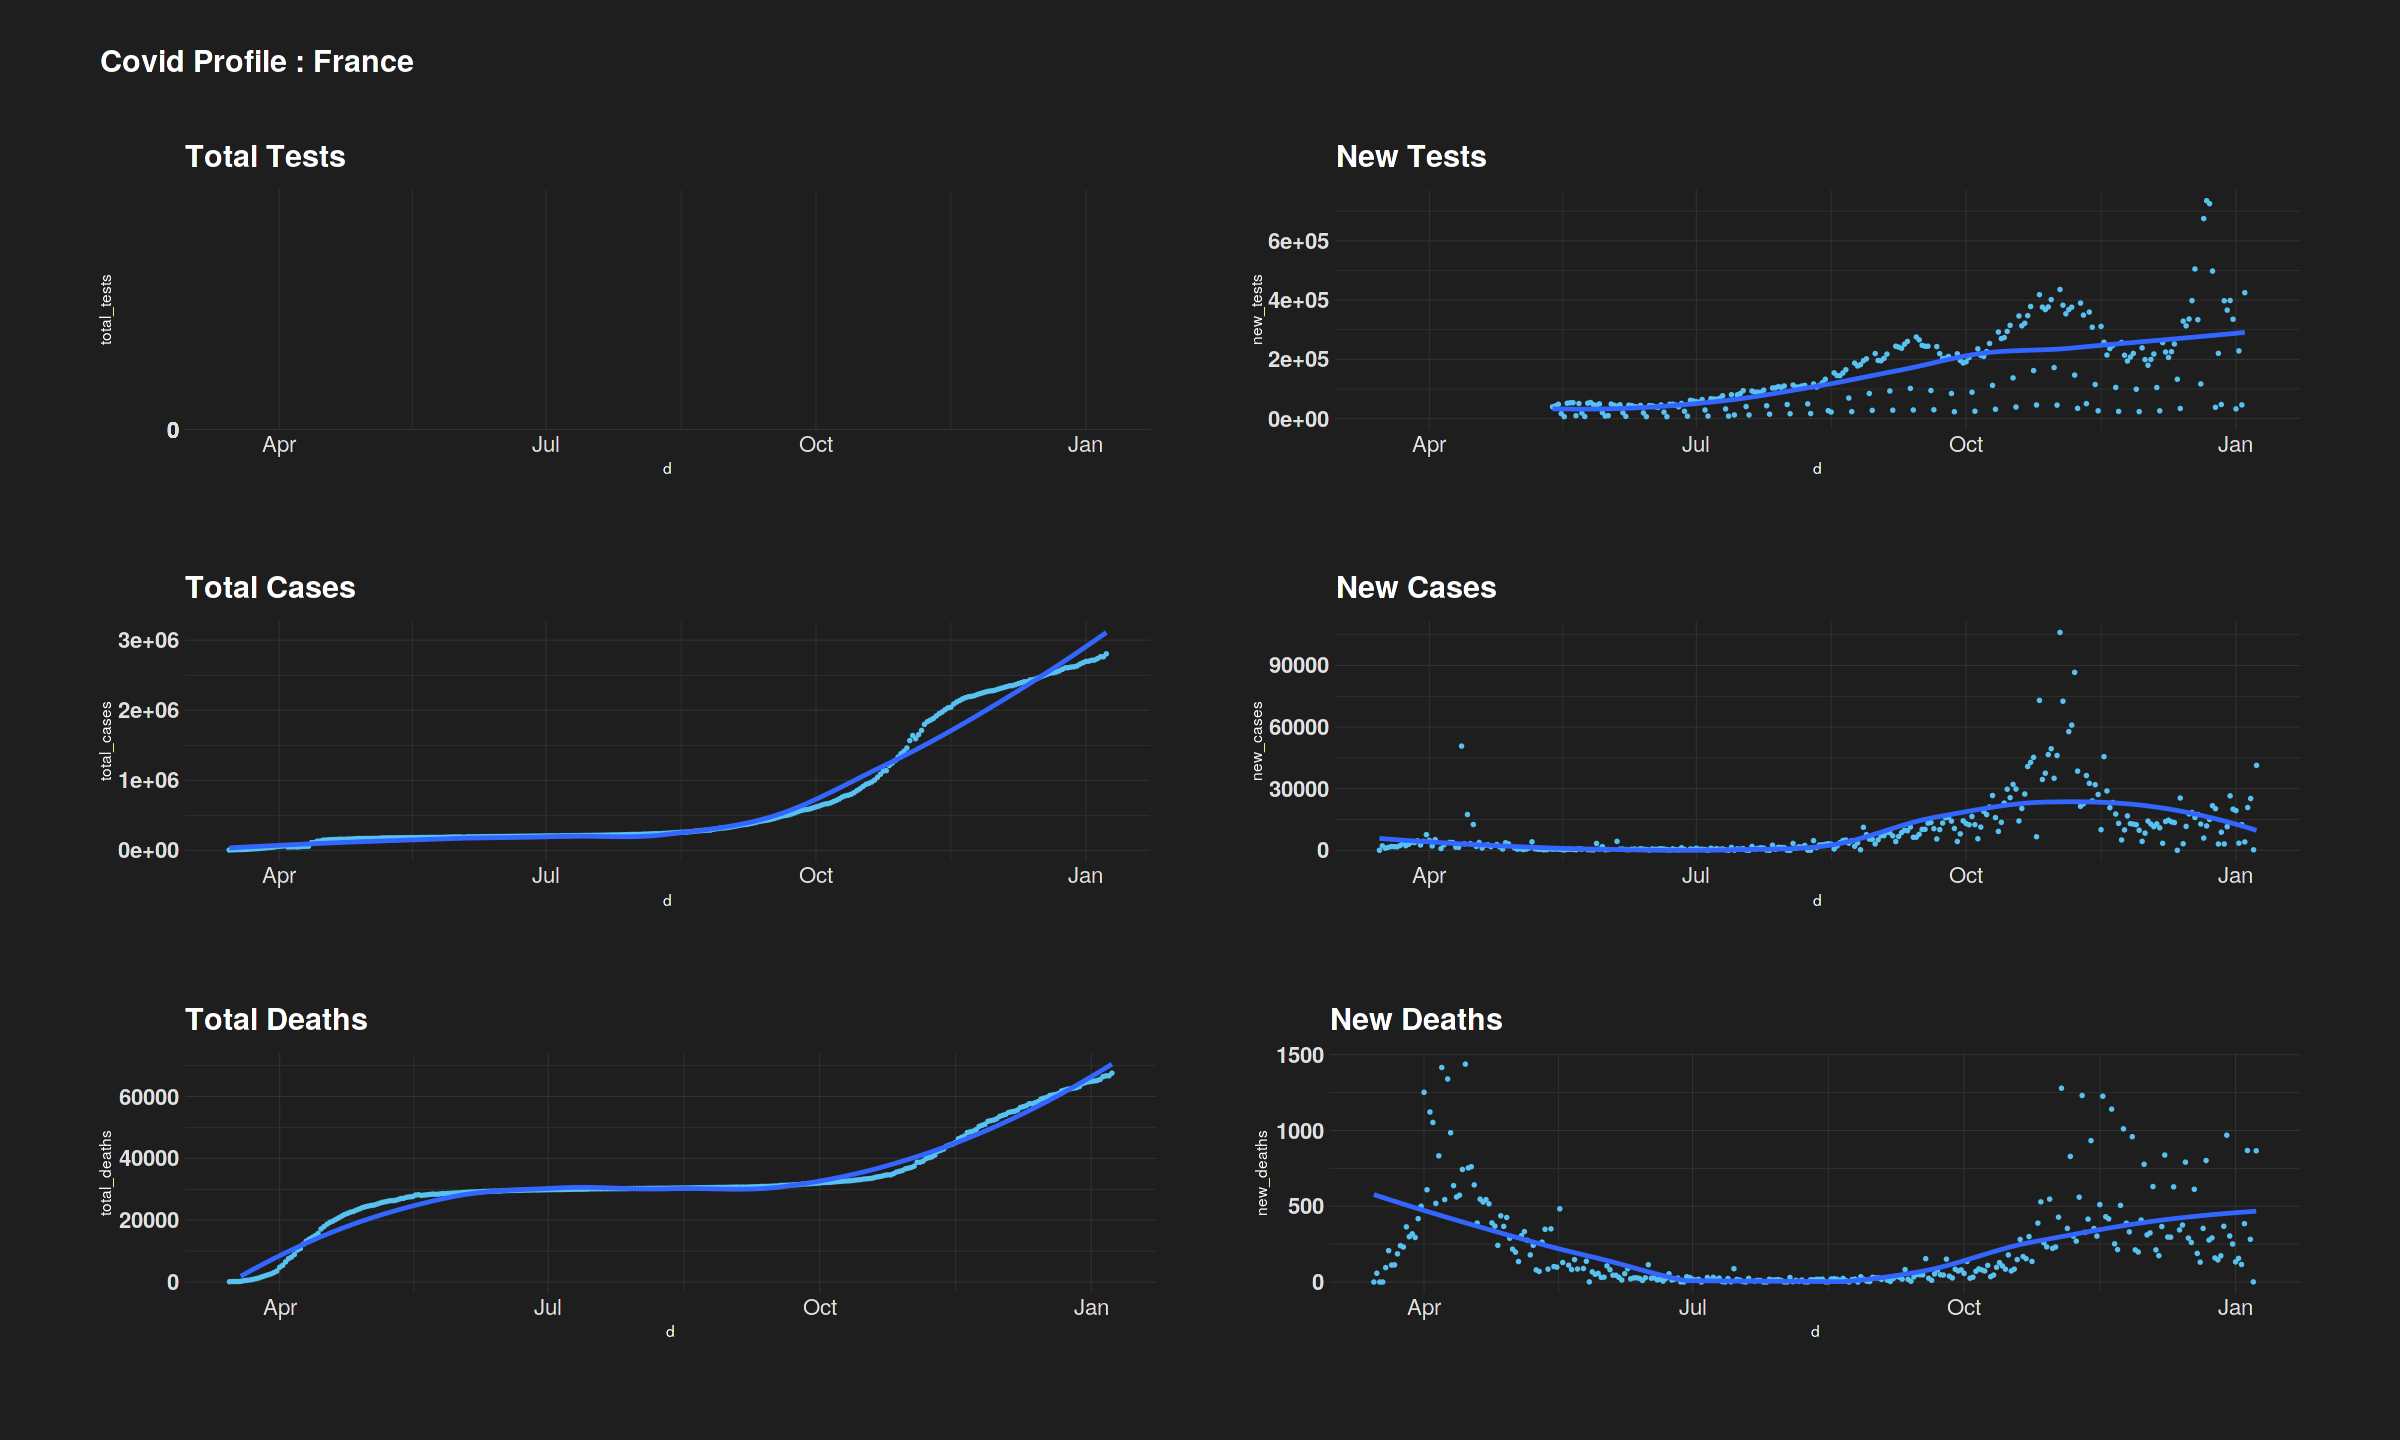

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



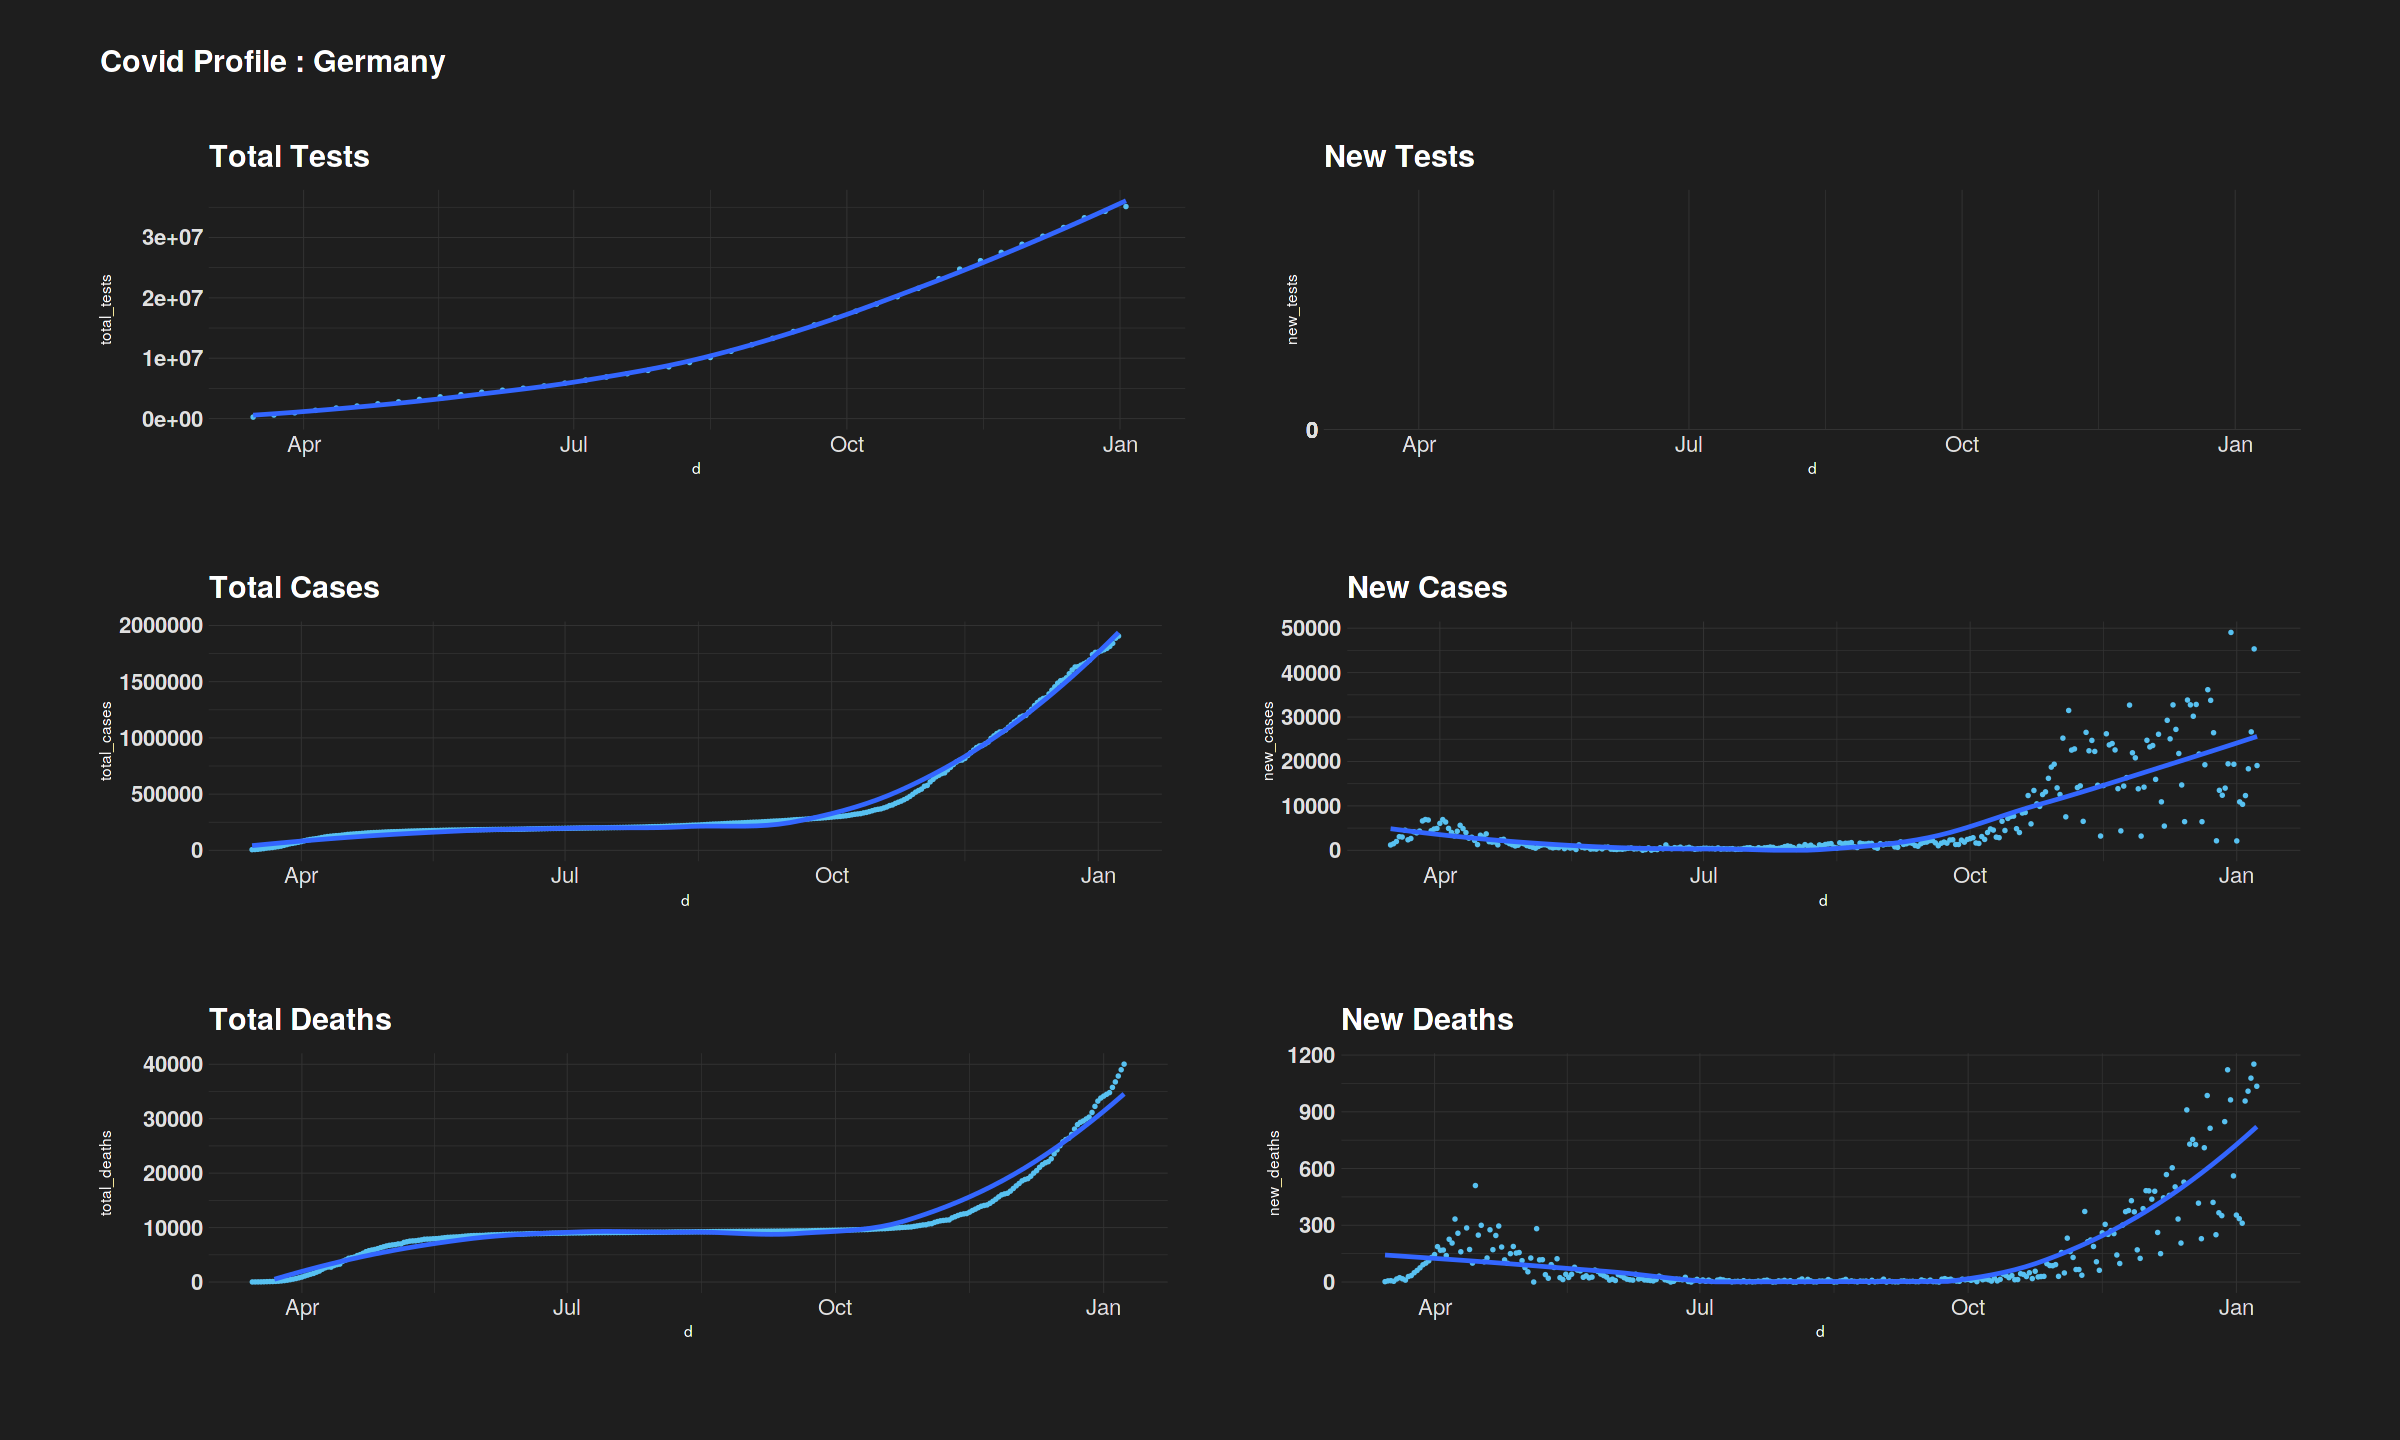

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



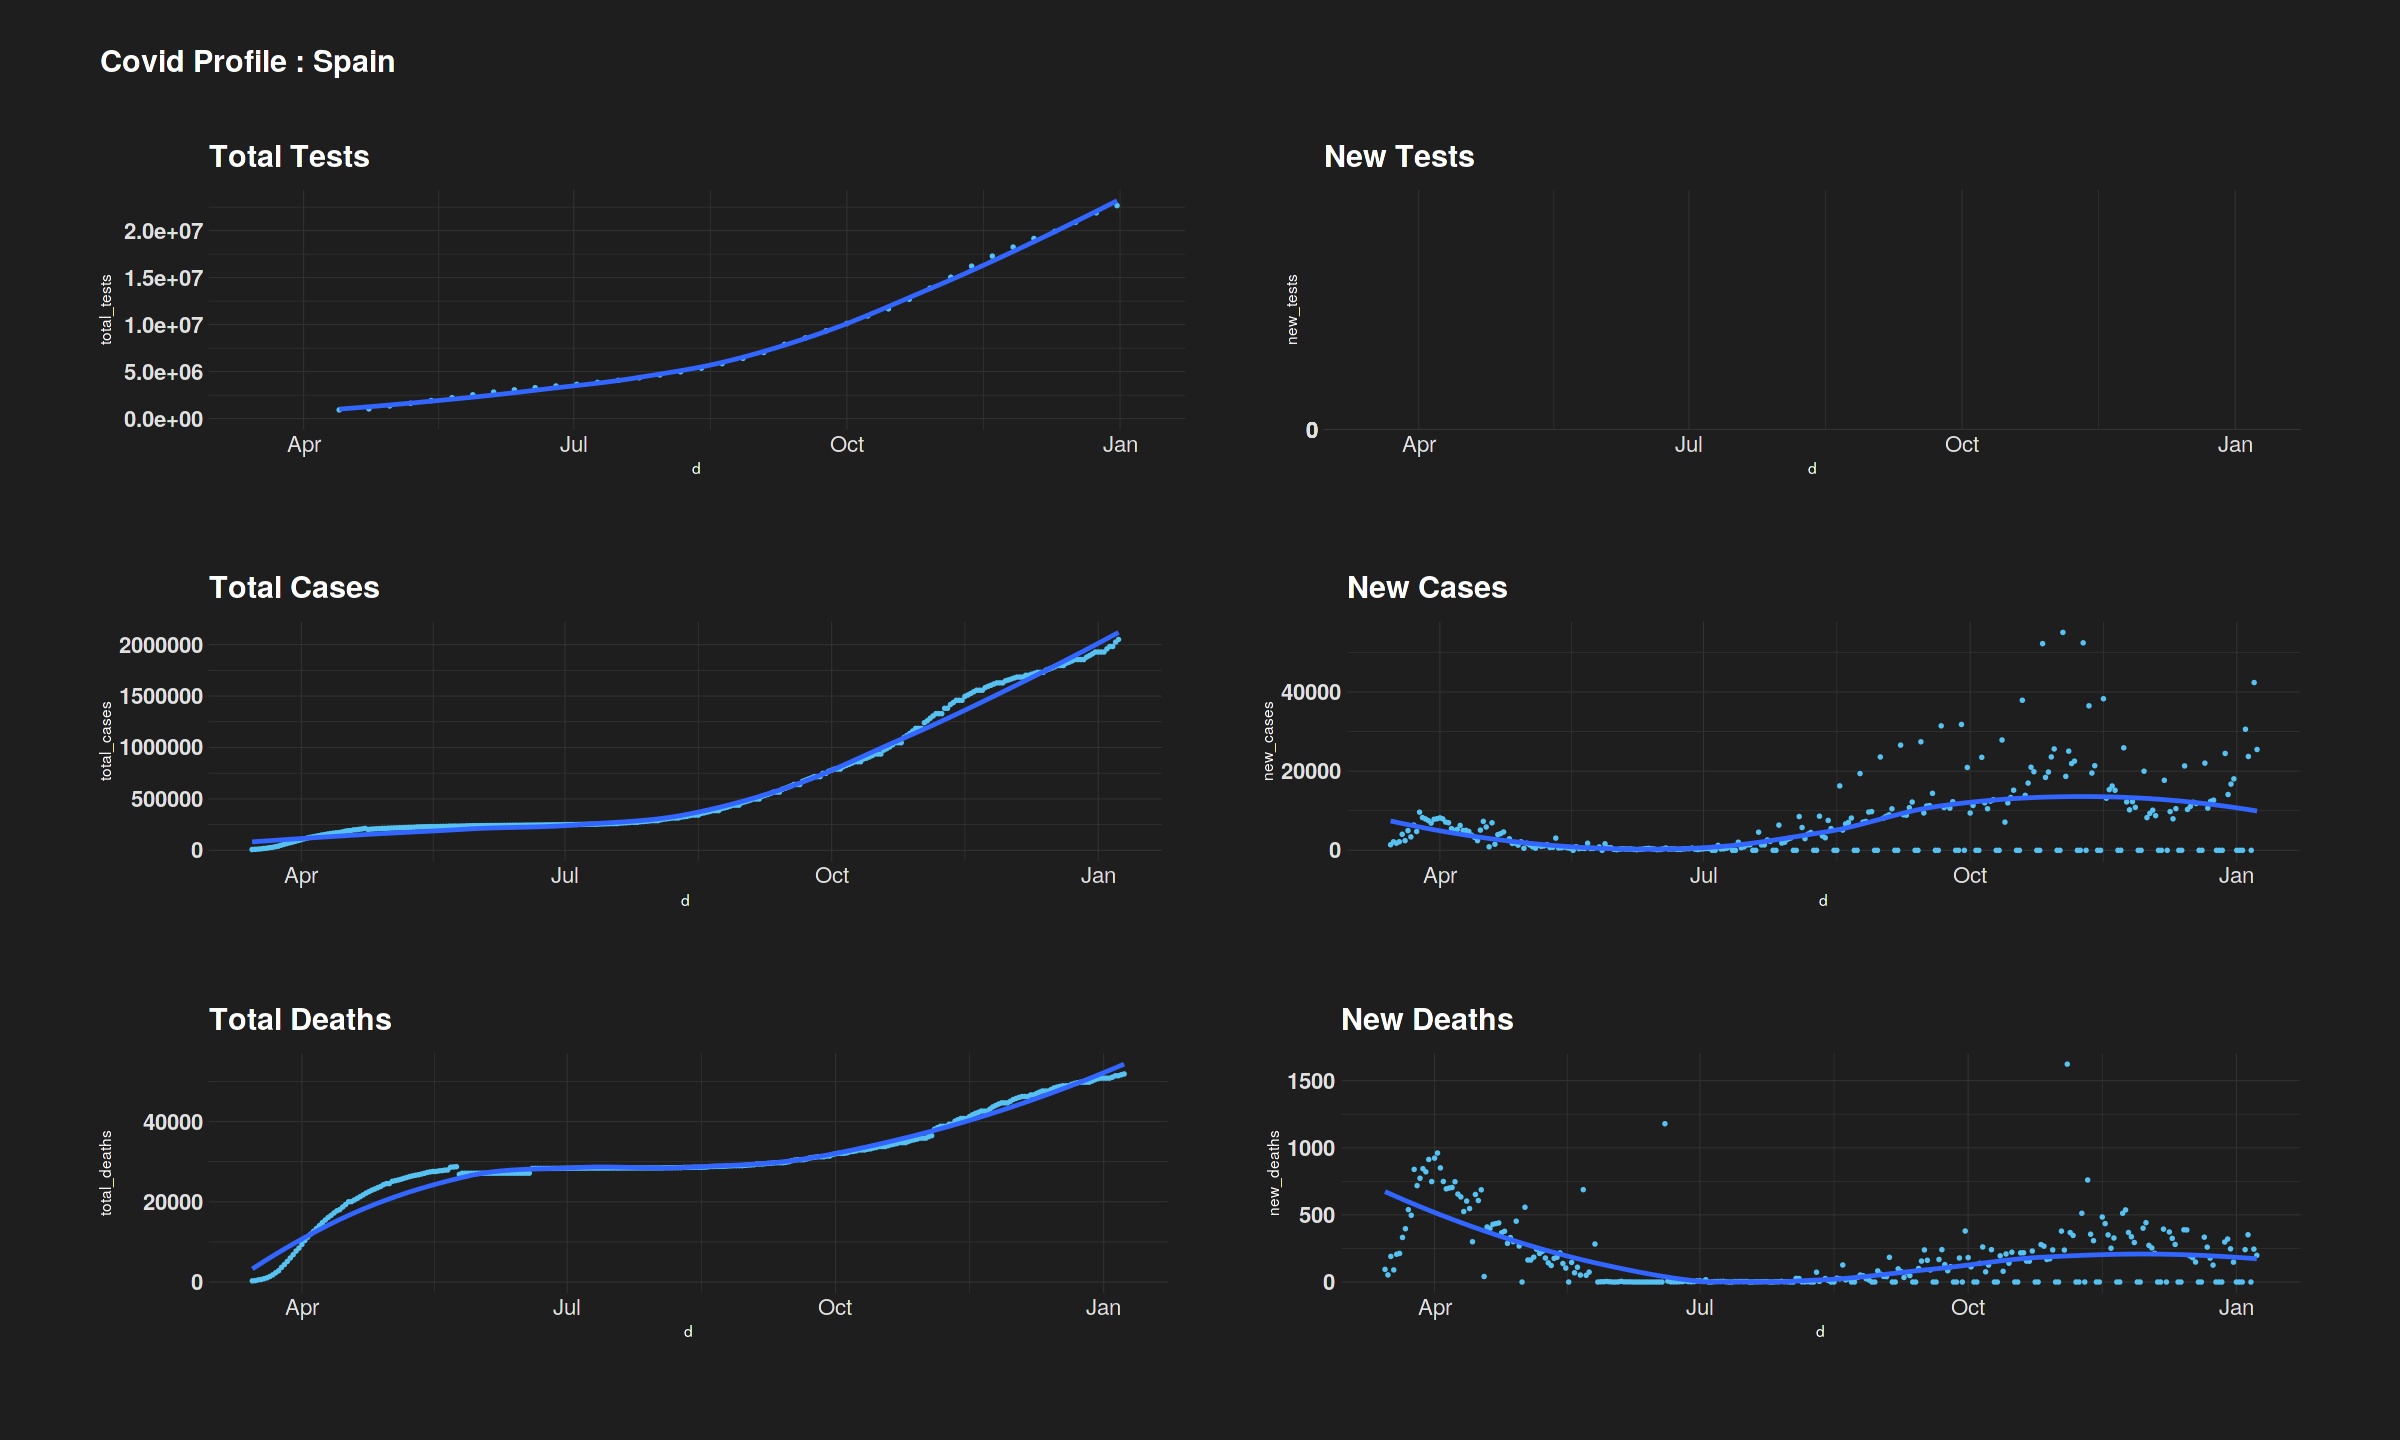

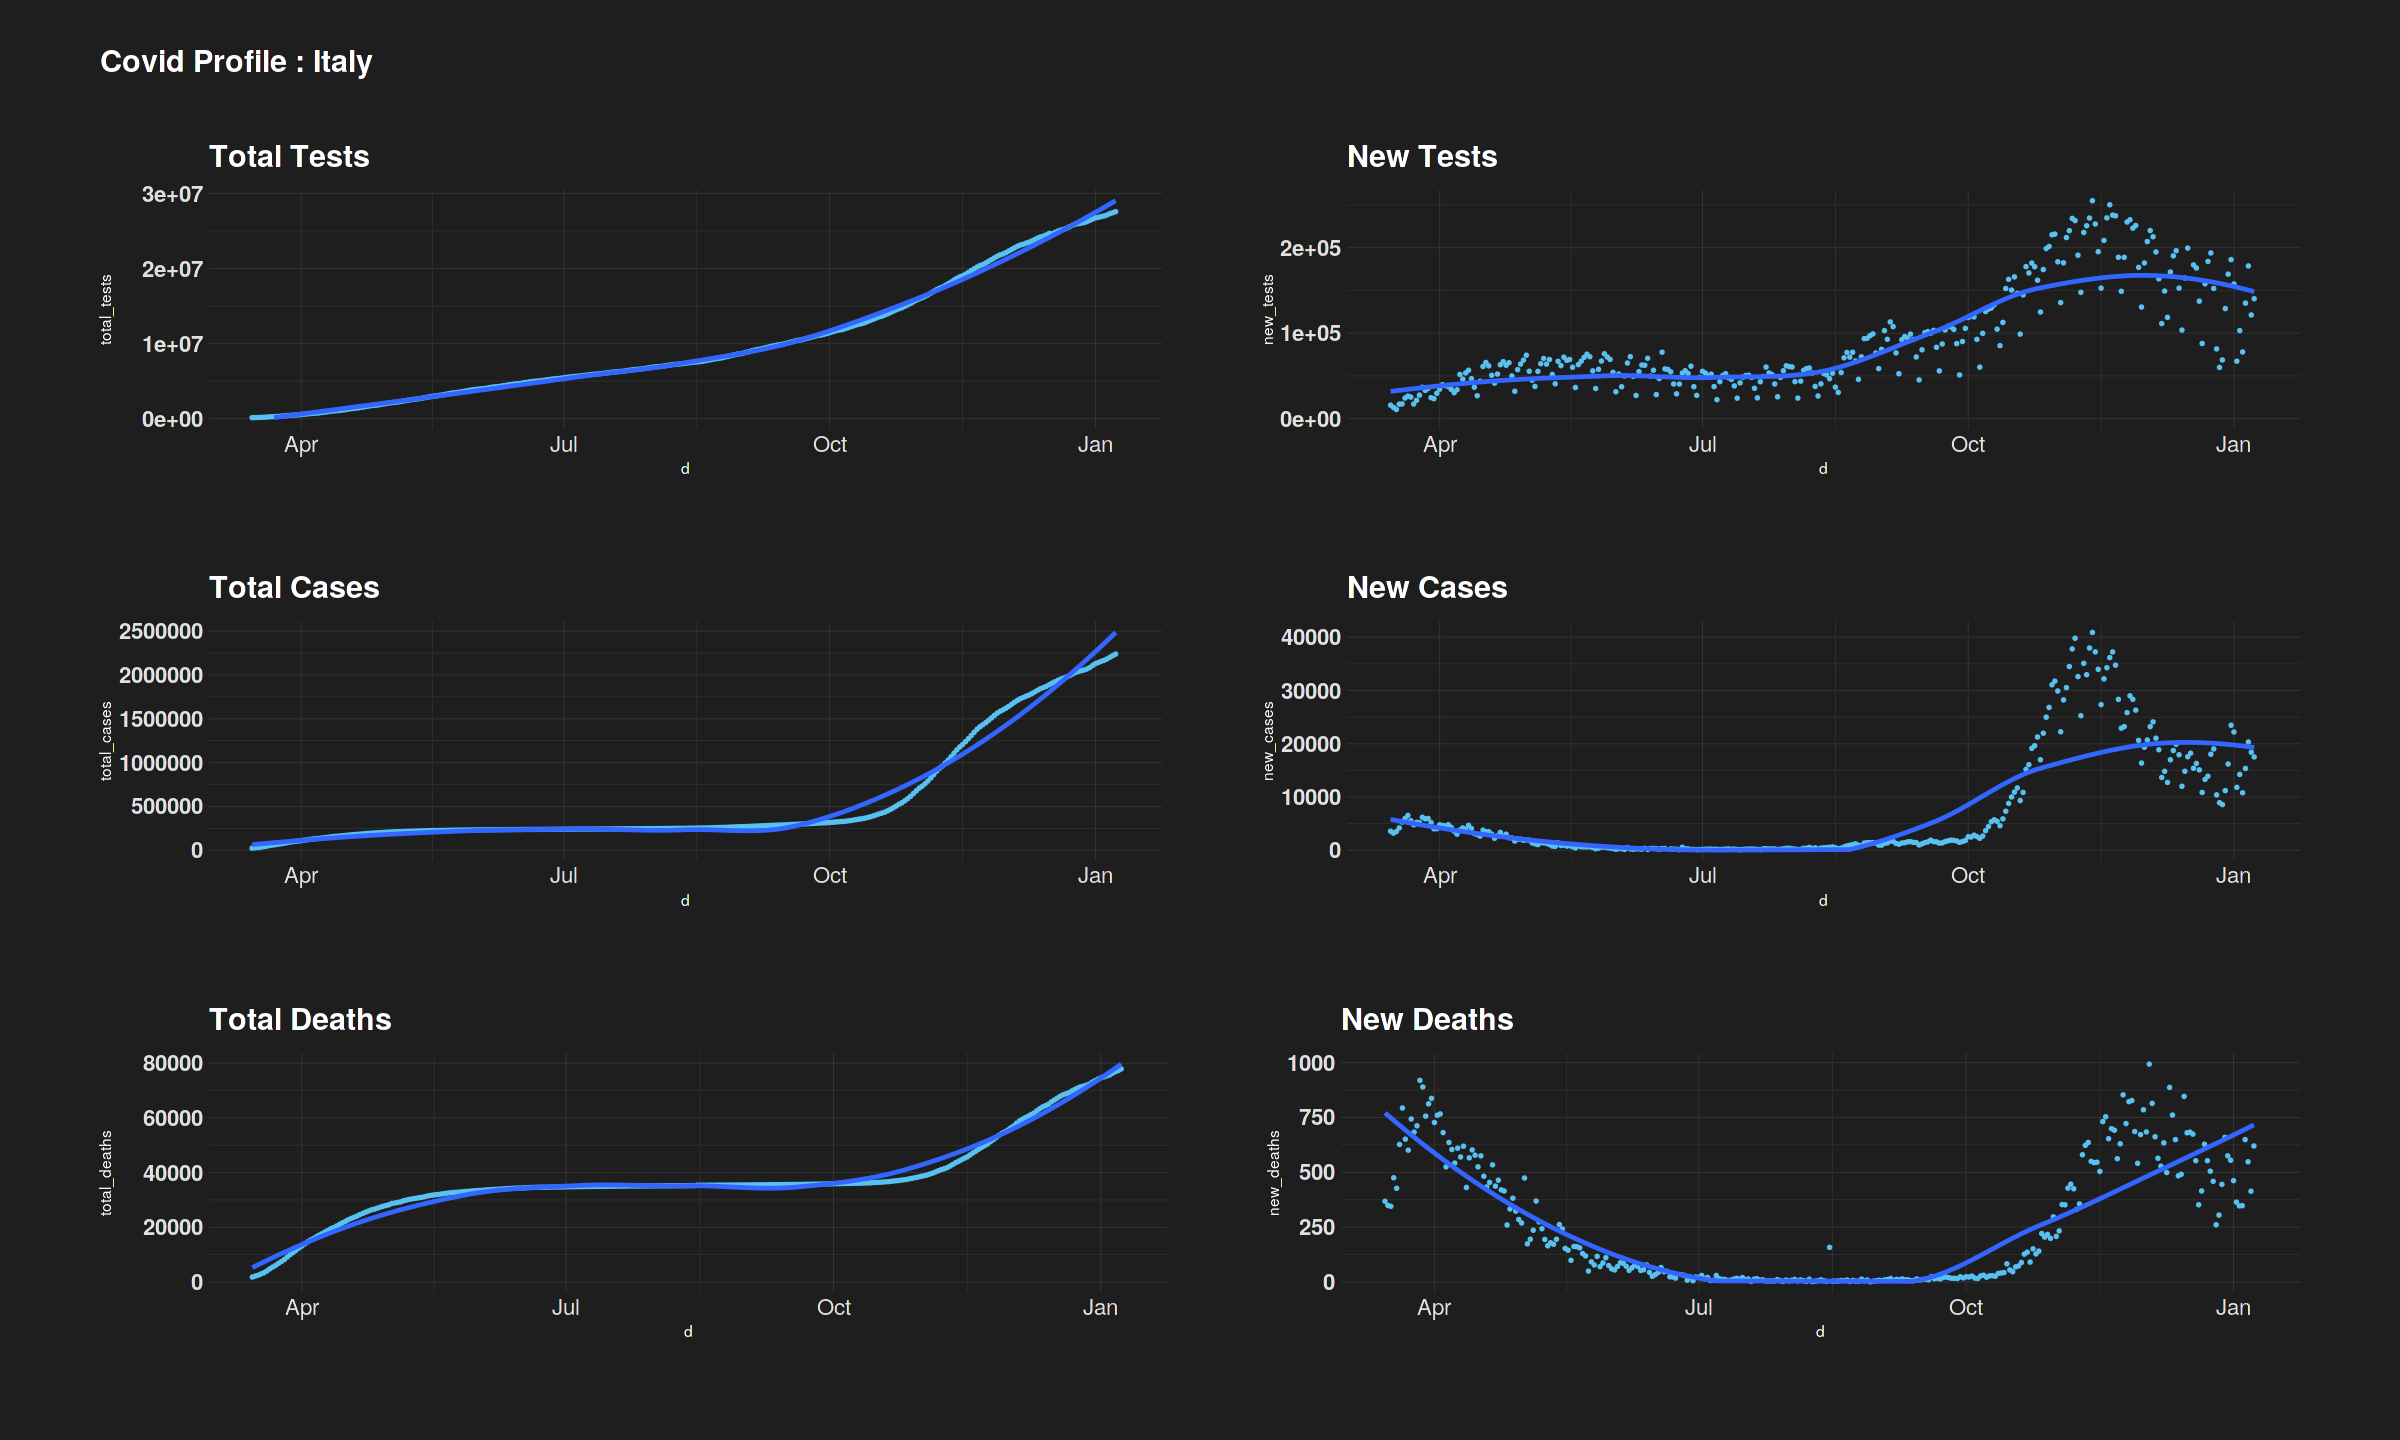

In [28]:
country_plot("United Kingdom")
country_plot("France")
country_plot("Germany")
country_plot("Spain")
country_plot("Italy")

# Excess Mortality

In [29]:
exmort_nyt = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/excess-deaths/deaths.csv")
exmort_nyt[, `:=`(
             start_date = ymd(start_date),
             end_date   = ymd(start_date),
             year = as.numeric(year)
           )
           ]
exmort_nyt %>% glimpse

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


Rows: 5,749
Columns: 12
$ country         <chr> "Israel", "Israel", "Israel", "Israel", "Israel", "Is…
$ placename       <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ frequency       <chr> "weekly", "weekly", "weekly", "weekly", "weekly", "we…
$ start_date      <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ end_date        <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ year            <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020,…
$ month           <int> 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,…
$ week            <int> 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ deaths          <int> 1010, 1099, 1000, 991, 944, 965, 988, 903, 929, 963, …
$ expected_deaths <int> 1071, 1069, 1066, 1059, 1048, 1032, 1011, 987, 961, 9…
$ excess_deaths   <int> -61, 30, -66, -68, -104, -67, -23, -84, -32, 27, -22,…
$ baseline        <chr> "2015-2019 historical data", "2015-2019 historical da…


In [30]:
exmort_nyt[, .N, by = .(country, placename, frequency)]

country        placename frequency N  
1  Israel                   weekly    282
2  Ecuador                  monthly    39
3  Indonesia      Jakarta   monthly   129
4  Portugal                 weekly    286
5  Belgium                  weekly    236
6  Austria                  weekly    287
7  Turkey         Istanbul  weekly    114
8  Brazil                   weekly     29
9  Peru                     monthly    57
10 United States            weekly     87
11 Japan          Tokyo     monthly    60
12 Mexico                   weekly     38
13 South Korea              monthly    67
14 Bolivia                  monthly    55
15 Ireland                  weekly    273
16 Colombia                 weekly    283
17 India          Mumbai    monthly    19
18 Spain                    weekly    127
19 Chile                    weekly    288
20 Germany                  weekly    234
21 France                   weekly    519
22 Sweden                   weekly    287
23 Switzerland              weekly    237
24 Norway                   weekly    287
25 United Kingdom           weekly    536
26 Denmark                  weekly    288
27 Finland                  weekly    186
28 South Africa             weekly     37
29 Netherlands              weekly    238
30 Italy                    monthly    12
31 Thailand                 monthly    64
32 Russia         Moscow    monthly    68

In [31]:
wksamp = exmort_nyt[frequency == "weekly" & year == 2020]

In [32]:
eur = exmort_nyt[country %in% c(
    'Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Italy', 'Netherlands', 
    'Norway', 'Portugal', 'Spain', 'Sweden', 'United Kingdom', "Switzerland"
    ) & year == 2020 & placename == ""]
eur[, .SD[1], by = country]

country        placename frequency start_date end_date   year month week
1  Portugal                 weekly    2020-01-06 2020-01-06 2020 1      2  
2  Belgium                  weekly    2020-01-06 2020-01-06 2020 1      2  
3  Austria                  weekly    2020-01-06 2020-01-06 2020 1      2  
4  Spain                    weekly    2020-01-06 2020-01-06 2020 1      2  
5  Germany                  weekly    2020-01-06 2020-01-06 2020 1      2  
6  France                   weekly    2020-01-06 2020-01-06 2020 1      2  
7  Sweden                   weekly    2020-01-06 2020-01-06 2020 1      2  
8  Switzerland              weekly    2020-01-06 2020-01-06 2020 1      2  
9  Norway                   weekly    2020-01-06 2020-01-06 2020 1      2  
10 United Kingdom           weekly    2020-01-04 2020-01-04 2020 1      2  
11 Denmark                  weekly    2020-01-06 2020-01-06 2020 1      2  
12 Finland                  weekly    2020-01-06 2020-01-06 2020 1      2  
13 Netherlands              weekly    2020-01-06 2020-01-06 2020 1      2  
14 Italy                    monthly   <NA>       <NA>       2020 1     NA  
   deaths expected_deaths excess_deaths baseline                 
1   2654   2903            -249         2015-2019 historical data
2   2380   2395             -15         2016-2019 historical data
3   1702   1814            -112         2015-2019 historical data
4   8936   9211            -275         2018-2019 historical data
5  19440  19662            -222         2016-2019 historical data
6  13404  13654            -250         2010-2019 historical data
7   1890   1881               9         2015-2019 historical data
8   1350   1477            -127         2016-2019 historical data
9    948    911              37         2015-2019 historical data
10 16020  15469             551         2010-2019 historical data
11  1149   1121              28         2015-2019 historical data
12  1068   1155             -87         2017-2019 historical data
13  3364   3327              37         2016-2019 historical data
14 58650  61646           -2996         2015-2019 historical data

In [33]:
eur[is.na(start_date), start_date := ymd(paste0(year, '-', month, "-01"))]
eur[, excess := fifelse(excess_deaths > 0, 1, 0)]

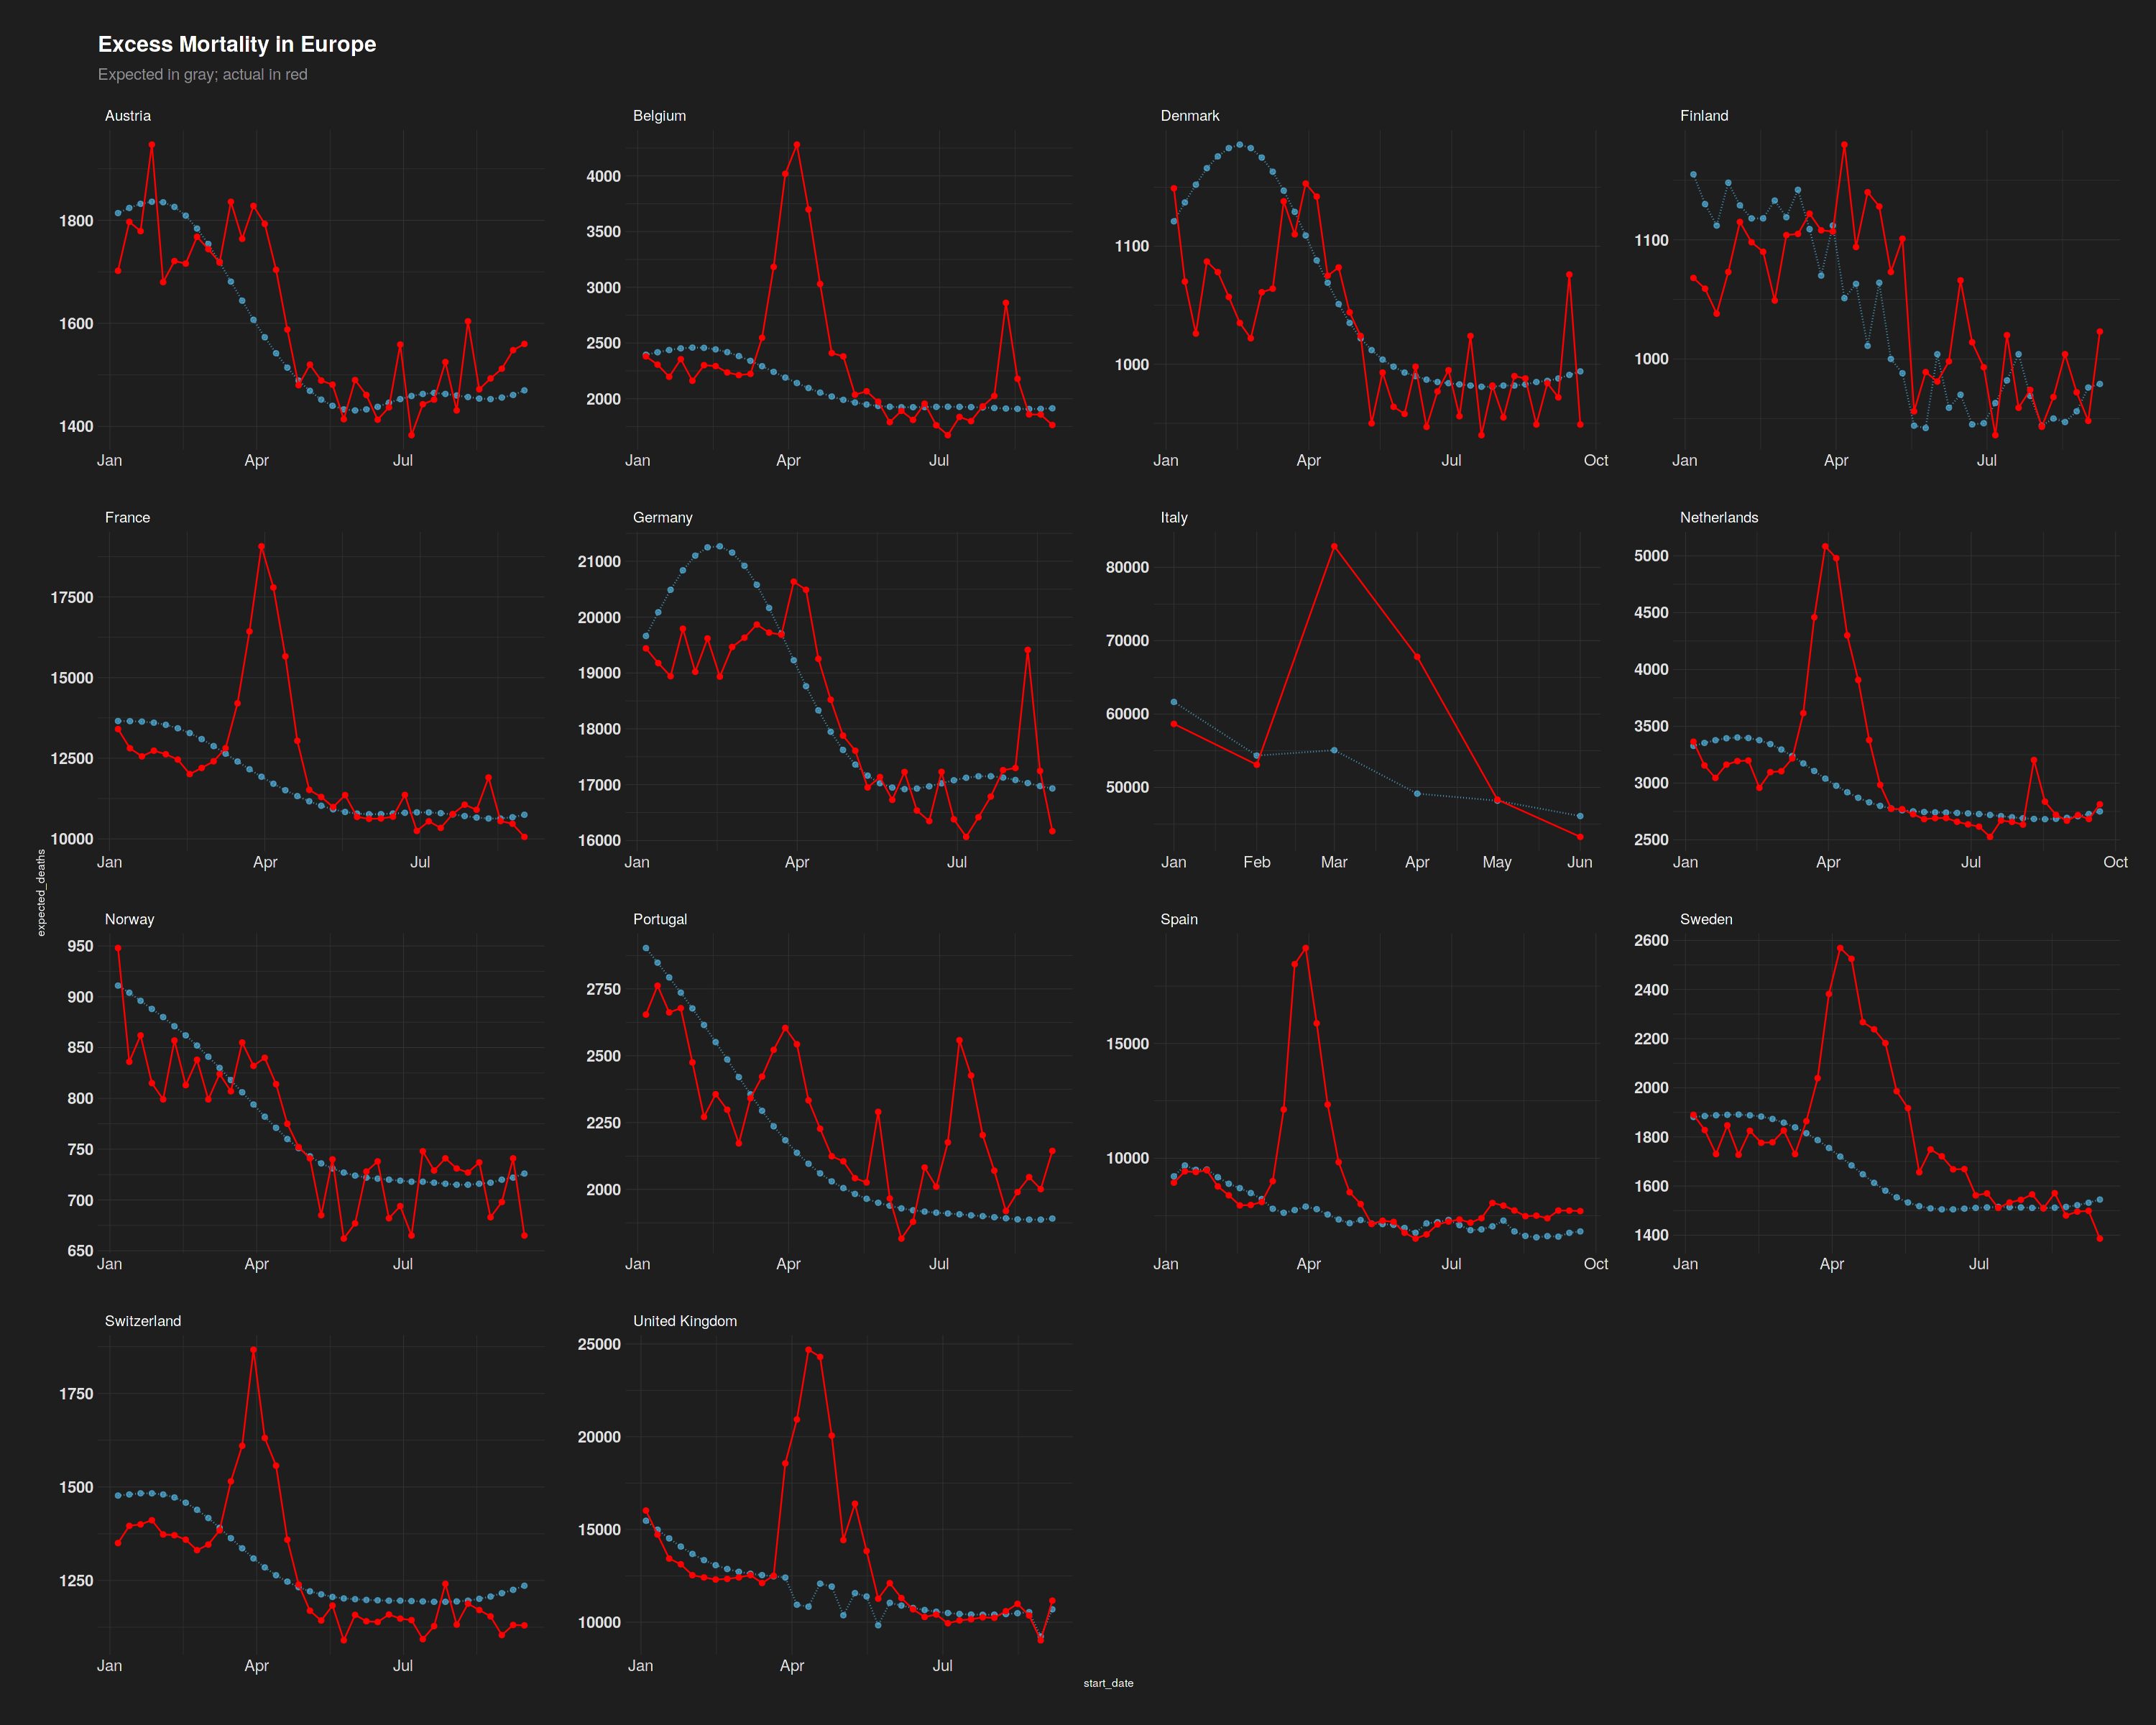

In [34]:
options(repr.plot.width = 25, repr.plot.height=20)
ggplot(eur, aes(x = start_date, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ country, scales = 'free') +
    labs(title = "Excess Mortality in Europe", subtitle = "Expected in gray; actual in red") 

In [35]:
us_samp = exmort_nyt[year == 2020 & country == "United States" & placename != ""]
us_samp[, dt := ifelse(is.na(start_date), year + month, year + month + week - 1)]
us_samp[, .SD[1:2], by = placename] 

placename country frequency start_date end_date year month week deaths
     expected_deaths excess_deaths baseline dt